<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Carrefour/Carrefour_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "CA.PA"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02  28.80  29.49  28.25  29.49      21.19  2889620
2009-01-05  29.50  29.50  28.73  28.90      20.77  2246267
2009-01-06  29.02  29.49  28.77  28.91      20.77  1990670
2009-01-07  28.76  29.34  28.73  28.95      20.81  2280362
2009-01-08  28.72  28.72  27.24  27.88      20.03  3314871
...           ...    ...    ...    ...        ...      ...
2018-12-21  14.85  14.90  14.38  14.83      14.43  6014637
2018-12-24  14.59  14.73  14.48  14.51      14.12  1242298
2018-12-27  14.73  14.88  14.36  14.51      14.12  2049071
2018-12-28  14.51  15.00  14.50  14.82      14.43  2473519
2018-12-31  14.90  14.99  14.78  14.91      14.51   810176

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     24.719077    24.986823    24.430947    24.707668    20.665313  3.217745e+06
std       6.461417     6.513481     6.406775     6.464161     4.553936  1.899570e+06
min      13.080000    13.180000    12.870000    13.060000    10.810000  0.000000e+00
25%      18.977500    19.215000    18.697500    18.947500    16.677500  2.182668e+06
50%      24.030000    24.380000    23.750000    24.075000    21.125000  2.814887e+06
75%      29.745000    30.095000    29.430000    29.802500    24.052500  3.734451e+06
max      41.200000    41.280000    40.170000    41.280000    31.700000  3.161033e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  26.99  26.99  26.00  26.05      18.72  4071856   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  24.268866  25.417628  22.443864  25.198903  25.175302  24.619803      24.480      24.525  22.414400  24.52750  25.687047  24.2930  24.928056  24.52750  25.596667  25.616245               26.696111                 24.52750               22.358889               27.780417                 24.52750               21.274583               28.864723                 24.52750               20.190277               29.949028                 24.52750               19.105972  25.175302  25.649375  25.452098               27.343913                25.175302               23.006691               28.428219                25.175302               21.922385               29.512525                25.175302               20.838080               30.596830                25.175302   
2009-03-16  26.74  26.77  25.96  26.28      18.88  3481021   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  24.369423  25.391423  22.807555  25.630082  25.420791  24.726447      24.585      24.525  22.780448  24.74125  26.154176  24.7170  25.317500  24.74125  26.165000  25.526301               27.201909                 24.74125               22.280591               28.432239                 24.74125               21.050261               29.662568                 24.74125               19.819932               30.892898                 24.74125               18.589602  25.420791  26.149736  25.378840               27.881450                25.420791               22.960131               29.111779                25.420791               21.729802               30.342109                25.420791               20.499472               31.572439                25.420791   
2009-03-17  26.00  26.70  25.92  26.59      1

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     24.679629    24.943843    24.395004    24.668611    20.695335  3.211698e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    24.683674    24.712245    -0.883181    24.668411    24.682771    24.670636    24.672111    24.659761    24.660834    24.682380    24.668997    24.682531    24.678009    24.682380    24.670398    24.712076               25.544898                24.682380               23.819862               25.976157                24.682380               23.388602               26.407416                24.682380               22.957343               26.838675                24.682380               22.526084    24.682771    24.671623    24.707475               25.545289                24.682771               23.820253               25.976548                24.682771               23.388993               26.407807   
std       6.516630     6.568575     6.462248     6.519662     4.592153  1.910992e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     6.468592     6.377510    25.501648     6.525337     6.481594     6.520995     6.486091     6.476126     6.482726     6.489978     6.523957     6.494113     6.496523     6.489978     6.514331     6.438470                6.635685                 6.489978                6.381165                6.721647                 6.489978                6.341211                6.815918                 6.489978                6.311152                6.918159                 6.489978                6.291129     6.481594     6.510521     6.445810                6.627515                 6.481594                6.372606                6.713596                 6.481594                6.332583                6.807994   
min      13.080000    13.180000    12.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.494666  0.491459  0.480952  0.460312   0.378650  4071856   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.408037  0.454557  0.788378  0.433296  0.441512  0.416422    0.409996    0.414283  0.335952  0.414817  0.451629  0.406354  0.428997  0.414817  0.451076  0.464465                0.460252                 0.414817                0.367519                0.476986                 0.414817                0.349587                0.492647                 0.414817                0.334183                0.507335                 0.414817                0.316350  0.441512  0.449763  0.457568                0.478969                 0.441512                0.401932                0.495118                 0.441512                0.383627                0.510229                 0.441512                0.362528                0.522790                 0.441512   
2009-03-16  0.485775  0.483630  0.479487  0.468462   0.386309  3481021   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.411864  0.453506  0.792877  0.448926  0.450804  0.420459    0.413869    0.414283  0.348837  0.422759  0.468332  0.422071  0.443454  0.422759  0.471698  0.460941                0.478107                 0.422759                0.364608                0.499234                 0.422759                0.341321                0.519005                 0.422759                0.320698                0.537548                 0.422759                0.297936  0.450804  0.467844  0.454715                0.497987                 0.450804                0.400194                0.518499                 0.450804                0.376501                0.537692                 0.450804                0.350211                0.553986                 0.450804   
2009-03-17  0.459459  0.481139  0.478022  0.479447  

140444

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpavt6lz7k
  JVM stdout: /tmp/tmpavt6lz7k/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpavt6lz7k/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_wo4dzt
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190827_170921  0.570312  0.686533              0.476721  0.496698  0.246709
1  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.565358  0.887527              0.488281  0.552993  0.305801
2  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.553639  0.692068              0.500000  0.499461  0.249462
3  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.530805  0.691943              0.484693  0.499407  0.249407
4  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.500000  0.696863              0.500000  0.501851  0.251854
5  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.500000  0.695088              0.500000  0.500969  0.250970
6  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.500000  0.695270              0.500000  0.501059  0.251060
7  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.494982  0.739731              0.496094  0.521100  0.271546
8  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.472942  3.775790              0.500000  0.690646  0.476992
9  DeepLearning_grid_1_AutoML_20190827_170921_mod...  0.457063  0.769318              0.492188  0.533215  0.284318

variable  relative_importance  scaled_importance  percentage
0           CDLMORNINGDOJISTAR             1.000000           1.000000    0.001617
1                        RSI_8             0.979809           0.979809    0.001584
2                      KAMA_24             0.965899           0.965899    0.001562
3      BBANDS_upperband_30_5_5             0.958794           0.958794    0.001550
4      BBANDS_upperband_30_1_5             0.940707           0.940707    0.001521
...                        ...                  ...                ...         ...
1039  BBANDS_middleband_20_1_4             0.298702           0.298702    0.000483
1040                   BETA_14             0.295958           0.295958    0.000479
1041    BBANDS_lowerband_8_6_4             0.270109           0.270109    0.000437
1042                 MAVP_12_2             0.263516           0.263516    0.000426
1043                     DX_20             0.226039           0.226039    0.000366

[1044 rows x 4 columns]

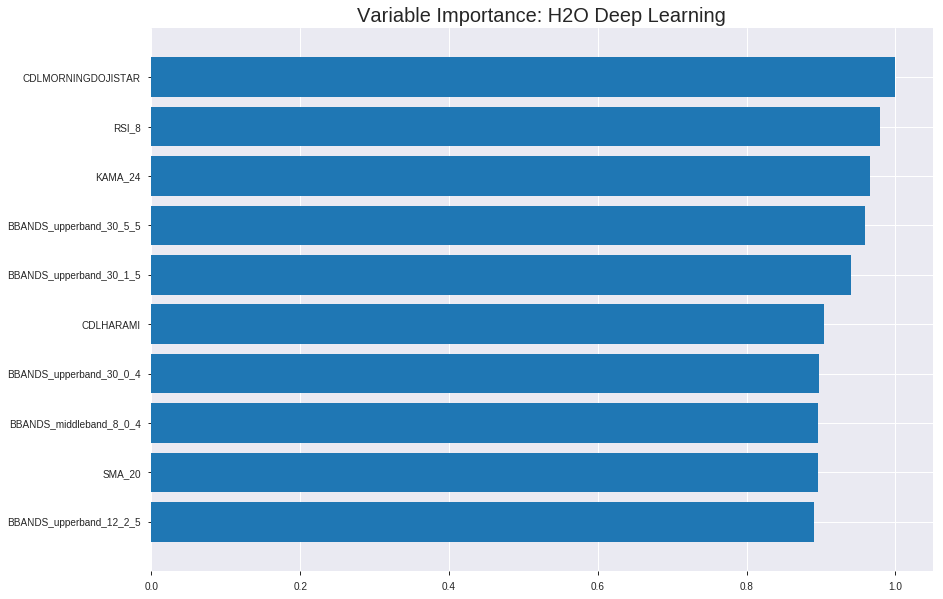

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_170921


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23679511992648325
RMSE: 0.4866159881533726
LogLoss: 0.6649520669385087
Mean Per-Class Error: 0.44055916744560253
AUC: 0.593404604877744
pr_auc: 0.6201203846415024
Gini: 0.1868092097554881
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.396805563369724: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      88   778   0.8984   (778.0/866.0)
1      21   866   0.0237   (21.0/887.0)
Total  109  1644  0.4558   (799.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396806     0.684315  317
max f2                       0.243119     0.838397  368
max f0point5                 0.458389     0.582868  258
max accuracy                 0.47515      0.560753  234
max precision                0.998305     1         0
max recall                   0.0586754    1         392
max specificity              0.998305     1         0
max absolute_mcc             0.597155     0.201291  103
max min_per_class_accuracy   0.490884     0.337182  213
max mean_per_class_accuracy  0.552274     0.559441  142

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.926018           1.75673   1.75673            0.888889         0.967618  0.888889                    0.967618            0.0180383       0.0180383                  75.6733   75.6733
    2        0.0205362                   0.8634             1.64694   1.70184            0.833333         0.892712  0.861111                    0.930165            0.0169109       0.0349493                  64.6937   70.1835
    3        0.0302339                   0.792304           1.74382   1.7153             0.882353         0.832494  0.867925                    0.898837            0.0169109       0.0518602                  74.3816   71.5301
    4        0.040502                    0.757106           1.64694   1.69797            0.833333         0.774018  0.859155                    0.867192            0.0169109       0.0687711                  64.6937   69.7969
    5        0.0501997                   0.71456            1.74382   1.70683            0.882353         0.734717  0.863636                    0.841601            0.0169109       0.0856821                  74.3816   70.6826
    6        0.100399                    0.574617           1.34749   1.52716            0.681818         0.61312   0.772727                    0.72736             0.0676437       0.153326                   34.7494   52.716
    7        0.150029                    0.543959           1.02224   1.36013            0.517241         0.557247  0.688213                    0.671087            0.0507328       0.204059                   2.22369   36.0132
    8        0.200228                    0.521271           1.03308   1.27814            0.522727         0.531809  0.646724                    0.636168            0.0518602       0.255919                   3.30788   27.8136
    9        0.710782                    0.490884           0.982642  1.06588            0.497207         0.493314  0.539326                    0.533556            0.501691        0.75761                    -1.73581  6.5883
    10       0.799772                    0.463038           1.02617   1.06146            0.519231         0.476132  0.53709                     0.527167            0.0913191       0.848929                   2.61686   6.1464
    11       0.899601                    0.433973           0.869583  1.04017            0.44             0.448884  0.526316                    0.51848             0.0868095       0.935738                   -13.0417  4.01709
    12       1                           0.0259081          0.64006   1                  0.323864         0.321364  0.50599                     0.498689            0.0642616       1                          -35.994   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2564401849431583
RMSE: 0.5063992347379271
LogLoss: 0.7153003875058249
Mean Per-Class Error: 0.4410001917913311
AUC: 0.5466612325789542
pr_auc: 0.5333251259057824
Gini: 0.09332246515790832
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2977354755684113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    231  0.9747   (231.0/237.0)
1      0    264  0        (0.0/264.0)
Total  6    495  0.4611   (231.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297735     0.695652  394
max f2                       0.297735     0.851064  394
max f0point5                 0.471585     0.595103  288
max accuracy                 0.471585     0.562874  288
max precision                0.985048     1         0
max recall                   0.297735     1         394
max specificity              0.985048     1         0
max absolute_mcc             0.509474     0.117828  197
max min_per_class_accuracy   0.509474     0.556818  197
max mean_per_class_accuracy  0.509474     0.559     197

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.848584           0.316288  0.316288           0.166667         0.92912   0.166667                    0.92912             0.00378788      0.00378788                 -68.3712  -68.3712
    2        0.0219561                   0.82312            0.759091  0.517562           0.4              0.837883  0.272727                    0.887649            0.00757576      0.0113636                  -24.0909  -48.2438
    3        0.0319361                   0.783065           0.759091  0.59304            0.4              0.792525  0.3125                      0.857923            0.00757576      0.0189394                  -24.0909  -40.696
    4        0.0419162                   0.734172           1.51818   0.813312           0.8              0.759671  0.428571                    0.834529            0.0151515       0.0340909                  51.8182   -18.6688
    5        0.0518962                   0.691384           0.759091  0.802885           0.4              0.705998  0.423077                    0.809812            0.00757576      0.0416667                  -24.0909  -19.7115
    6        0.101796                    0.599011           0.759091  0.781417           0.4              0.635075  0.411765                    0.724156            0.0378788       0.0795455                  -24.0909  -21.8583
    7        0.151697                    0.57394            1.36636   0.973834           0.72             0.585626  0.513158                    0.678587            0.0681818       0.147727                   36.6364   -2.61663
    8        0.201597                    0.558993           1.21455   1.03342            0.64             0.564212  0.544554                    0.650276            0.0606061       0.208333                   21.4545   3.34158
    9        0.301397                    0.537239           1.02477   1.03055            0.54             0.545466  0.543046                    0.615571            0.102273        0.310606                   2.47727   3.05539
    10       0.401198                    0.522194           1.21455   1.07632            0.64             0.529125  0.567164                    0.594067            0.121212        0.431818                   21.4545   7.63229
    11       0.500998                    0.509474           1.2525    1.11142            0.66             0.515137  0.585657                    0.578344            0.125           0.556818                   25.25     11.1418
    12       0.600798                    0.496072           0.948864  1.08442            0.5              0.503611  0.571429                    0.56593             0.094697        0.651515                   -5.11364  8.44156
    13       0.700599                    0.47871            0.835     1.04889            0.44             0.487374  0.552707                    0.554739            0.0833333       0.734848                   -16.5     4.88863
    14       0.800399                    0.462013           0.986818  1.04115            0.52             0.470485  0.548628                    0.544234            0.0984848       0.833333                   -1.31818  4.11471
    15       0.9002                      0.43903            0.910909  1.02671            0.48             0.449882  0.54102                     0.533774            0.0909091       0.924242                   -8.90909  2.67083
    16       1                           0.229662           0.759091  1                  0.4              0.340716  0.526946                    0.514506   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:09:22  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:09:23  2.134 sec   1595 obs/sec      1         1             1753       0.573613         1.22392             -0.316314      0.53391         0.535746           1.20775          0.486594                         0.624764           1.54027               -0.565867        0.545734          0.550258             0.948864           0.473054
    2019-08-27 17:09:26  4.846 sec   4981 obs/sec      10        10            17530      0.486616         0.664952            0.0526836      0.593405        0.62012            1.75673          0.45579                          0.506399           0.7153                -0.0287486       0.546661          0.533325             0.316288           0.461078

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
CDLMORNINGDOJISTAR        1.0                    1.0                  0.0016171338160558956
RSI_8                     0.9798088669776917     0.9798088669776917   0.001584482052061038
KAMA_24                   0.9658989310264587     0.9658989310264587   0.0015619878242551276
BBANDS_upperband_30_5_5   0.9587944746017456     0.9587944746017456   0.0015504989675260285
BBANDS_upperband_30_1_5   0.9407065510749817     0.9407065510749817   0.0015212483747286654
---                       ---                    ---                  ---
BBANDS_middleband_20_1_4  0.29870185256004333    0.29870185256004333  0.0004830408666933884
BETA_14                   0.2959584891796112     0.2959584891796112   0.00047860448100116217
BBANDS_lowerband_8_6_4    0.27010902762413025    0.27010902762413025  0.0004368024425929571
MAVP_12_2                 0.263515830039978      0.263515830039978    0.0004261403598236865
DX_20                     0.22603851556777954    0.22603851556777954  0.0003655345272557333


See the whole table with table.as_data_frame()


('accuracy', 0.5776892430278885)

('F1', 0.6666666666666667)

('auc', 0.5703125)

('logloss', 0.6865331963126161)

('mean_per_class_error', 0.4261305894308943)

('rmse', 0.4966976069105617)

('mse', 0.24670851271067887)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


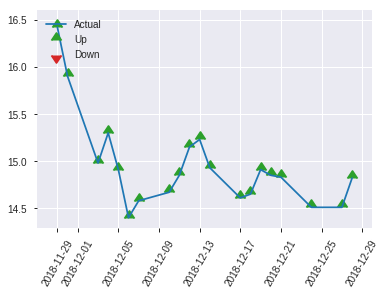


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24670851271067887
RMSE: 0.4966976069105617
LogLoss: 0.6865331963126161
Mean Per-Class Error: 0.4261305894308943
AUC: 0.5703125
pr_auc: 0.5439031677057846
Gini: 0.140625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4395782826202877: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    121  0.9453   (121.0/128.0)
1      1    122  0.0081   (1.0/123.0)
Total  8    243  0.4861   (122.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439578     0.666667  242
max f2                       0.439578     0.829932  242
max f0point5                 0.466238     0.560803  180
max accuracy                 0.52117      0.577689  72
max precision                0.631877     1         0
max recall                   0.437357     1         249
max specificity              0.631877     1         0
max absolute_mcc             0.52117      0.161923  72
max min_per_class_accuracy   0.496041     0.544715  122
max mean_per_class_accuracy  0.519603     0.573869  76

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.605165           1.36043   1.36043            0.666667         0.619784  0.666667                    0.619784            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.587192           1.36043   1.36043            0.666667         0.593863  0.666667                    0.606824            0.0162602       0.0325203                  36.0434   36.0434
    3        0.0318725                   0.583563           1.02033   1.27541            0.5              0.58409   0.625                       0.60114             0.00813008      0.0406504                  2.03252   27.5407
    4        0.0438247                   0.578819           1.36043   1.2986             0.666667         0.581493  0.636364                    0.595782            0.0162602       0.0569106                  36.0434   29.8596
    5        0.0517928                   0.573851           1.02033   1.25578            0.5              0.57569   0.615385                    0.592691            0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.558235           1.09881   1.1773             0.538462         0.565475  0.576923                    0.579083            0.0569106       0.121951                   9.88118   17.7298
    7        0.151394                    0.54931            0.850271  1.07403            0.416667         0.554466  0.526316                    0.571309            0.0406504       0.162602                   -14.9729  7.40265
    8        0.203187                    0.538054           1.41276   1.16037            0.692308         0.543734  0.568627                    0.56428             0.0731707       0.235772                   41.2758   16.037
    9        0.302789                    0.520335           1.38764   1.23513            0.68             0.525165  0.605263                    0.551413            0.138211        0.373984                   38.7642   23.5131
    10       0.40239                     0.506229           0.734634  1.11125            0.36             0.513891  0.544554                    0.542125            0.0731707       0.447154                   -26.5366  11.1245
    11       0.501992                    0.495123           0.979512  1.08511            0.48             0.500348  0.531746                    0.533836            0.097561        0.544715                   -2.04878  8.51078
    12       0.601594                    0.480783           0.979512  1.06763            0.48             0.487028  0.523179                    0.526087            0.097561        0.642276                   -2.04878  6.7625
    13       0.701195                    0.46921            1.06114   1.0667             0.52             0.475213  0.522727                    0.51886             0.105691        0.747967                   6.11382   6.67036
    14       0.800797                    0.455588           0.81626   1.03555            0.4              0.461211  0.507463                    0.51169             0.0813008       0.829268                   -18.374   3.55539
    15       0.900398                    0.446784           0.897886  1.02033            0.44             0.450889  0.5                         0.504964            0.0894309       0.918699                   -10.2114  2.03252
    16       1                           0.436205           0.81626   1                  0.4              0.441639  0.49004                     0.498657           

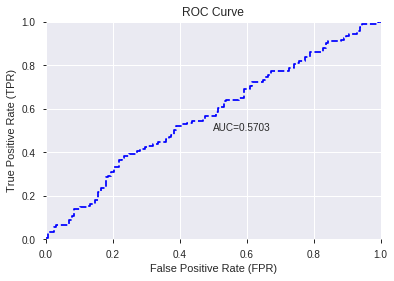

This function is available for GLM models only


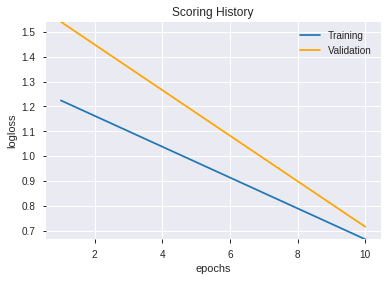

--2019-08-27 17:36:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  48.2MB/s    in 7.8s    

2019-08-27 17:36:37 (45.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_170921',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_170921',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_86f4',


In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_173645  0.580983  0.822346              0.453919  0.534287  0.285462
1  DeepLearning_grid_1_AutoML_20190827_173645_model_6  0.573488  0.689182              0.476562  0.497249  0.247256
2  DeepLearning_grid_1_AutoML_20190827_173645_model_5  0.568471  0.695254              0.476721  0.498265  0.248268
3  DeepLearning_grid_1_AutoML_20190827_173645_model_2  0.567645  0.694194              0.465638  0.500077  0.250077
4  DeepLearning_grid_1_AutoML_20190827_173645_model_4  0.563834  0.709712              0.476562  0.503547  0.253559
5  DeepLearning_grid_1_AutoML_20190827_173645_model_3  0.557736  0.722557              0.500000  0.512034  0.262178
6  DeepLearning_grid_1_AutoML_20190827_173645_model_1  0.548145  0.810483              0.496094  0.533691  0.284826
7  DeepLearning_grid_1_AutoML_20190827_173645_model_7  0.526423  0.716226              0.484375  0.503759  0.253773
8  DeepLearning_grid_1_AutoML_20190827_173645_model_8  0.500000  0.697135              0.500000  0.501985  0.251989

variable  relative_importance  scaled_importance  percentage
0                MACD_signal             1.000000           1.000000    0.028818
1                       TANH             0.966972           0.966972    0.027866
2                   SAR_0.12             0.885702           0.885702    0.025524
3    BBANDS_upperband_14_7_4             0.875904           0.875904    0.025242
4    BBANDS_upperband_30_1_5             0.838453           0.838453    0.024162
5                       CEIL             0.835631           0.835631    0.024081
6          CDL3WHITESOLDIERS             0.818070           0.818070    0.023575
7                MIDPOINT_12             0.789365           0.789365    0.022748
8             is_month_start             0.786253           0.786253    0.022658
9                     CMO_24             0.785249           0.785249    0.022629
10   BBANDS_lowerband_12_7_3             0.784292           0.784292    0.022602
11   BBANDS_upperband_24_1_3             0.778819           0.778819    0.022444
12                   ADXR_12             0.777214           0.777214    0.022398
13                     RSI_8             0.775614           0.775614    0.022352
14        CDLMORNINGDOJISTAR             0.774536           0.774536    0.022321
15   BBANDS_upperband_24_3_4             0.772602           0.772602    0.022265
16             days_in_month             0.764884           0.764884    0.022042
17                   MA_14_5             0.749866           0.749866    0.021610
18                   KAMA_24             0.745561           0.745561    0.021486
19   BBANDS_lowerband_14_1_2             0.742807           0.742807    0.021406
20                    ATR_20             0.721821           0.721821    0.020801
21    LINEARREG_INTERCEPT_12             0.713851           0.713851    0.020572
22   BBANDS_middleband_8_0_4             0.712405           0.712405    0.020530
23                    SMA_20             0.705624           0.705624    0.020335
24   BBANDS_middleband_8_2_5             0.705557           0.705557    0.020333
25                   MA_24_7             0.695466           0.695466    0.020042
26                    MOM_14             0.687665           0.687665    0.019817
27   BBANDS_lowerband_12_1_3             0.679141           0.679141    0.019571
28  BBANDS_middleband_14_3_3             0.674832           0.674832    0.019447
29                 CDLHARAMI             0.674357           0.674357    0.019434
30         MACDFIX_signal_24             0.669675           0.669675    0.019299
31       CDLXSIDEGAP3METHODS             0.659195           0.659195    0.018997
32                    ATR_12             0.651320           0.651320    0.018770
33   BBANDS_middleband_8_2_4             0.637931           0.637931    0.018384
34  BBANDS_middleband_20_6_3             0.636183           0.636183    0.018333
35   BBANDS_upperband_30_0_4             0.633389           0.633389    0.018253
36                 MAVP_14_4             0.615934           0.615934    0.017750
37  BBANDS_middleband_30_0_3             0.601978           0.601978    0.017348
38  BBANDS_middleband_24_1_2             0.600763           0.600763    0.017313
39    BBANDS_lowerband_8_2_4             0.599422           0.599422    0.017274
40   BBANDS_lowerband_14_1_3             0.587244           0.587244    0.016923
41                    BETA_8             0.568449           0.568449    0.016382
42         MACDFIX_signal_14             0.565463           0.565463    0.016295
43  BBANDS_middleband_12_1_2             0.558309           0.558309    0.016089
44   BBANDS_upperband_12_2_5             0.518843           0.518843    0.014952
45                ROCR100_30             0.505692           0.505692    0.014573
46       CDLGAPSIDESIDEWHITE             0.498353           0.498353    0.014361
47   BBANDS_upperband_30_5_5             0.495666           0.495666    0.014284
48               HT_DCPERIOD             0.472752  

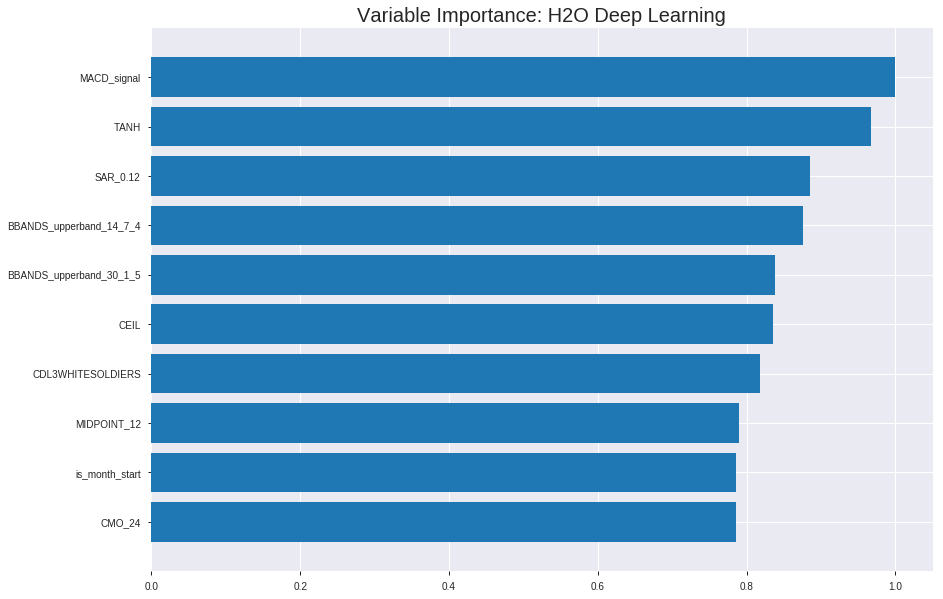

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_173645


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2648697428996804
RMSE: 0.5146549746186083
LogLoss: 0.7357632703593158
Mean Per-Class Error: 0.4548410319966881
AUC: 0.5541410312155826
pr_auc: 0.5521571324896225
Gini: 0.10828206243116512
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.277921754729301: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   841   0.9711   (841.0/866.0)
1      10   877   0.0113   (10.0/887.0)
Total  35   1718  0.4855   (851.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.277922     0.673321   377
max f2                       0.180822     0.837266   395
max f0point5                 0.354243     0.570906   344
max accuracy                 0.547201     0.545921   222
max precision                0.998679     1          0
max recall                   0.180822     1          395
max specificity              0.998679     1          0
max absolute_mcc             0.476524     0.0946338  271
max min_per_class_accuracy   0.571966     0.535513   204
max mean_per_class_accuracy  0.547201     0.545159   222

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 57.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.952955           1.75673   1.75673            0.888889         0.979156  0.888889                    0.979156            0.0180383       0.0180383                  75.6733    75.6733
    2        0.0205362                   0.924125           1.09796   1.42735            0.555556         0.93459   0.722222                    0.956873            0.011274        0.0293123                  9.79582    42.7346
    3        0.0302339                   0.899655           0.697526  1.19325            0.352941         0.912462  0.603774                    0.942628            0.00676437      0.0360767                  -30.2474   19.3253
    4        0.040502                    0.874884           1.20775   1.19693            0.611111         0.885262  0.605634                    0.928084            0.0124014       0.048478                   20.7754    19.6929
    5        0.0501997                   0.863696           1.04629   1.16783            0.529412         0.870402  0.590909                    0.916941            0.0101466       0.0586246                  4.62895    16.7828
    6        0.100399                    0.792967           1.16783   1.16783            0.590909         0.826778  0.590909                    0.87186             0.0586246       0.117249                   16.7828    16.7828
    7        0.150029                    0.749521           1.02224   1.11967            0.517241         0.773006  0.56654                     0.839159            0.0507328       0.167982                   2.22369    11.9667
    8        0.200228                    0.718734           1.01062   1.09233            0.511364         0.732104  0.552707                    0.812319            0.0507328       0.218715                   1.06206    9.23276
    9        0.300057                    0.660084           1.07286   1.08585            0.542857         0.688399  0.54943                     0.771091            0.107103        0.325817                   7.2862     8.58514
    10       0.399886                    0.615484           0.993809  1.06287            0.502857         0.636455  0.537803                    0.73748             0.0992108       0.425028                   -0.619101  6.28736
    11       0.500285                    0.571059           1.10045   1.07042            0.556818         0.590848  0.541619                    0.708053            0.110485        0.535513                   10.0454    7.04153
    12       0.600114                    0.531361           1.06157   1.06894            0.537143         0.551533  0.540875                    0.682016            0.105975        0.641488                   6.15687    6.89437
    13       0.699943                    0.491216           0.971222  1.05501            0.491429         0.511701  0.533822                    0.657725            0.096956        0.738444                   -2.87776   5.50063
    14       0.799772                    0.436873           0.926049  1.03891            0.468571         0.464961  0.525678                    0.633664            0.0924464       0.830891                   -7.39507   3.89096
    15       0.899601                    0.373246           0.903463  1.02388            0.457143         0.406071  0.518072                    0.608408            0.0901917       0.921082                   -9.65373   2.38791
    16       1                           0.0531575          0.786038  1                  0.397727         0.313162  0.50599                     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2699007125398614
RMSE: 0.5195196940827762
LogLoss: 0.7449101120111065
Mean Per-Class Error: 0.45989163789796694
AUC: 0.5284010996036312
pr_auc: 0.5502183182224969
Gini: 0.05680219920726248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1978979045567038: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    234  0.9873   (234.0/237.0)
1      1    263  0.0038   (1.0/264.0)
Total  4    497  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.197898     0.691196   395
max f2                       0.130014     0.848329   398
max f0point5                 0.452604     0.591398   311
max accuracy                 0.465669     0.55489    305
max precision                0.863748     0.8        9
max recall                   0.130014     1          398
max specificity              0.96897      0.995781   0
max absolute_mcc             0.452604     0.0967861  311
max min_per_class_accuracy   0.601106     0.534091   198
max mean_per_class_accuracy  0.465669     0.540108   305

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 58.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.906508           1.26515   1.26515            0.666667         0.929553  0.666667                    0.929553            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.859727           1.51818   1.38017            0.8              0.866077  0.727273                    0.900701            0.0151515       0.030303                   51.8182   38.0165
    3        0.0319361                   0.841462           1.51818   1.4233             0.8              0.847021  0.75                        0.883926            0.0151515       0.0454545                  51.8182   42.3295
    4        0.0419162                   0.832518           1.13864   1.35552            0.6              0.836514  0.714286                    0.872637            0.0113636       0.0568182                  13.8636   35.5519
    5        0.0518962                   0.824587           1.13864   1.31381            0.6              0.825798  0.692308                    0.863629            0.0113636       0.0681818                  13.8636   31.3811
    6        0.101796                    0.790281           0.986818  1.15352            0.52             0.806147  0.607843                    0.835452            0.0492424       0.117424                   -1.31818  15.352
    7        0.151697                    0.756791           0.683182  0.998804           0.36             0.771828  0.526316                    0.814523            0.0340909       0.151515                   -31.6818  -0.119617
    8        0.201597                    0.731424           0.683182  0.92068            0.36             0.744282  0.485149                    0.797137            0.0340909       0.185606                   -31.6818  -7.93204
    9        0.301397                    0.685089           1.17659   1.00542            0.62             0.707805  0.529801                    0.767557            0.117424        0.30303                    17.6591   0.541842
    10       0.401198                    0.64373            1.02477   1.01023            0.54             0.663422  0.532338                    0.741653            0.102273        0.405303                   2.47727   1.02329
    11       0.500998                    0.598229           1.29045   1.06605            0.68             0.621948  0.561753                    0.717807            0.128788        0.534091                   29.0455   6.6054
    12       0.600798                    0.556115           0.948864  1.04659            0.5              0.578053  0.551495                    0.694592            0.094697        0.628788                   -5.11364  4.65871
    13       0.700599                    0.507364           0.948864  1.03267            0.5              0.533358  0.54416                     0.671624            0.094697        0.723485                   -5.11364  3.26664
    14       0.800399                    0.448325           1.10068   1.04115            0.58             0.478714  0.548628                    0.647571            0.109848        0.833333                   10.0682   4.11471
    15       0.9002                      0.35085            0.835     1.01829            0.44             0.402737  0.536585                    0.620427            0.0833333       0.916667                   -16.5     1.82927
    16       1                           0.0984435          0.835     1                  0.44             0.284062  0.526946                    0.586858       


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:36:46  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:36:46  0.086 sec   56548 obs/sec     1         1             1753       0.549619         0.884224            -0.208496      0.523214        0.52753            1.42735          0.49401                          0.551588           0.891815              -0.220541        0.525852          0.546601             1.26515            0.463074
    2019-08-27 17:36:46  0.442 sec   51107 obs/sec     10        10            17530      0.514655         0.735763            -0.059631      0.554141        0.552157           1.75673          0.485454                         0.51952            0.74491               -0.0827476       0.528401          0.550218             1.26515            0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
MACD_signal               1.0                    1.0                  0.02881792125746192
TANH                      0.9669720530509949     0.9669720530509949   0.027866124482989862
SAR_0.12                  0.8857018947601318     0.8857018947601318   0.025524087460782306
BBANDS_upperband_14_7_4   0.8759039044380188     0.8759039044380188   0.025241729747198276
BBANDS_upperband_30_1_5   0.8384533524513245     0.8384533524513245   0.024162482688997237
---                       ---                    ---                  ---
ROCR100_30                0.5056922435760498     0.5056922435760498   0.014572999255883857
CDLGAPSIDESIDEWHITE       0.4983527362346649     0.4983527362346649   0.014361489911251264
BBANDS_upperband_30_5_5   0.4956655204296112     0.4956655204296112   0.014284049937779418
HT_DCPERIOD               0.47275248169898987    0.47275248169898987  0.013623743791871198
BBANDS_middleband_24_7_5  0.40555644035339355    0.40555644035339355  0.011687293563560647


See the whole table with table.as_data_frame()


('accuracy', 0.5776892430278885)

('F1', 0.6704545454545454)

('auc', 0.580983231707317)

('logloss', 0.8223458829126122)

('mean_per_class_error', 0.42581300813008127)

('rmse', 0.5342868447187913)

('mse', 0.28546243243956176)

deeplearning prediction progress: |███████████████████████████████████████| 100%


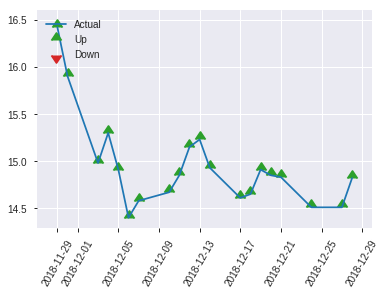


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.28546243243956176
RMSE: 0.5342868447187913
LogLoss: 0.8223458829126122
Mean Per-Class Error: 0.42581300813008127
AUC: 0.580983231707317
pr_auc: 0.5660063038773495
Gini: 0.16196646341463405
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35338564764142444: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   111  0.8672   (111.0/128.0)
1      5    118  0.0407   (5.0/123.0)
Total  22   229  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353386     0.670455  228
max f2                       0.309661     0.828804  243
max f0point5                 0.486497     0.576251  183
max accuracy                 0.85023      0.577689  42
max precision                0.999345     1         0
max recall                   0.257612     1         250
max specificity              0.999345     1         0
max absolute_mcc             0.85023      0.188851  42
max min_per_class_accuracy   0.672482     0.539062  125
max mean_per_class_accuracy  0.772101     0.574187  80

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 64.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.996316           1.36043   1.36043            0.666667         0.998464  0.666667                    0.998464            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.989055           1.36043   1.36043            0.666667         0.991393  0.666667                    0.994929            0.0162602       0.0325203                  36.0434   36.0434
    3        0.0318725                   0.981028           2.04065   1.53049            1                0.983425  0.75                        0.992053            0.0162602       0.0487805                  104.065   53.0488
    4        0.0438247                   0.966954           1.36043   1.48411            0.666667         0.974558  0.727273                    0.987281            0.0162602       0.0650407                  36.0434   48.4109
    5        0.0517928                   0.953226           1.02033   1.41276            0.5              0.958706  0.692308                    0.982885            0.00813008      0.0731707                  2.03252   41.2758
    6        0.103586                    0.901353           1.25578   1.33427            0.615385         0.92666   0.653846                    0.954772            0.0650407       0.138211                   25.5785   33.4271
    7        0.151394                    0.857064           1.53049   1.39623            0.75             0.875917  0.684211                    0.929871            0.0731707       0.211382                   53.0488   39.6234
    8        0.203187                    0.82083            0.941839  1.28041            0.461538         0.842039  0.627451                    0.907482            0.0487805       0.260163                   -5.81614  28.0408
    9        0.302789                    0.778264           1.06114   1.20828            0.52             0.793716  0.592105                    0.870059            0.105691        0.365854                   6.11382   20.828
    10       0.40239                     0.738213           0.571382  1.05063            0.28             0.760306  0.514851                    0.842893            0.0569106       0.422764                   -42.8618  5.06319
    11       0.501992                    0.672482           1.22439   1.08511            0.6              0.701809  0.531746                    0.8149              0.121951        0.544715                   22.439    8.51078
    12       0.601594                    0.577483           0.979512  1.06763            0.48             0.620737  0.523179                    0.782754            0.097561        0.642276                   -2.04878  6.7625
    13       0.701195                    0.505054           1.14276   1.0783             0.56             0.533238  0.528409                    0.747311            0.113821        0.756098                   14.2764   7.82982
    14       0.800797                    0.441536           0.81626   1.04571            0.4              0.473056  0.512438                    0.7132              0.0813008       0.837398                   -18.374   4.57064
    15       0.900398                    0.371297           0.979512  1.03838            0.48             0.411772  0.50885                     0.679856            0.097561        0.934959                   -2.04878  3.83841
    16       1                           0.257612           0.653008  1                  0.32             0.321324  0.49004                     0.644146           

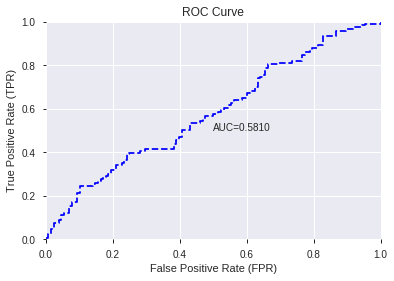

This function is available for GLM models only


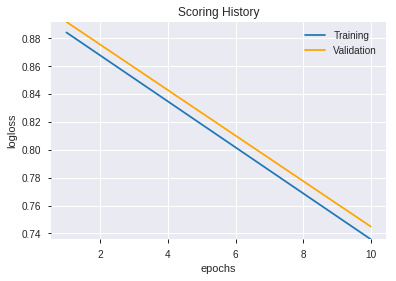

--2019-08-27 17:42:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_173645',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_173645',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_86f4'

['MACD_signal',
 'TANH',
 'SAR_0.12',
 'BBANDS_upperband_14_7_4',
 'BBANDS_upperband_30_1_5',
 'CEIL',
 'CDL3WHITESOLDIERS',
 'MIDPOINT_12',
 'is_month_start',
 'CMO_24',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_24_1_3',
 'ADXR_12',
 'RSI_8',
 'CDLMORNINGDOJISTAR',
 'BBANDS_upperband_24_3_4',
 'days_in_month',
 'MA_14_5',
 'KAMA_24',
 'BBANDS_lowerband_14_1_2',
 'ATR_20',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_middleband_8_0_4',
 'SMA_20',
 'BBANDS_middleband_8_2_5',
 'MA_24_7',
 'MOM_14',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_middleband_14_3_3',
 'CDLHARAMI',
 'MACDFIX_signal_24',
 'CDLXSIDEGAP3METHODS',
 'ATR_12',
 'BBANDS_middleband_8_2_4',
 'BBANDS_middleband_20_6_3',
 'BBANDS_upperband_30_0_4',
 'MAVP_14_4',
 'BBANDS_middleband_30_0_3',
 'BBANDS_middleband_24_1_2',
 'BBANDS_lowerband_8_2_4',
 'BBANDS_lowerband_14_1_3',
 'BETA_8',
 'MACDFIX_signal_14',
 'BBANDS_middleband_12_1_2',
 'BBANDS_upperband_12_2_5',
 'ROCR100_30',
 'CDLGAPSIDESIDEWHITE',
 'BBANDS_upperband_30_5_5',
 'HT_

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_174250_model_1  0.550877  0.689194              0.469226  0.498032  0.248036

variable  relative_importance  scaled_importance  percentage
0                       TANH             0.055575           1.000000    0.114894
1        CDLXSIDEGAP3METHODS             0.035900           0.645978    0.074219
2                      RSI_8             0.035174           0.632913    0.072718
3                HT_DCPERIOD             0.031027           0.558297    0.064145
4                     MOM_14             0.029573           0.532129    0.061139
5                  CDLHARAMI             0.026687           0.480207    0.055173
6        CDLGAPSIDESIDEWHITE             0.024891           0.447888    0.051460
7         CDLMORNINGDOJISTAR             0.024033           0.432451    0.049686
8          MACDFIX_signal_14             0.020285           0.365011    0.041938
9                MACD_signal             0.020081           0.361328    0.041515
10         MACDFIX_signal_24             0.019499           0.350859    0.040312
11                    ATR_12             0.016480           0.296538    0.034071
12                   ADXR_12             0.015415           0.277380    0.031869
13                    ATR_20             0.013025           0.234374    0.026928
14   BBANDS_upperband_30_1_5             0.011914           0.214375    0.024630
15   BBANDS_upperband_30_5_5             0.011771           0.211796    0.024334
16   BBANDS_upperband_30_0_4             0.011473           0.206439    0.023719
17            is_month_start             0.010886           0.195873    0.022505
18   BBANDS_lowerband_12_7_3             0.006134           0.110380    0.012682
19   BBANDS_upperband_12_2_5             0.005211           0.093759    0.010772
20   BBANDS_lowerband_12_1_3             0.005007           0.090098    0.010352
21   BBANDS_upperband_24_1_3             0.004223           0.075994    0.008731
22   BBANDS_upperband_24_3_4             0.003583           0.064467    0.007407
23                    CMO_24             0.003249           0.058468    0.006718
24               MIDPOINT_12             0.003240           0.058308    0.006699
25    BBANDS_lowerband_8_2_4             0.003143           0.056558    0.006498
26   BBANDS_lowerband_14_1_3             0.003086           0.055531    0.006380
27    LINEARREG_INTERCEPT_12             0.003076           0.055342    0.006358
28                   KAMA_24             0.002945           0.052999    0.006089
29  BBANDS_middleband_30_0_3             0.002867           0.051587    0.005927
30   BBANDS_lowerband_14_1_2             0.002384           0.042905    0.004930
31                      CEIL             0.002215           0.039861    0.004580
32                ROCR100_30             0.002197           0.039530    0.004542
33  BBANDS_middleband_14_3_3             0.001515           0.027267    0.003133
34             days_in_month             0.001497           0.026938    0.003095
35                 MAVP_14_4             0.001469           0.026438    0.003038
36                   MA_24_7             0.001407           0.025310    0.002908
37  BBANDS_middleband_24_7_5             0.001372           0.024693    0.002837
38                    SMA_20             0.001371           0.024665    0.002834
39   BBANDS_upperband_14_7_4             0.001165           0.020968    0.002409
40  BBANDS_middleband_20_6_3             0.001139           0.020488    0.002354
41         CDL3WHITESOLDIERS             0.001133           0.020384    0.002342
42  BBANDS_middleband_12_1_2             0.001111           0.019983    0.002296
43   BBANDS_middleband_8_2_5             0.001000           0.017989    0.002067
44                   MA_14_5             0.000793           0.014265    0.001639
45                    BETA_8             0.000728           0.013104    0.001506
46   BBANDS_middleband_8_2_4             0.000719           0.012931    0.001486
47  BBANDS_middleband_24_1_2             0.000589           0.010590    0.001217
48                  SAR_0.12             0.000340  

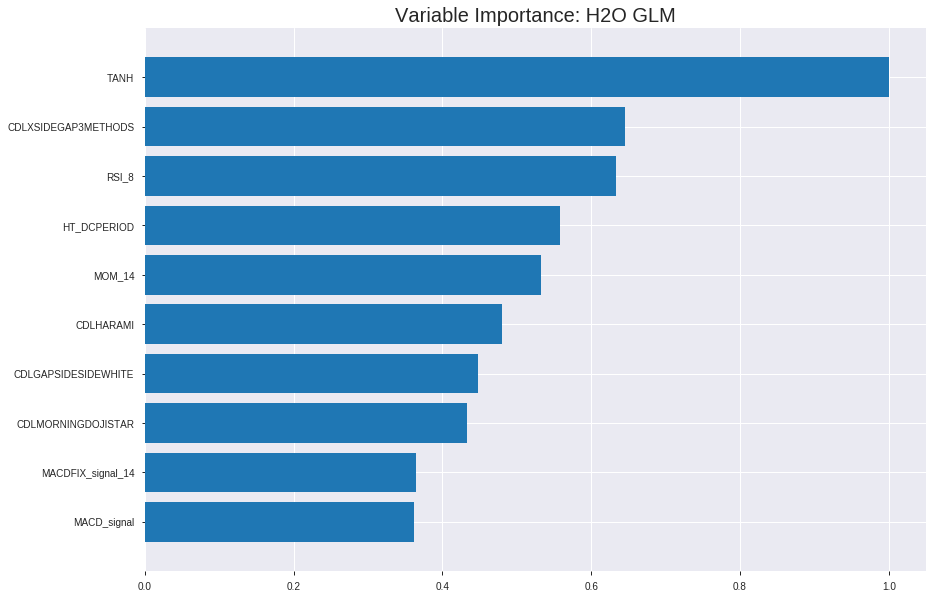

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_174250_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2477823703628531
RMSE: 0.49777743054788365
LogLoss: 0.6886169931989989
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.9224402865125
Residual deviance: 2414.2911781556904
AIC: 2516.2911781556904
AUC: 0.5525879329603121
pr_auc: 0.5618701727826398
Gini: 0.10517586592062411
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4600927293179013: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   848   0.9792   (848.0/866.0)
1      5    882   0.0056   (5.0/887.0)
Total  23   1730  0.4866   (853.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.460093     0.674054   379
max f2                       0.410281     0.83695    397
max f0point5                 0.464739     0.565503   372
max accuracy                 0.498519     0.540787   241
max precision                0.775109     1          0
max recall                   0.410281     1          397
max specificity              0.775109     1          0
max absolute_mcc             0.527087     0.0903443  95
max min_per_class_accuracy   0.504677     0.535797   206
max mean_per_class_accuracy  0.510942     0.541805   171

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.585386           1.64694   1.64694            0.833333         0.642787  0.833333                    0.642787            0.0169109       0.0169109                  64.6937   64.6937
    2        0.0205362                   0.553562           1.20775   1.42735            0.611111         0.563873  0.722222                    0.60333             0.0124014       0.0293123                  20.7754   42.7346
    3        0.0302339                   0.54697            1.16254   1.34241            0.588235         0.549342  0.679245                    0.586013            0.011274        0.0405862                  16.2544   34.2409
    4        0.040502                    0.544211           1.09796   1.28044            0.555556         0.545477  0.647887                    0.575736            0.011274        0.0518602                  9.79582   28.0436
    5        0.0501997                   0.54036            0.813781  1.19029            0.411765         0.542315  0.602273                    0.56928             0.00789177      0.059752                   -18.6219  19.0286
    6        0.100399                    0.530638           1.25766   1.22397            0.636364         0.534659  0.619318                    0.551969            0.0631342       0.122886                   25.7661   22.3974
    7        0.150029                    0.525077           1.06767   1.17227            0.54023          0.527515  0.593156                    0.54388             0.0529876       0.175874                   6.76697   17.2269
    8        0.200228                    0.520685           1.01062   1.13174            0.511364         0.52274   0.57265                     0.53858             0.0507328       0.226607                   1.06206   13.1741
    9        0.300057                    0.51469            1.0051    1.08961            0.508571         0.517688  0.551331                    0.531629            0.100338        0.326945                   0.510227  8.96087
    10       0.399886                    0.509275           1.09545   1.09107            0.554286         0.512002  0.552068                    0.526729            0.109357        0.436302                   9.54485   9.10666
    11       0.500285                    0.504683           0.988162  1.07042            0.5              0.50707   0.541619                    0.522784            0.0992108       0.535513                   -1.18377  7.04153
    12       0.600114                    0.49985            1.0051    1.05955            0.508571         0.502319  0.536122                    0.51938             0.100338        0.635851                   0.510227  5.95505
    13       0.699943                    0.495127           0.914756  1.0389             0.462857         0.497578  0.525672                    0.51627             0.0913191       0.72717                    -8.5244   3.88993
    14       0.799772                    0.489075           0.926049  1.02481            0.468571         0.492094  0.518545                    0.513253            0.0924464       0.819617                   -7.39507  2.48132
    15       0.899601                    0.480982           0.948636  1.01636            0.48             0.485257  0.514268                    0.510146            0.0947012       0.914318                   -5.13641  1.63597
    16       1                           0.272841           0.853413  1                  0.431818         0.46875   0.50599                     0.50599          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24898730759376658
RMSE: 0.49898627996545813
LogLoss: 0.6911235322727303
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.9584553730234
Residual deviance: 692.5057793372758
AIC: 794.5057793372758
AUC: 0.5512482419127989
pr_auc: 0.5592592089228877
Gini: 0.10249648382559773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.467483666722413: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    234  0.9873   (234.0/237.0)
1      1    263  0.0038   (1.0/264.0)
Total  4    497  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467484     0.691196  395
max f2                       0.42581      0.848329  398
max f0point5                 0.488474     0.589674  312
max accuracy                 0.488474     0.552894  312
max precision                0.603417     1         0
max recall                   0.42581      1         398
max specificity              0.603417     1         0
max absolute_mcc             0.512071     0.101807  108
max min_per_class_accuracy   0.501024     0.527426  206
max mean_per_class_accuracy  0.508293     0.546581  135

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.540441           0.632576  0.632576           0.333333         0.567438  0.333333                    0.567438            0.00757576      0.00757576                 -36.7424  -36.7424
    2        0.0219561                   0.534314           1.13864   0.862603           0.6              0.536793  0.454545                    0.553508            0.0113636       0.0189394                  13.8636   -13.7397
    3        0.0319361                   0.532508           0.759091  0.830256           0.4              0.53329   0.4375                      0.54719             0.00757576      0.0265152                  -24.0909  -16.9744
    4        0.0419162                   0.530058           1.51818   0.994048           0.8              0.530936  0.52381                     0.54332             0.0151515       0.0416667                  51.8182   -0.595238
    5        0.0518962                   0.527309           1.13864   1.02185            0.6              0.528262  0.538462                    0.540424            0.0113636       0.0530303                  13.8636   2.18531
    6        0.101796                    0.520718           1.29045   1.15352            0.68             0.523561  0.607843                    0.532158            0.0643939       0.117424                   29.0455   15.352
    7        0.151697                    0.517818           1.06273   1.12365            0.56             0.519029  0.592105                    0.527839            0.0530303       0.170455                   6.27273   12.3654
    8        0.201597                    0.515153           1.21455   1.14615            0.64             0.516584  0.60396                     0.525053            0.0606061       0.231061                   21.4545   14.6152
    9        0.301397                    0.509626           1.06273   1.11853            0.56             0.512018  0.589404                    0.520737            0.106061        0.337121                   6.27273   11.8528
    10       0.401198                    0.505648           0.986818  1.08576            0.52             0.507391  0.572139                    0.517417            0.0984848       0.435606                   -1.31818  8.57644
    11       0.500998                    0.501068           0.910909  1.05093            0.48             0.503424  0.553785                    0.514629            0.0909091       0.526515                   -8.90909  5.09326
    12       0.600798                    0.496529           1.06273   1.05289            0.56             0.498579  0.554817                    0.511963            0.106061        0.632576                   6.27273   5.28919
    13       0.700599                    0.49201            1.02477   1.04889            0.54             0.494258  0.552707                    0.509441            0.102273        0.734848                   2.47727   4.88863
    14       0.800399                    0.487793           0.948864  1.03641            0.5              0.489949  0.546135                    0.507011            0.094697        0.829545                   -5.11364  3.64146
    15       0.9002                      0.482306           0.872955  1.01829            0.46             0.485345  0.536585                    0.504609            0.0871212       0.916667                   -12.7045  1.82927
    16       1                           0.41548            0.835     1                  0.44             0.474283  0.526946                    0.501582     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:42:51  0.000 sec   2            2.8       51            1.38432           1.3841
    2019-08-27 17:42:51  0.081 sec   4            1.8       51            1.38343           1.38372
    2019-08-27 17:42:51  0.168 sec   6            1.1       51            1.38222           1.38325
    2019-08-27 17:42:51  0.248 sec   8            0.68      51            1.38071           1.38276
    2019-08-27 17:42:51  0.329 sec   10           0.42      51            1.37899           1.38238
    2019-08-27 17:42:51  0.409 sec   12           0.26      51            1.37723           1.38225
    2019-08-27 17:42:51  0.443 sec   14           0.16      51            1.37561           1.38247
    2019-08-27 17:42:51  0.476 sec   16           0.1       51            1.37423           1.38308
    2019-08-27 17:42:51  0.509 sec   18           0.063     51            1.37311           1.38401
    2019-08-27 17:42:51  0.539 sec   20           0.039     51            1.37222           1.38512
    2019-08-27 17:42:51  0.567 sec   22           0.024     51            1.37145           1.3863

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.6666666666666667)

('auc', 0.5508765243902439)

('logloss', 0.6891944742662892)

('mean_per_class_error', 0.44007240853658536)

('rmse', 0.49803164843123804)

('mse', 0.2480355228391363)

glm prediction progress: |████████████████████████████████████████████████| 100%


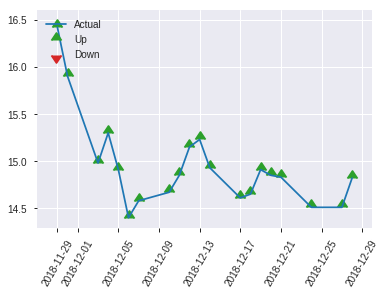


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2480355228391363
RMSE: 0.49803164843123804
LogLoss: 0.6891944742662892
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.11570799031966
Residual deviance: 345.9756260816772
AIC: 447.9756260816772
AUC: 0.5508765243902439
pr_auc: 0.5452127132885357
Gini: 0.10175304878048785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4856208256105975: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   117  0.9141   (117.0/128.0)
1      3    120  0.0244   (3.0/123.0)
Total  14   237  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485621     0.666667  236
max f2                       0.471609     0.828841  249
max f0point5                 0.485621     0.560224  236
max accuracy                 0.518454     0.565737  51
max precision                0.735783     1         0
max recall                   0.471609     1         249
max specificity              0.735783     1         0
max absolute_mcc             0.518454     0.147838  51
max min_per_class_accuracy   0.504485     0.512195  124
max mean_per_class_accuracy  0.518454     0.559928  51

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.674225           1.36043   1.36043            0.666667         0.712376  0.666667                    0.712376            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.630332           1.36043   1.36043            0.666667         0.642823  0.666667                    0.6776              0.0162602       0.0325203                  36.0434   36.0434
    3        0.0318725                   0.598997           1.02033   1.27541            0.5              0.610154  0.625                       0.660738            0.00813008      0.0406504                  2.03252   27.5407
    4        0.0438247                   0.569028           1.36043   1.2986             0.666667         0.579657  0.636364                    0.638625            0.0162602       0.0569106                  36.0434   29.8596
    5        0.0517928                   0.557837           1.02033   1.25578            0.5              0.56466   0.615385                    0.627246            0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.529122           1.56973   1.41276            0.769231         0.538138  0.692308                    0.582692            0.0813008       0.146341                   56.9731   41.2758
    7        0.151394                    0.52178            0.680217  1.18143            0.333333         0.525285  0.578947                    0.564564            0.0325203       0.178862                   -31.9783  18.1429
    8        0.203187                    0.51847            1.56973   1.28041            0.769231         0.52019   0.627451                    0.553253            0.0813008       0.260163                   56.9731   28.0408
    9        0.302789                    0.512913           0.653008  1.07403            0.32             0.516073  0.526316                    0.541022            0.0650407       0.325203                   -34.6992  7.40265
    10       0.40239                     0.508746           1.14276   1.09104            0.56             0.510469  0.534653                    0.53346             0.113821        0.439024                   14.2764   9.10408
    11       0.501992                    0.504282           0.734634  1.02033            0.36             0.506312  0.5                         0.528073            0.0731707       0.512195                   -26.5366  2.03252
    12       0.601594                    0.500288           1.06114   1.02708            0.52             0.502207  0.503311                    0.523791            0.105691        0.617886                   6.11382   2.70823
    13       0.701195                    0.496201           0.979512  1.02033            0.48             0.498397  0.5                         0.520184            0.097561        0.715447                   -2.04878  2.03252
    14       0.800797                    0.491702           1.06114   1.0254             0.52             0.493997  0.502488                    0.516927            0.105691        0.821138                   6.11382   2.54014
    15       0.900398                    0.487143           0.979512  1.02033            0.48             0.489377  0.5                         0.513879            0.097561        0.918699                   -2.04878  2.03252
    16       1                           0.462947           0.81626   1                  0.4              0.482547  0.49004                     0.510758         

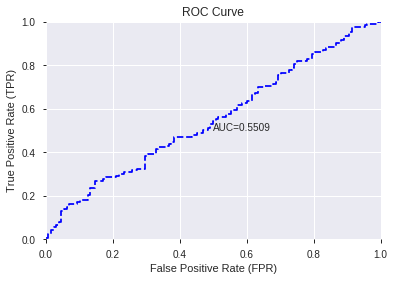

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


'log_likelihood'
--2019-08-27 17:42:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_174250_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_174250_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['TANH',
 'CDLXSIDEGAP3METHODS',
 'RSI_8',
 'HT_DCPERIOD',
 'MOM_14',
 'CDLHARAMI',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'MACDFIX_signal_14',
 'MACD_signal',
 'MACDFIX_signal_24',
 'ATR_12',
 'ADXR_12',
 'ATR_20',
 'BBANDS_upperband_30_1_5',
 'BBANDS_upperband_30_5_5',
 'BBANDS_upperband_30_0_4',
 'is_month_start',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_12_2_5',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_24_1_3',
 'BBANDS_upperband_24_3_4',
 'CMO_24',
 'MIDPOINT_12',
 'BBANDS_lowerband_8_2_4',
 'BBANDS_lowerband_14_1_3',
 'LINEARREG_INTERCEPT_12',
 'KAMA_24',
 'BBANDS_middleband_30_0_3',
 'BBANDS_lowerband_14_1_2',
 'CEIL',
 'ROCR100_30',
 'BBANDS_middleband_14_3_3',
 'days_in_month',
 'MAVP_14_4',
 'MA_24_7',
 'BBANDS_middleband_24_7_5',
 'SMA_20',
 'BBANDS_upperband_14_7_4',
 'BBANDS_middleband_20_6_3',
 'CDL3WHITESOLDIERS',
 'BBANDS_middleband_12_1_2',
 'BBANDS_middleband_8_2_5',
 'MA_14_5',
 'BETA_8',
 'BBANDS_middleband_8_2_4',
 'BBANDS_middleband_24_1_2',
 

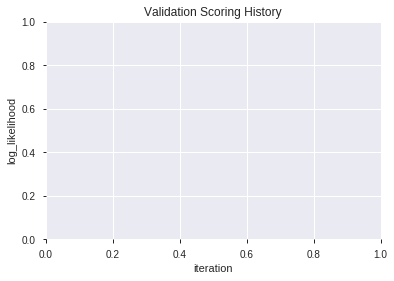

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_174304  0.593972  0.679100              0.435340  0.493118  0.243166
1  XGBoost_grid_1_AutoML_20190827_174304_model_3  0.592353  0.682520              0.465796  0.494736  0.244764
2  XGBoost_grid_1_AutoML_20190827_174304_model_1  0.573171  0.685941              0.480628  0.496329  0.246342
3  XGBoost_grid_1_AutoML_20190827_174304_model_6  0.567804  0.689745              0.484693  0.498289  0.248292
4               XGBoost_1_AutoML_20190827_174304  0.565676  0.694581              0.420351  0.500361  0.250361
5  XGBoost_grid_1_AutoML_20190827_174304_model_2  0.562246  0.688658              0.492346  0.497758  0.247763
6  XGBoost_grid_1_AutoML_20190827_174304_model_7  0.552210  0.709138              0.496094  0.507006  0.257055
7  XGBoost_grid_1_AutoML_20190827_174304_model_4  0.544938  0.692181              0.496094  0.499497  0.249498
8  XGBoost_grid_1_AutoML_20190827_174304_model_5  0.544144  0.723896              0.450807  0.513688  0.263875
9               XGBoost_2_AutoML_20190827_174304  0.523692  0.704503              0.484375  0.505239  0.255266

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD           291.545715           1.000000    0.089353
1                     CMO_24           285.501526           0.979268    0.087501
2                 ROCR100_30           234.310684           0.803684    0.071812
3                      RSI_8           233.334198           0.800335    0.071512
4                     BETA_8           223.919006           0.768041    0.068627
5                    ADXR_12           202.685043           0.695208    0.062119
6                     MOM_14           164.640533           0.564716    0.050459
7          MACDFIX_signal_24           151.197220           0.518606    0.046339
8                     ATR_12           150.654800           0.516745    0.046173
9                     ATR_20           121.552505           0.416924    0.037253
10         MACDFIX_signal_14            81.890549           0.280884    0.025098
11   BBANDS_upperband_12_2_5            80.803955           0.277157    0.024765
12                 MAVP_14_4            78.394051           0.268891    0.024026
13               MACD_signal            77.851006           0.267028    0.023860
14  BBANDS_middleband_14_3_3            67.887199           0.232853    0.020806
15   BBANDS_lowerband_14_1_3            64.456764           0.221086    0.019755
16   BBANDS_upperband_30_0_4            59.751816           0.204948    0.018313
17   BBANDS_lowerband_12_7_3            51.288330           0.175919    0.015719
18   BBANDS_upperband_24_1_3            50.824989           0.174329    0.015577
19                  SAR_0.12            49.491039           0.169754    0.015168
20    LINEARREG_INTERCEPT_12            44.938095           0.154137    0.013773
21   BBANDS_upperband_14_7_4            41.327267           0.141752    0.012666
22   BBANDS_upperband_24_3_4            38.067688           0.130572    0.011667
23   BBANDS_middleband_8_2_4            37.604279           0.128982    0.011525
24   BBANDS_lowerband_14_1_2            34.901184           0.119711    0.010697
25                      TANH            33.621693           0.115322    0.010304
26                   MA_24_7            31.711302           0.108770    0.009719
27   BBANDS_middleband_8_0_4            31.596893           0.108377    0.009684
28   BBANDS_lowerband_12_1_3            28.807354           0.098809    0.008829
29    BBANDS_lowerband_8_2_4            28.419250           0.097478    0.008710
30               MIDPOINT_12            24.143806           0.082813    0.007400
31   BBANDS_upperband_30_5_5            23.270292           0.079817    0.007132
32  BBANDS_middleband_30_0_3            22.722084           0.077937    0.006964
33             days_in_month            21.780025           0.074705    0.006675
34  BBANDS_middleband_12_1_2            17.464725           0.059904    0.005353
35                   MA_14_5            17.165361           0.058877    0.005261
36                    SMA_20            16.007792           0.054907    0.004906
37                 CDLHARAMI            15.383673           0.052766    0.004715
38   BBANDS_upperband_30_1_5            12.579035           0.043146    0.003855
39  BBANDS_middleband_20_6_3            10.796947           0.037033    0.003309
40   BBANDS_middleband_8_2_5             6.362806           0.021824    0.001950
41  BBANDS_middleband_24_1_2             2.198406           0.007541    0.000674

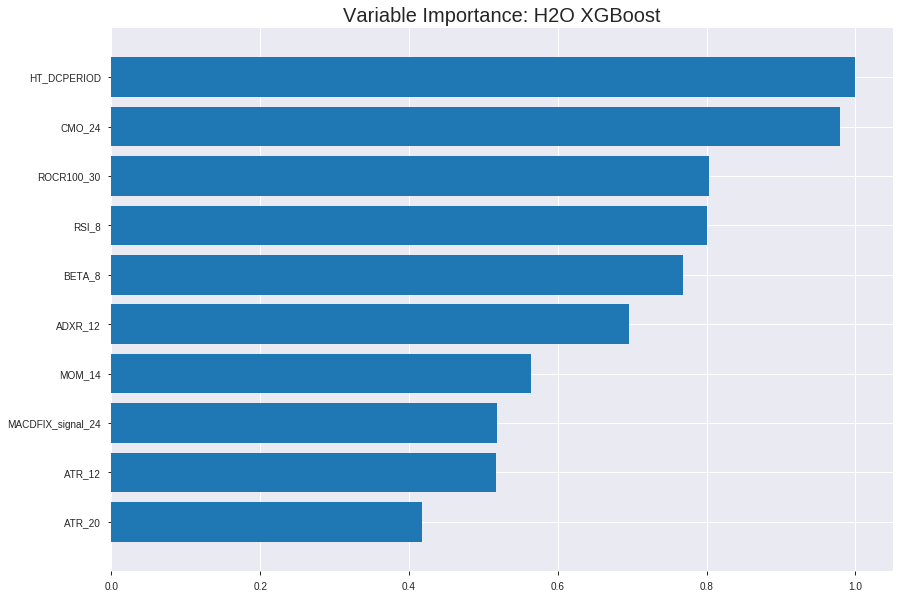

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_174304


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2079515116329804
RMSE: 0.4560170080523098
LogLoss: 0.6072539796237223
Mean Per-Class Error: 0.21753334669891766
AUC: 0.8606963295848945
pr_auc: 0.8555492684987969
Gini: 0.721392659169789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4904032399257024: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      594  272   0.3141   (272.0/866.0)
1      128  759   0.1443   (128.0/887.0)
Total  722  1031  0.2282   (400.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490403     0.791449  224
max f2                       0.441846     0.873914  287
max f0point5                 0.529957     0.798563  168
max accuracy                 0.512466     0.782088  192
max precision                0.767371     1         0
max recall                   0.358684     1         364
max specificity              0.767371     1         0
max absolute_mcc             0.512466     0.565796  192
max min_per_class_accuracy   0.506333     0.771139  200
max mean_per_class_accuracy  0.512466     0.782467  192

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.726544           1.86653    1.86653            0.944444         0.747583  0.944444                    0.747583            0.0191657       0.0191657                  86.6529   86.6529
    2        0.0205362                   0.690012           1.97632    1.92143            1                0.705729  0.972222                    0.726656            0.0202931       0.0394589                  97.6325   92.1427
    3        0.0302339                   0.657489           1.97632    1.93904            1                0.670408  0.981132                    0.708614            0.0191657       0.0586246                  97.6325   93.9036
    4        0.040502                    0.645661           1.75673    1.89282            0.888889         0.651445  0.957746                    0.69412             0.0180383       0.0766629                  75.6733   89.2818
    5        0.0501997                   0.634779           1.97632    1.90895            1                0.638618  0.965909                    0.683398            0.0191657       0.0958286                  97.6325   90.895
    6        0.100399                    0.602254           1.88649    1.89772            0.954545         0.618498  0.960227                    0.650948            0.0947012       0.19053                    88.6492   89.7721
    7        0.150029                    0.585505           1.74916    1.84858            0.885057         0.593115  0.935361                    0.631817            0.0868095       0.277339                   74.9161   84.8577
    8        0.200228                    0.571607           1.68437    1.80741            0.852273         0.577874  0.91453                     0.618293            0.0845547       0.361894                   68.4368   80.7408
    9        0.300057                    0.547808           1.62623    1.74713            0.822857         0.558253  0.88403                     0.598318            0.162345        0.524239                   62.6233   74.7131
    10       0.399886                    0.526708           1.38907    1.65774            0.702857         0.53766   0.838802                    0.583175            0.13867         0.662909                   38.9074   65.7745
    11       0.500285                    0.506234           1.078      1.5414             0.545455         0.516453  0.779932                    0.569785            0.10823         0.771139                   7.79953   54.1398
    12       0.600114                    0.487965           0.903463   1.43528            0.457143         0.497569  0.726236                    0.557772            0.0901917       0.86133                    -9.65373  43.5278
    13       0.699943                    0.467969           0.677597   1.32721            0.342857         0.477554  0.671557                    0.546331            0.0676437       0.928974                   -32.2403  32.7214
    14       0.799772                    0.441033           0.463025   1.21934            0.234286         0.455417  0.616976                    0.534983            0.0462232       0.975197                   -53.6975  21.9344
    15       0.899601                    0.401827           0.180693   1.10409            0.0914286        0.423597  0.558656                    0.522622            0.0180383       0.993236                   -81.9307  10.4085
    16       1                           0.24972            0.0673747  1                  0.0340909        0.357664  0.50599                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2516079369956282
RMSE: 0.501605359815491
LogLoss: 0.6964203506697352
Mean Per-Class Error: 0.4684503260452627
AUC: 0.5046269658611431
pr_auc: 0.5439801958695958
Gini: 0.009253931722286168
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2975064218044281: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    234  0.9873   (234.0/237.0)
1      1    263  0.0038   (1.0/264.0)
Total  4    497  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.297506     0.691196   395
max f2                       0.280344     0.847784   399
max f0point5                 0.416867     0.586977   363
max accuracy                 0.416867     0.540918   363
max precision                0.623127     0.888889   7
max recall                   0.280344     1          399
max specificity              0.69548      0.995781   0
max absolute_mcc             0.623127     0.0980483  7
max min_per_class_accuracy   0.503006     0.503788   197
max mean_per_class_accuracy  0.519563     0.53155    146

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.667033           1.58144   1.58144            0.833333         0.679929  0.833333                    0.679929            0.0189394       0.0189394                  58.1439   58.1439
    2        0.0219561                   0.613605           1.13864   1.38017            0.6              0.62759   0.727273                    0.656139            0.0113636       0.030303                   13.8636   38.0165
    3        0.0319361                   0.597738           0.759091  1.18608            0.4              0.6054    0.625                       0.640283            0.00757576      0.0378788                  -24.0909  18.608
    4        0.0439122                   0.589564           1.26515   1.20764            0.666667         0.592022  0.636364                    0.627121            0.0151515       0.0530303                  26.5152   20.7645
    5        0.0518962                   0.585786           0.948864  1.16783            0.5              0.587039  0.615385                    0.620954            0.00757576      0.0606061                  -5.11364  16.7832
    6        0.101796                    0.561094           0.986818  1.0791             0.52             0.571459  0.568627                    0.596692            0.0492424       0.109848                   -1.31818  7.90998
    7        0.151697                    0.549798           0.531364  0.898923           0.28             0.554768  0.473684                    0.582901            0.0265152       0.136364                   -46.8636  -10.1077
    8        0.201597                    0.5419             1.44227   1.03342            0.76             0.545964  0.544554                    0.573759            0.0719697       0.208333                   44.2273   3.34158
    9        0.301397                    0.526965           1.02477   1.03055            0.54             0.533242  0.543046                    0.560342            0.102273        0.310606                   2.47727   3.05539
    10       0.401198                    0.516878           1.10068   1.048              0.58             0.522224  0.552239                    0.55086             0.109848        0.420455                   10.0682   4.79986
    11       0.500998                    0.502135           0.835     1.00557            0.44             0.509332  0.52988                     0.542588            0.0833333       0.503788                   -16.5     0.556863
    12       0.602794                    0.488988           0.744207  0.961431           0.392157         0.495043  0.506623                    0.534559            0.0757576       0.579545                   -25.5793  -3.85686
    13       0.700599                    0.477333           1.04569   0.973193           0.55102          0.483111  0.512821                    0.527377            0.102273        0.681818                   4.56865   -2.68065
    14       0.800399                    0.45994            1.21455   1.00329            0.64             0.468656  0.528678                    0.520055            0.121212        0.80303                    21.4545   0.328724
    15       0.9002                      0.427328           1.06273   1.00988            0.56             0.446719  0.532151                    0.511924            0.106061        0.909091                   6.27273   0.987704
    16       1                           0.280344           0.910909  1                  0.48             0.385148  0.526946                    0.499272    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:43:08  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.49401                          0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 17:43:08  0.120 sec   5                  0.495169         0.683516            0.68561         0.68184            1.97632          0.401027                         0.499692           0.692532              0.525572          0.569822             1.35552            0.469062
    2019-08-27 17:43:08  0.194 sec   10                 0.490918         0.675083            0.716728        0.714668           1.97632          0.374786                         0.499206           0.691556              0.535386          0.575245             1.26515            0.469062
    2019-08-27 17:43:08  0.274 sec   15                 0.48662          0.666586            0.754546        0.755245           1.97632          0.339418                         0.49979            0.692724              0.51281           0.553521             1.58144            0.467066
    2019-08-27 17:43:08  0.351 sec   20                 0.481167         0.655906            0.78415         0.781919           1.86653          0.314318                         0.500248           0.693639              0.498026          0.551766             1.58144            0.471058
    2019-08-27 17:43:09  0.492 sec   25                 0.476148         0.646117            0.807312        0.803193           1.86653          0.284084                         0.499967           0.693071              0.505298          0.552304             1.58144            0.467066
    2019-08-27 17:43:09  0.610 sec   30                 0.47149          0.637085            0.823254        0.818987           1.86653          0.268112                         0.500223           0.693571              0.500224          0.557263             1.58144            0.467066
    2019-08-27 17:43:09  0.757 sec   35                 0.466798         0.628016            0.836992        0.834469           1.97632          0.245864                         0.500221           0.69361               0.514624          0.557591             1.58144            0.46507
    2019-08-27 17:43:09  0.893 sec   40                 0.463103         0.620921            0.847435        0.844509           1.97632          0.25328                          0.500834           0.694872              0.517805          0.555704             1.58144            0.469062
    2019-08-27 17:43:09  1.009 sec   45                 0.459458         0.613893            0.857483        0.850396           1.86653          0.233885                         0.50106            0.695335              0.511364          0.54793              1.58144            0.473054
    2019-08-27 17:43:09  1.099 sec   50                 0.456017         0.607254            0.860696        0.855549           1.86653          0.22818                          0.501605           0.69642               0.504627          0.54398              1.58144            0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
HT_DCPERIOD               291.54571533203125     1.0                   0.08935306124362416
CMO_24                    285.50152587890625     0.9792684675669423    0.08750063535645898
ROCR100_30                234.31068420410156     0.8036841973041974    0.07181164330225487
RSI_8                     233.33419799804688     0.8003348556582651    0.07151236937304006
BETA_8                    223.91900634765625     0.7680408065426128    0.06862679722460457
---                       ---                    ---                   ---
CDLHARAMI                 15.383672714233398     0.05276590224182671   0.0047147948945890274
BBANDS_upperband_30_1_5   12.579034805297852     0.04314601156450551   0.003855228213741377
BBANDS_middleband_20_6_3  10.796947479248047     0.03703346306067911   0.0033090532929243538
BBANDS_middleband_8_2_5   6.36280632019043       0.021824386316032982  0.001950075727101008
BBANDS_middleband_24_1_2  2.198406219482422      0.007540519732827264  0.000673768521496071


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6686567164179104)

('auc', 0.5939723069105691)

('logloss', 0.6791002390311248)

('mean_per_class_error', 0.41250635162601623)

('rmse', 0.4931182693872922)

('mse', 0.2431656276035181)

xgboost prediction progress: |████████████████████████████████████████████| 100%


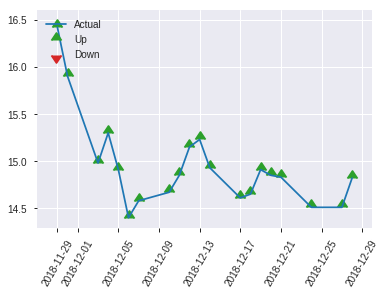


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2431656276035181
RMSE: 0.4931182693872922
LogLoss: 0.6791002390311248
Mean Per-Class Error: 0.41250635162601623
AUC: 0.5939723069105691
pr_auc: 0.59368406093079
Gini: 0.18794461382113825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4242410361766815: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      28   100  0.7812   (100.0/128.0)
1      11   112  0.0894   (11.0/123.0)
Total  39   212  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424241     0.668657  207
max f2                       0.312065     0.828841  245
max f0point5                 0.424241     0.576725  207
max accuracy                 0.539424     0.589641  94
max precision                0.734672     1         0
max recall                   0.312065     1         245
max specificity              0.734672     1         0
max absolute_mcc             0.65049      0.18994   13
max min_per_class_accuracy   0.520842     0.569106  120
max mean_per_class_accuracy  0.539424     0.587494  94

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.720978           2.04065   2.04065            1                0.72966   1                           0.72966             0.0243902       0.0243902                  104.065   104.065
    2        0.0239044                   0.713532           1.36043   1.70054            0.666667         0.717988  0.833333                    0.723824            0.0162602       0.0406504                  36.0434   70.0542
    3        0.0318725                   0.687485           2.04065   1.78557            1                0.690954  0.875                       0.715606            0.0162602       0.0569106                  104.065   78.5569
    4        0.0438247                   0.657995           1.36043   1.66962            0.666667         0.67698   0.818182                    0.705072            0.0162602       0.0731707                  36.0434   66.9623
    5        0.0517928                   0.652621           2.04065   1.7267             1                0.655672  0.846154                    0.697472            0.0162602       0.0894309                  104.065   72.6704
    6        0.103586                    0.600967           0.941839  1.33427            0.461538         0.620422  0.653846                    0.658947            0.0487805       0.138211                   -5.81614  33.4271
    7        0.151394                    0.586902           1.36043   1.34253            0.666667         0.594741  0.657895                    0.638671            0.0650407       0.203252                   36.0434   34.2533
    8        0.203187                    0.577352           0.941839  1.2404             0.461538         0.581624  0.607843                    0.62413             0.0487805       0.252033                   -5.81614  24.0395
    9        0.302789                    0.555697           1.30602   1.26198            0.64             0.564979  0.618421                    0.604672            0.130081        0.382114                   30.6016   26.1981
    10       0.40239                     0.537816           0.979512  1.19206            0.48             0.547212  0.584158                    0.59045             0.097561        0.479675                   -2.04878  19.2063
    11       0.501992                    0.520486           0.897886  1.13369            0.44             0.52624   0.555556                    0.57771             0.0894309       0.569106                   -10.2114  13.3695
    12       0.601594                    0.498545           0.979512  1.10817            0.48             0.507445  0.543046                    0.566076            0.097561        0.666667                   -2.04878  10.8168
    13       0.701195                    0.467445           0.734634  1.05511            0.36             0.483789  0.517045                    0.554388            0.0731707       0.739837                   -26.5366  5.5109
    14       0.800797                    0.439655           0.979512  1.04571            0.48             0.451138  0.512438                    0.541546            0.097561        0.837398                   -2.04878  4.57064
    15       0.900398                    0.408983           1.06114   1.04741            0.52             0.422     0.513274                    0.528322            0.105691        0.943089                   6.11382   4.74135
    16       1                           0.311316           0.571382  1                  0.28             0.37018   0.49004                     0.51257           

This function is available for GLM models only


--2019-08-27 17:43:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_174304',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_174304',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_86f4',
   'type

['HT_DCPERIOD',
 'CMO_24',
 'ROCR100_30',
 'RSI_8',
 'BETA_8',
 'ADXR_12',
 'MOM_14',
 'MACDFIX_signal_24',
 'ATR_12',
 'ATR_20',
 'MACDFIX_signal_14',
 'BBANDS_upperband_12_2_5',
 'MAVP_14_4',
 'MACD_signal',
 'BBANDS_middleband_14_3_3',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_upperband_30_0_4',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_24_1_3',
 'SAR_0.12',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_upperband_14_7_4',
 'BBANDS_upperband_24_3_4',
 'BBANDS_middleband_8_2_4',
 'BBANDS_lowerband_14_1_2',
 'TANH',
 'MA_24_7',
 'BBANDS_middleband_8_0_4',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_lowerband_8_2_4',
 'MIDPOINT_12',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_30_0_3',
 'days_in_month',
 'BBANDS_middleband_12_1_2',
 'MA_14_5',
 'SMA_20',
 'CDLHARAMI',
 'BBANDS_upperband_30_1_5',
 'BBANDS_middleband_20_6_3',
 'BBANDS_middleband_8_2_5',
 'BBANDS_middleband_24_1_2']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_174333_model_1  0.508575  0.69325              0.472974  0.500051  0.250051

variable  relative_importance  scaled_importance    percentage
0                     CDLDOJI         8.496238e-03           1.000000  1.552279e-02
1           CDLLONGLEGGEDDOJI         8.295670e-03           0.976393  1.515635e-02
2                        TANH         6.636173e-03           0.781072  1.212442e-02
3              CDLRICKSHAWMAN         6.443004e-03           0.758336  1.177149e-02
4        HT_PHASOR_quadrature         6.285689e-03           0.739820  1.148407e-02
...                       ...                  ...                ...           ...
1039  BBANDS_middleband_8_1_3         6.475747e-07           0.000076  1.183132e-06
1040  BBANDS_lowerband_20_7_3         4.548919e-07           0.000054  8.310963e-07
1041                   T3_8_7         4.451096e-07           0.000052  8.132237e-07
1042                MAVP_12_5         3.044943e-07           0.000036  5.563170e-07
1043   BBANDS_lowerband_8_3_4         4.828875e-08           0.000006  8.822447e-08

[1044 rows x 4 columns]

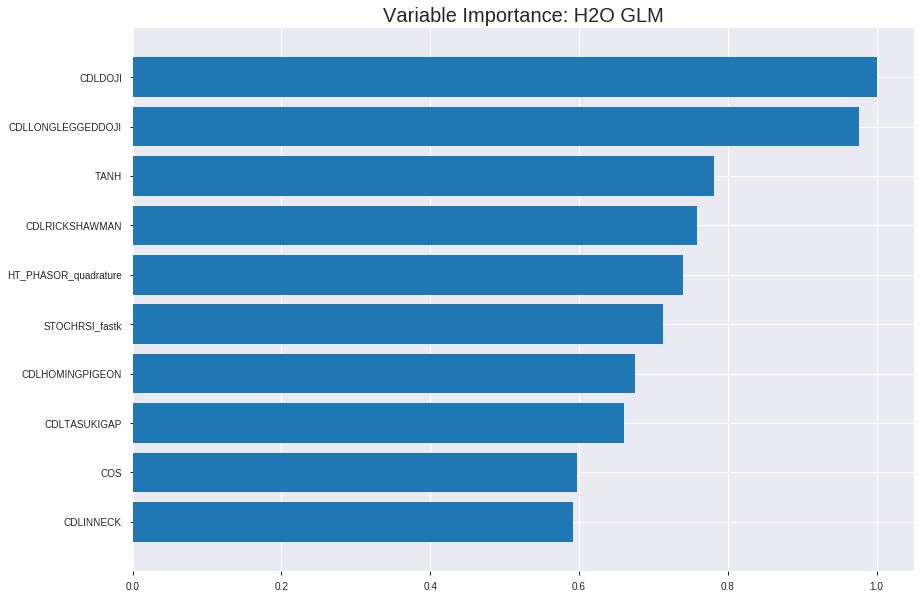

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_174333_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24713874958319001
RMSE: 0.4971305156427133
LogLoss: 0.6874146601303216
Null degrees of freedom: 1752
Residual degrees of freedom: 708
Null deviance: 2429.9224402865125
Residual deviance: 2410.0757984169077
AIC: 4500.075798416908
AUC: 0.5910677973603838
pr_auc: 0.592753235173201
Gini: 0.18213559472076768
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4744506341925878: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      62   804   0.9284   (804.0/866.0)
1      24   863   0.0271   (24.0/887.0)
Total  86   1667  0.4723   (828.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474451     0.675803  353
max f2                       0.445073     0.836792  398
max f0point5                 0.493311     0.57708   269
max accuracy                 0.508485     0.570451  179
max precision                0.578387     1         0
max recall                   0.445073     1         398
max specificity              0.578387     1         0
max absolute_mcc             0.515551     0.147342  138
max min_per_class_accuracy   0.506068     0.561443  193
max mean_per_class_accuracy  0.508485     0.570997  179

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.54787            1.42735   1.42735            0.722222         0.555008  0.722222                    0.555008            0.0146561       0.0146561                  42.7346   42.7346
    2        0.0205362                   0.543765           1.64694   1.53714            0.833333         0.545375  0.777778                    0.550191            0.0169109       0.0315671                  64.6937   53.7141
    3        0.0302339                   0.540846           1.2788    1.45428            0.647059         0.542338  0.735849                    0.547672            0.0124014       0.0439684                  27.8798   45.4277
    4        0.040502                    0.538635           1.20775   1.39178            0.611111         0.53956   0.704225                    0.545616            0.0124014       0.0563698                  20.7754   39.1778
    5        0.0501997                   0.536856           1.51131   1.41487            0.764706         0.537924  0.715909                    0.54413             0.0146561       0.0710259                  51.1307   41.4869
    6        0.100399                    0.531031           1.14537   1.28012            0.579545         0.533872  0.647727                    0.539001            0.0574972       0.128523                   14.537    28.0119
    7        0.150029                    0.52617            1.18125   1.24741            0.597701         0.528595  0.631179                    0.535559            0.0586246       0.187148                   18.1252   24.7414
    8        0.200228                    0.522353           1.19029   1.23309            0.602273         0.524219  0.623932                    0.532716            0.059752        0.2469                     19.0286   23.3091
    9        0.300057                    0.516035           1.19709   1.22111            0.605714         0.518947  0.617871                    0.528135            0.119504        0.366404                   19.7088   22.1113
    10       0.399886                    0.510792           0.937343  1.15027            0.474286         0.513393  0.582026                    0.524455            0.0935738       0.459977                   -6.26574  15.0272
    11       0.500285                    0.505961           1.01062   1.12225            0.511364         0.508494  0.567845                    0.521252            0.101466        0.561443                   1.06206   12.2246
    12       0.600114                    0.501313           0.937343  1.09149            0.474286         0.503397  0.552281                    0.518282            0.0935738       0.655017                   -6.26574  9.14873
    13       0.699943                    0.496021           0.982516  1.07595            0.497143         0.498562  0.544417                    0.515469            0.0980834       0.7531                     -1.74843  7.59453
    14       0.799772                    0.490011           0.846996  1.04737            0.428571         0.493209  0.529957                    0.512691            0.0845547       0.837655                   -15.3004  4.73675
    15       0.899601                    0.481804           0.926049  1.0339             0.468571         0.486192  0.523145                    0.50975             0.0924464       0.930101                   -7.39507  3.39048
    16       1                           0.429713           0.696205  1                  0.352273         0.472297  0.50599                     0.50599          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24893409767921365
RMSE: 0.49893295910293767
LogLoss: 0.6910131407524326
Null degrees of freedom: 500
Residual degrees of freedom: -544
Null deviance: 693.9584553730234
Residual deviance: 692.3951670339375
AIC: 2782.3951670339375
AUC: 0.5372634573583941
pr_auc: 0.5609897717899783
Gini: 0.07452691471678818
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45938894017195137: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    264  0        (0.0/264.0)
Total  0    501  0.4731   (237.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.459389     0.690196   399
max f2                       0.459389     0.847784   399
max f0point5                 0.482884     0.584135   358
max accuracy                 0.50669      0.540918   204
max precision                0.549558     1          0
max recall                   0.459389     1          399
max specificity              0.549558     1          0
max absolute_mcc             0.517114     0.0929116  116
max min_per_class_accuracy   0.506818     0.535865   203
max mean_per_class_accuracy  0.515868     0.541763   126

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.543289           1.26515   1.26515            0.666667         0.546047  0.666667                    0.546047            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.540722           1.13864   1.20764            0.6              0.541645  0.636364                    0.544046            0.0113636       0.0265152                  13.8636   20.7645
    3        0.0319361                   0.537697           1.51818   1.30469            0.8              0.539086  0.6875                      0.542496            0.0151515       0.0416667                  51.8182   30.4687
    4        0.0419162                   0.535111           0.379545  1.08442            0.2              0.536414  0.571429                    0.541048            0.00378788      0.0454545                  -62.0455  8.44156
    5        0.0518962                   0.533601           1.13864   1.09484            0.6              0.53404   0.576923                    0.5397              0.0113636       0.0568182                  13.8636   9.48427
    6        0.101796                    0.527775           1.13864   1.11631            0.6              0.529735  0.588235                    0.534815            0.0568182       0.113636                   13.8636   11.631
    7        0.151697                    0.524489           1.06273   1.09868            0.56             0.52641   0.578947                    0.53205             0.0530303       0.166667                   6.27273   9.86842
    8        0.201597                    0.52119            1.21455   1.12736            0.64             0.522945  0.594059                    0.529797            0.0606061       0.227273                   21.4545   12.7363
    9        0.301397                    0.515868           1.13864   1.1311             0.6              0.518449  0.596026                    0.526039            0.113636        0.340909                   13.8636   13.1096
    10       0.401198                    0.511746           0.797045  1.048              0.42             0.513705  0.552239                    0.522971            0.0795455       0.420455                   -20.2955  4.79986
    11       0.500998                    0.506998           1.13864   1.06605            0.6              0.509202  0.561753                    0.520228            0.113636        0.534091                   13.8636   6.6054
    12       0.600798                    0.502065           0.797045  1.02137            0.42             0.505003  0.538206                    0.517699            0.0795455       0.613636                   -20.2955  2.13682
    13       0.700599                    0.496515           1.10068   1.03267            0.58             0.499219  0.54416                     0.515066            0.109848        0.723485                   10.0682   3.26664
    14       0.800399                    0.491467           0.872955  1.01275            0.46             0.494087  0.533666                    0.512451            0.0871212       0.810606                   -12.7045  1.27522
    15       0.9002                      0.48332            1.02477   1.01408            0.54             0.487352  0.534368                    0.509668            0.102273        0.912879                   2.47727   1.40849
    16       1                           0.459383           0.872955  1                  0.46             0.475699  0.526946                    0.506278           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:43:37  0.000 sec   2            3.7       1045          1.37483           1.38203
    2019-08-27 17:43:39  2.241 sec   4            2.7       1045          1.3719            1.3825
    2019-08-27 17:43:42  5.449 sec   6            2         1045          1.36846           1.38314
    2019-08-27 17:43:45  8.417 sec   8            1.4       1045          1.36445           1.38433
    2019-08-27 17:43:47  10.703 sec  10           1         1045          1.35986           1.38583
    2019-08-27 17:43:50  12.954 sec  12           0.76      1045          1.35474           1.38775

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6666666666666667)

('auc', 0.5085746951219512)

('logloss', 0.6932500958294872)

('mean_per_class_error', 0.45582444105691056)

('rmse', 0.5000510583775637)

('mse', 0.25005106098452157)

glm prediction progress: |████████████████████████████████████████████████| 100%


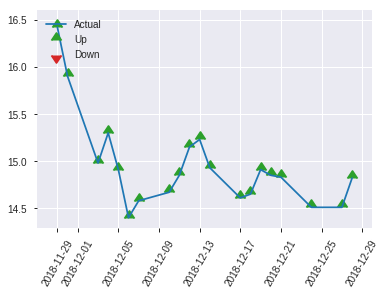


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25005106098452157
RMSE: 0.5000510583775637
LogLoss: 0.6932500958294872
Null degrees of freedom: 250
Residual degrees of freedom: -794
Null deviance: 348.11570799031966
Residual deviance: 348.01154810640253
AIC: 2438.0115481064026
AUC: 0.5085746951219512
pr_auc: 0.49273412727522314
Gini: 0.017149390243902385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4831794407187893: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    119  0.9297   (119.0/128.0)
1      2    121  0.0163   (2.0/123.0)
Total  11   240  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483179     0.666667  239
max f2                       0.476442     0.832206  246
max f0point5                 0.497364     0.562036  204
max accuracy                 0.502381     0.537849  188
max precision                0.545001     0.666667  5
max recall                   0.476442     1         246
max specificity              0.550027     0.992188  0
max absolute_mcc             0.483179     0.131999  239
max min_per_class_accuracy   0.512322     0.492188  125
max mean_per_class_accuracy  0.497364     0.544176  204

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.54734            0.680217  0.680217           0.333333         0.548562  0.333333                    0.548562            0.00813008      0.00813008                 -31.9783  -31.9783
    2        0.0239044                   0.545001           2.04065   1.36043            1                0.545818  0.666667                    0.54719             0.0243902       0.0325203                  104.065   36.0434
    3        0.0318725                   0.541479           0         1.02033            0                0.543468  0.5                         0.546259            0               0.0325203                  -100      2.03252
    4        0.0438247                   0.540235           0.680217  0.927568           0.333333         0.540696  0.454545                    0.544742            0.00813008      0.0406504                  -31.9783  -7.24316
    5        0.0517928                   0.539318           1.02033   0.941839           0.5              0.539636  0.461538                    0.543956            0.00813008      0.0487805                  2.03252   -5.81614
    6        0.103586                    0.534178           1.09881   1.02033            0.538462         0.536107  0.5                         0.540032            0.0569106       0.105691                   9.88118   2.03252
    7        0.151394                    0.531069           0.850271  0.966624           0.416667         0.532541  0.473684                    0.537666            0.0406504       0.146341                   -14.9729  -3.33761
    8        0.203187                    0.52775            1.41276   1.08034            0.692308         0.528993  0.529412                    0.535455            0.0731707       0.219512                   41.2758   8.03443
    9        0.302789                    0.522167           0.734634  0.966624           0.36             0.525439  0.473684                    0.53216             0.0731707       0.292683                   -26.5366  -3.33761
    10       0.40239                     0.517595           1.06114   0.990019           0.52             0.519854  0.485149                    0.529114            0.105691        0.398374                   6.11382   -0.998149
    11       0.501992                    0.512322           0.979512  0.987934           0.48             0.51473   0.484127                    0.52626             0.097561        0.495935                   -2.04878  -1.20661
    12       0.601594                    0.508502           0.897886  0.973025           0.44             0.510185  0.476821                    0.523599            0.0894309       0.585366                   -10.2114  -2.69746
    13       0.701195                    0.505043           1.22439   1.00873            0.6              0.506795  0.494318                    0.521212            0.121951        0.707317                   22.439    0.87306
    14       0.800797                    0.499107           1.30602   1.04571            0.64             0.502182  0.512438                    0.518845            0.130081        0.837398                   30.6016   4.57064
    15       0.900398                    0.490248           0.734634  1.0113             0.36             0.494643  0.495575                    0.516168            0.0731707       0.910569                   -26.5366  1.12958
    16       1                           0.458999           0.897886  1                  0.44             0.481687  0.49004                     0.512733

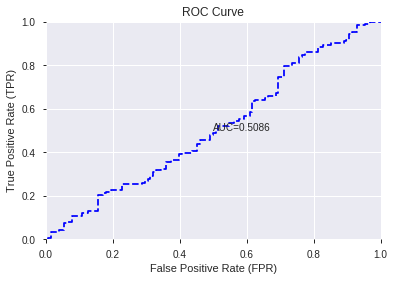

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


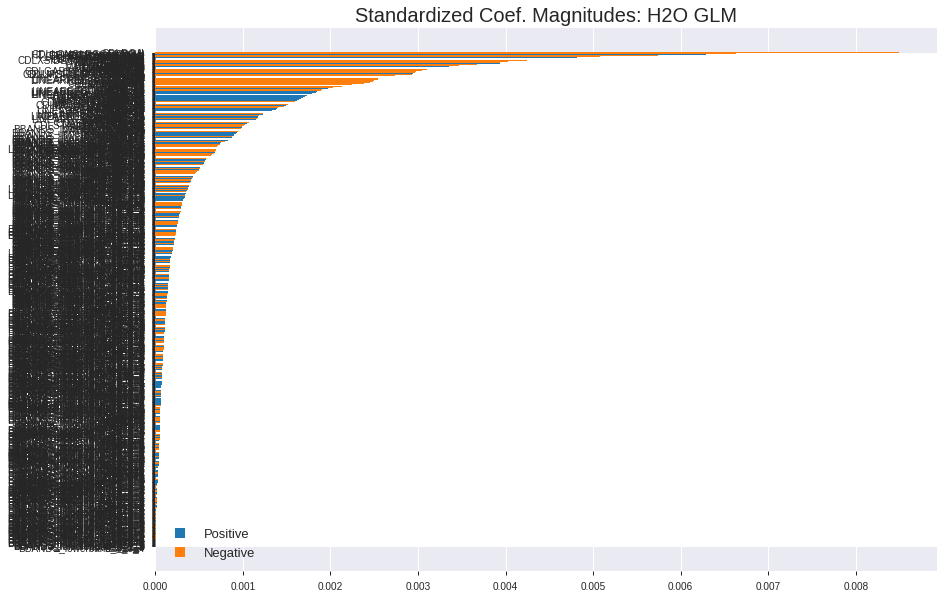

'log_likelihood'
--2019-08-27 17:44:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_174333_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_174333_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

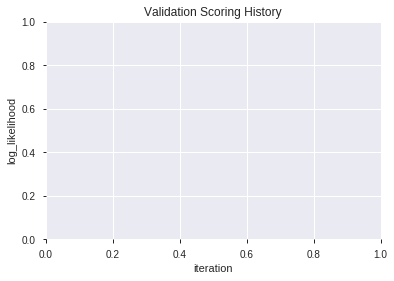

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_174420_model_3  0.560150  0.691485              0.480469  0.498878  0.248879
1  XGBoost_grid_1_AutoML_20190827_174420_model_1  0.541857  0.696276              0.492346  0.501369  0.251371
2  XGBoost_grid_1_AutoML_20190827_174420_model_6  0.537221  0.692974              0.473133  0.500112  0.250112
3               XGBoost_3_AutoML_20190827_174420  0.525470  0.700720              0.500000  0.503521  0.253533
4  XGBoost_grid_1_AutoML_20190827_174420_model_5  0.524200  0.724135              0.500000  0.513083  0.263254
5  XGBoost_grid_1_AutoML_20190827_174420_model_7  0.522802  0.710036              0.492188  0.507838  0.257899
6               XGBoost_1_AutoML_20190827_174420  0.515689  0.709384              0.484375  0.507517  0.257573
7  XGBoost_grid_1_AutoML_20190827_174420_model_2  0.515307  0.702202              0.496094  0.504328  0.254346
8               XGBoost_2_AutoML_20190827_174420  0.512767  0.700159              0.480786  0.503400  0.253412
9  XGBoost_grid_1_AutoML_20190827_174420_model_4  0.500508  0.700886              0.469068  0.503755  0.253769

variable  relative_importance  scaled_importance  percentage
0                        BOP           113.121506           1.000000    0.020048
1                        COS            91.569611           0.809480    0.016229
2                     MFI_12            88.199120           0.779685    0.015631
3             STOCHRSI_fastd            88.027969           0.778172    0.015601
4       HT_PHASOR_quadrature            81.723679           0.722442    0.014484
..                       ...                  ...                ...         ...
282   BBANDS_upperband_8_5_5             2.325548           0.020558    0.000412
283  BBANDS_upperband_20_1_3             1.735663           0.015343    0.000308
284                     High             0.927320           0.008198    0.000164
285  BBANDS_lowerband_14_6_5             0.823326           0.007278    0.000146
286              CDLLONGLINE             0.326742           0.002888    0.000058

[287 rows x 4 columns]

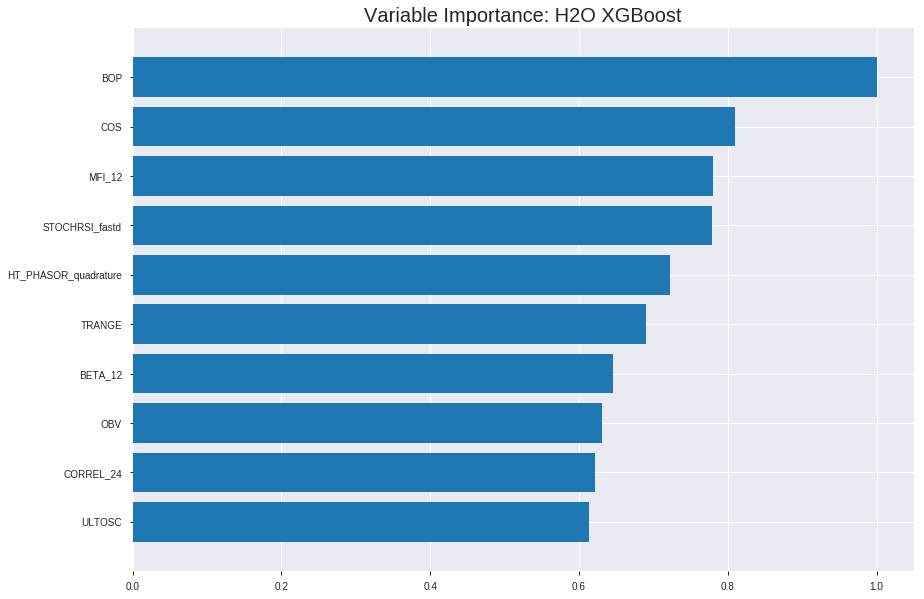

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_174420_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18144397209156565
RMSE: 0.4259624068994418
LogLoss: 0.5523853772958544
Mean Per-Class Error: 0.1328588984849155
AUC: 0.9437545401761653
pr_auc: 0.9460393862115016
Gini: 0.8875090803523307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5055069923400879: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      755  111  0.1282   (111.0/866.0)
1      122  765  0.1375   (122.0/887.0)
Total  877  876  0.1329   (233.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505507     0.867839  198
max f2                       0.456192     0.910153  250
max f0point5                 0.536123     0.895718  169
max accuracy                 0.505507     0.867085  198
max precision                0.838912     1         0
max recall                   0.391453     1         316
max specificity              0.838912     1         0
max absolute_mcc             0.505507     0.73423   198
max min_per_class_accuracy   0.504554     0.862587  199
max mean_per_class_accuracy  0.505507     0.867141  198

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.738012           1.97632    1.97632            1                0.765216  1                           0.765216            0.0202931       0.0202931                  97.6325   97.6325
    2        0.0205362                   0.714122           1.97632    1.97632            1                0.724296  1                           0.744756            0.0202931       0.0405862                  97.6325   97.6325
    3        0.0302339                   0.700461           1.97632    1.97632            1                0.705842  1                           0.732274            0.0191657       0.059752                   97.6325   97.6325
    4        0.040502                    0.690436           1.97632    1.97632            1                0.695433  1                           0.722934            0.0202931       0.0800451                  97.6325   97.6325
    5        0.0501997                   0.681446           1.97632    1.97632            1                0.686204  1                           0.715838            0.0191657       0.0992108                  97.6325   97.6325
    6        0.100399                    0.645944           1.95387    1.9651             0.988636         0.661994  0.994318                    0.688916            0.0980834       0.197294                   95.3866   96.5096
    7        0.150029                    0.62338            1.95361    1.9613             0.988506         0.635006  0.992395                    0.671083            0.096956        0.29425                    95.3608   96.1296
    8        0.200228                    0.607762           1.90895    1.94817            0.965909         0.614994  0.985755                    0.657021            0.0958286       0.390079                   90.895    94.8172
    9        0.300057                    0.576824           1.89727    1.93124            0.96             0.592556  0.977186                    0.635573            0.189402        0.579481                   89.7272   93.1237
    10       0.399886                    0.542466           1.64882    1.86073            0.834286         0.561277  0.941512                    0.617026            0.1646          0.744081                   64.8819   86.0734
    11       0.500285                    0.504946           1.17906    1.72393            0.596591         0.522492  0.872292                    0.598054            0.118377        0.862458                   17.9057   72.3932
    12       0.600114                    0.473494           0.767943   1.5649             0.388571         0.490703  0.791825                    0.580196            0.0766629       0.939121                   -23.2057  56.4903
    13       0.699943                    0.444236           0.372678   1.39486            0.188571         0.459044  0.705786                    0.562917            0.0372041       0.976325                   -62.7322  39.4863
    14       0.799772                    0.410285           0.169399   1.2419             0.0857143        0.426613  0.628388                    0.545903            0.0169109       0.993236                   -83.0601  24.1899
    15       0.899601                    0.36919            0.0677597  1.1116             0.0342857        0.389609  0.56246                     0.528559            0.00676437      1                          -93.224   11.1604
    16       1                           0.191635           0          1                  0                0.332765  0.50599                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2546350569202901
RMSE: 0.5046137700462504
LogLoss: 0.7025780603905329
Mean Per-Class Error: 0.4699846566935174
AUC: 0.5006153305203938
pr_auc: 0.5238044259625726
Gini: 0.0012306610407875063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3764801323413849: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   213  0.8987   (213.0/237.0)
1      11   253  0.0417   (11.0/264.0)
Total  35   466  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37648      0.693151  368
max f2                       0.30659      0.848329  398
max f0point5                 0.37648      0.594455  368
max accuracy                 0.378028     0.552894  366
max precision                0.698883     1         0
max recall                   0.30659      1         398
max specificity              0.698883     1         0
max absolute_mcc             0.37648      0.116732  368
max min_per_class_accuracy   0.488872     0.493671  199
max mean_per_class_accuracy  0.378028     0.530015  366

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.669383           1.26515   1.26515            0.666667         0.681308  0.666667                    0.681308            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.651133           0.379545  0.862603           0.2              0.65668   0.454545                    0.670113            0.00378788      0.0189394                  -62.0455  -13.7397
    3        0.0319361                   0.635551           1.89773   1.18608            1                0.640258  0.625                       0.660783            0.0189394       0.0378788                  89.7727   18.608
    4        0.0419162                   0.625314           1.13864   1.17478            0.6              0.627692  0.619048                    0.652905            0.0113636       0.0492424                  13.8636   17.4784
    5        0.0518962                   0.613836           0.379545  1.02185            0.2              0.614563  0.538462                    0.645531            0.00378788      0.0530303                  -62.0455  2.18531
    6        0.101796                    0.589524           1.06273   1.04189            0.56             0.60038   0.54902                     0.623398            0.0530303       0.106061                   6.27273   4.18895
    7        0.151697                    0.56558            0.759091  0.948864           0.4              0.574343  0.5                         0.607261            0.0378788       0.143939                   -24.0909  -5.11364
    8        0.201597                    0.553068           1.13864   0.995837           0.6              0.559337  0.524752                    0.595399            0.0568182       0.200758                   13.8636   -0.416292
    9        0.301397                    0.524508           0.986818  0.992851           0.52             0.537454  0.523179                    0.576212            0.0984848       0.299242                   -1.31818  -0.714931
    10       0.401198                    0.507077           0.948864  0.981909           0.5              0.516297  0.517413                    0.561308            0.094697        0.393939                   -5.11364  -1.80914
    11       0.500998                    0.488872           1.02477   0.990447           0.54             0.498294  0.521912                    0.548755            0.102273        0.496212                   2.47727   -0.95527
    12       0.600798                    0.471087           0.797045  0.958321           0.42             0.480343  0.504983                    0.537391            0.0795455       0.575758                   -20.2955  -4.16793
    13       0.700599                    0.455463           1.21455   0.99482            0.64             0.464089  0.524217                    0.526949            0.121212        0.69697                    21.4545   -0.518001
    14       0.800399                    0.429387           1.17659   1.01748            0.62             0.444391  0.53616                     0.516655            0.117424        0.814394                   17.6591   1.74847
    15       0.9002                      0.393962           1.06273   1.0225             0.56             0.414533  0.538803                    0.505333            0.106061        0.920455                   6.27273   2.25005
    16       1                           0.27459            0.797045  1                  0.42             0.35877   0.526946                    0.49070


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:44:45  7.628 sec   0                  0.5              0.693147            0.5             0                  1                0.49401                          0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 17:44:47  8.952 sec   5                  0.490909         0.675096            0.741709        0.734901           1.97632          0.32915                          0.501335           0.695827              0.48166           0.519625             1.26515            0.473054
    2019-08-27 17:44:47  9.343 sec   10                 0.480376         0.654507            0.834463        0.829057           1.86653          0.243582                         0.502728           0.69864               0.46877           0.498777             0.632576           0.469062
    2019-08-27 17:44:48  9.742 sec   15                 0.473336         0.640882            0.857919        0.856854           1.97632          0.224758                         0.503374           0.69994               0.468099          0.509442             1.26515            0.467066
    2019-08-27 17:44:48  10.117 sec  20                 0.466266         0.627334            0.873383        0.871894           1.97632          0.217912                         0.503463           0.700125              0.485488          0.512925             1.26515            0.467066
    2019-08-27 17:44:48  10.533 sec  25                 0.460055         0.615508            0.886274        0.88746            1.97632          0.192242                         0.50414            0.70147               0.47971           0.519128             1.89773            0.467066
    2019-08-27 17:44:49  10.939 sec  30                 0.453832         0.603745            0.897854        0.901197           1.97632          0.184826                         0.505109           0.703503              0.479478          0.52654              1.58144            0.467066
    2019-08-27 17:44:49  11.361 sec  35                 0.445413         0.588064            0.916995        0.918949           1.97632          0.166001                         0.504819           0.703                 0.493799          0.532491             1.58144            0.471058
    2019-08-27 17:44:50  11.771 sec  40                 0.439396         0.576876            0.924401        0.92795            1.97632          0.150029                         0.505091           0.703579              0.495149          0.530198             1.26515            0.471058
    2019-08-27 17:44:50  12.180 sec  45                 0.432147         0.563656            0.937547        0.940328           1.97632          0.142042                         0.504929           0.703235              0.49845           0.526105             0.948864           0.471058
    2019-08-27 17:44:50  12.595 sec  50                 0.425962         0.552385            0.943755        0.946039           1.97632          0.132915                         0.504614           0.702578              0.500615          0.523804             1.26515            0.447106

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      113.12150573730469     1.0                    0.0200480814265276
COS                      91.56961059570312      0.8094801249229281     0.016228523457610597
MFI_12                   88.1991195678711       0.779684808763867      0.015631184533124606
STOCHRSI_fastd           88.02796936035156      0.7781718320190474     0.015600852252148018
HT_PHASOR_quadrature     81.72367858886719      0.7224415733879038     0.01448356748918941
---                      ---                    ---                    ---
BBANDS_upperband_8_5_5   2.3255481719970703     0.020557966912123252   0.0004121477946181071
BBANDS_upperband_20_1_3  1.7356634140014648     0.0153433549411205     0.0003076048292156984
High                     0.9273204803466797     0.008197561324016856   0.00016434537692284332
BBANDS_lowerband_14_6_5  0.8233261108398438     0.007278245683467163   0.0001459148621044227
CDLLONGLINE              0.32674217224121094    0.0028884178133199954  5.7907235515272066e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6666666666666666)

('auc', 0.5601498983739838)

('logloss', 0.6914848930738736)

('mean_per_class_error', 0.43051321138211385)

('rmse', 0.49887815154122317)

('mse', 0.24887941008518763)

xgboost prediction progress: |████████████████████████████████████████████| 100%


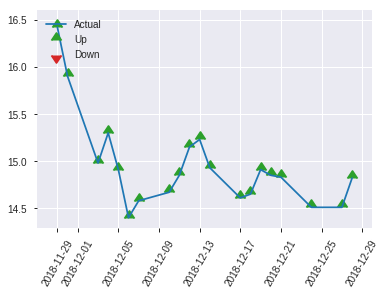


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24887941008518763
RMSE: 0.49887815154122317
LogLoss: 0.6914848930738736
Mean Per-Class Error: 0.43051321138211385
AUC: 0.5601498983739838
pr_auc: 0.5465765833029058
Gini: 0.12029979674796754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32634371519088745: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    123  0.9609   (123.0/128.0)
1      0    123  0        (0.0/123.0)
Total  5    246  0.49     (123.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326344     0.666667  245
max f2                       0.326344     0.833333  245
max f0point5                 0.372195     0.559737  234
max accuracy                 0.553862     0.573705  71
max precision                0.83578      1         0
max recall                   0.326344     1         245
max specificity              0.83578      1         0
max absolute_mcc             0.627798     0.169253  28
max min_per_class_accuracy   0.51336      0.552846  124
max mean_per_class_accuracy  0.553862     0.569487  71

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.772133           0.680217  0.680217           0.333333         0.809414  0.333333                    0.809414            0.00813008      0.00813008                 -31.9783  -31.9783
    2        0.0239044                   0.733182           0.680217  0.680217           0.333333         0.746542  0.333333                    0.777978            0.00813008      0.0162602                  -31.9783  -31.9783
    3        0.0318725                   0.719953           2.04065   1.02033            1                0.726985  0.5                         0.76523             0.0162602       0.0325203                  104.065   2.03252
    4        0.0438247                   0.690484           2.04065   1.2986             1                0.702731  0.636364                    0.748185            0.0243902       0.0569106                  104.065   29.8596
    5        0.0517928                   0.671923           1.02033   1.25578            0.5              0.678408  0.615385                    0.73745             0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.632045           1.56973   1.41276            0.769231         0.647392  0.692308                    0.692421            0.0813008       0.146341                   56.9731   41.2758
    7        0.151394                    0.600811           1.02033   1.28883            0.5              0.618745  0.631579                    0.669155            0.0487805       0.195122                   2.03252   28.8832
    8        0.203187                    0.57733            1.09881   1.2404             0.538462         0.588211  0.607843                    0.648522            0.0569106       0.252033                   9.88118   24.0395
    9        0.302789                    0.549978           1.06114   1.18143            0.52             0.562631  0.578947                    0.620269            0.105691        0.357724                   6.11382   18.1429
    10       0.40239                     0.531051           0.979512  1.13145            0.48             0.53972   0.554455                    0.600331            0.097561        0.455285                   -2.04878  13.145
    11       0.501992                    0.513318           0.979512  1.1013             0.48             0.520758  0.539683                    0.584542            0.097561        0.552846                   -2.04878  10.1303
    12       0.601594                    0.488986           0.81626   1.05411            0.4              0.50093   0.516556                    0.570699            0.0813008       0.634146                   -18.374   5.41108
    13       0.701195                    0.458057           0.897886  1.03192            0.44             0.474763  0.505682                    0.557072            0.0894309       0.723577                   -10.2114  3.19198
    14       0.800797                    0.427182           0.81626   1.0051             0.4              0.443584  0.492537                    0.542957            0.0813008       0.804878                   -18.374   0.509647
    15       0.900398                    0.392595           1.14276   1.02033            0.56             0.413412  0.5                         0.528626            0.113821        0.918699                   14.2764   2.03252
    16       1                           0.295053           0.81626   1                  0.4              0.35567   0.49004                     0.5114         

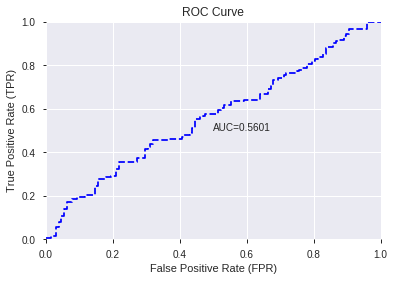

This function is available for GLM models only


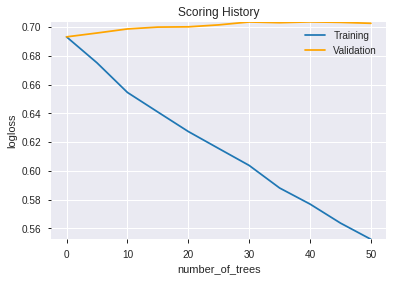

--2019-08-27 17:45:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_174420_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_174420_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_174525_model_5  0.575140  0.693636              0.465003  0.498128  0.248131
1  DeepLearning_grid_1_AutoML_20190827_174525_model_6  0.575076  0.695678              0.472974  0.497021  0.247030
2  DeepLearning_grid_1_AutoML_20190827_174525_model_4  0.566438  0.722132              0.461573  0.507349  0.257403
3               DeepLearning_1_AutoML_20190827_174525  0.566057  0.736380              0.484375  0.513349  0.263527
4  DeepLearning_grid_1_AutoML_20190827_174525_model_2  0.563453  0.697587              0.496094  0.501629  0.251632
5  DeepLearning_grid_1_AutoML_20190827_174525_model_3  0.538872  0.710074              0.500000  0.506463  0.256505
6  DeepLearning_grid_1_AutoML_20190827_174525_model_1  0.527757  0.914290              0.500000  0.552787  0.305573
7  DeepLearning_grid_1_AutoML_20190827_174525_model_7  0.506733  0.755377              0.500000  0.512243  0.262393
8  DeepLearning_grid_1_AutoML_20190827_174525_model_8  0.500000  0.697316              0.500000  0.502075  0.252079

variable  relative_importance  scaled_importance  percentage
0                       TANH             1.000000           1.000000    0.032120
1                      RSI_8             0.945587           0.945587    0.030372
2                    ADXR_12             0.848800           0.848800    0.027263
3                  CDLHARAMI             0.827349           0.827349    0.026574
4                     MOM_14             0.810801           0.810801    0.026043
5                     ATR_20             0.780147           0.780147    0.025058
6              days_in_month             0.764149           0.764149    0.024544
7                     ATR_12             0.764039           0.764039    0.024541
8                     CMO_24             0.724949           0.724949    0.023285
9                 ROCR100_30             0.722824           0.722824    0.023217
10               MACD_signal             0.719858           0.719858    0.023121
11                    BETA_8             0.710887           0.710887    0.022833
12         MACDFIX_signal_14             0.690849           0.690849    0.022190
13               HT_DCPERIOD             0.680928           0.680928    0.021871
14         MACDFIX_signal_24             0.676737           0.676737    0.021736
15                      CEIL             0.604352           0.604352    0.019412
16   BBANDS_upperband_12_2_5             0.602401           0.602401    0.019349
17   BBANDS_lowerband_12_7_3             0.591914           0.591914    0.019012
18  BBANDS_middleband_20_6_3             0.585380           0.585380    0.018802
19                   KAMA_24             0.582039           0.582039    0.018695
20   BBANDS_upperband_14_7_4             0.579450           0.579450    0.018612
21            is_month_start             0.577187           0.577187    0.018539
22   BBANDS_lowerband_14_1_3             0.576961           0.576961    0.018532
23   BBANDS_upperband_30_0_4             0.575924           0.575924    0.018498
24   BBANDS_upperband_30_5_5             0.571383           0.571383    0.018353
25  BBANDS_middleband_14_3_3             0.570256           0.570256    0.018316
26   BBANDS_middleband_8_2_4             0.567037           0.567037    0.018213
27  BBANDS_middleband_24_7_5             0.565813           0.565813    0.018174
28   BBANDS_lowerband_12_1_3             0.564594           0.564594    0.018134
29   BBANDS_upperband_30_1_5             0.564123           0.564123    0.018119
30    LINEARREG_INTERCEPT_12             0.563976           0.563976    0.018115
31    BBANDS_lowerband_8_2_4             0.560549           0.560549    0.018005
32                   MA_14_5             0.560065           0.560065    0.017989
33                 MAVP_14_4             0.559076           0.559076    0.017957
34  BBANDS_middleband_12_1_2             0.554434           0.554434    0.017808
35   BBANDS_upperband_24_3_4             0.552010           0.552010    0.017730
36   BBANDS_lowerband_14_1_2             0.545884           0.545884    0.017534
37  BBANDS_middleband_24_1_2             0.545497           0.545497    0.017521
38       CDLXSIDEGAP3METHODS             0.542415           0.542415    0.017422
39               MIDPOINT_12             0.541681           0.541681    0.017399
40   BBANDS_upperband_24_1_3             0.539574           0.539574    0.017331
41                   MA_24_7             0.539459           0.539459    0.017327
42   BBANDS_middleband_8_0_4             0.537591           0.537591    0.017267
43                    SMA_20             0.530974           0.530974    0.017055
44         CDL3WHITESOLDIERS             0.529951           0.529951    0.017022
45  BBANDS_middleband_30_0_3             0.526911           0.526911    0.016924
46   BBANDS_middleband_8_2_5             0.522340           0.522340    0.016777
47        CDLMORNINGDOJISTAR             0.520284           0.520284    0.016711
48                  SAR_0.12             0.516786  

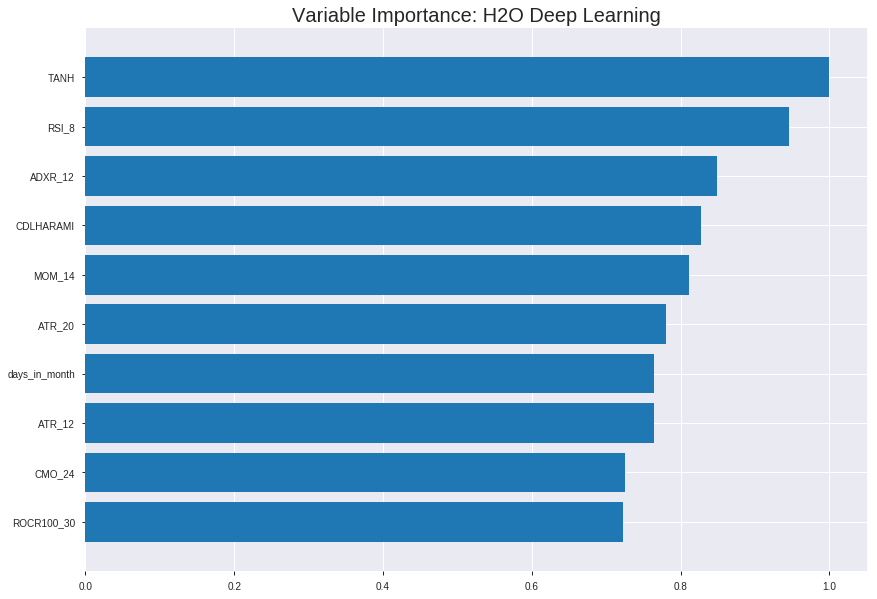

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_174525_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2454742219041577
RMSE: 0.49545355171212335
LogLoss: 0.6832463445045538
Mean Per-Class Error: 0.4654712279760773
AUC: 0.5421738428571801
pr_auc: 0.5739169835840082
Gini: 0.08434768571436013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4074832305884207: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    857   0.9896   (857.0/866.0)
1      0    887   0        (0.0/887.0)
Total  9    1744  0.4889   (857.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407483     0.674268  390
max f2                       0.407483     0.838057  390
max f0point5                 0.457616     0.572019  319
max accuracy                 0.465873     0.536794  294
max precision                0.993578     1         0
max recall                   0.407483     1         390
max specificity              0.993578     1         0
max absolute_mcc             0.540587     0.143413  61
max min_per_class_accuracy   0.48509      0.507328  226
max mean_per_class_accuracy  0.506869     0.534529  128

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.721259           1.97632   1.97632            1                0.831706  1                           0.831706            0.0202931       0.0202931                  97.6325   97.6325
    2        0.0205362                   0.593653           1.53714   1.75673            0.777778         0.661881  0.888889                    0.746793            0.0157835       0.0360767                  53.7141   75.6733
    3        0.0302339                   0.553976           1.51131   1.67801            0.764706         0.575527  0.849057                    0.691859            0.0146561       0.0507328                  51.1307   67.8012
    4        0.040502                    0.538081           1.64694   1.67013            0.833333         0.544116  0.84507                     0.654403            0.0169109       0.0676437                  64.6937   67.0134
    5        0.0501997                   0.530368           0.930035  1.52716            0.470588         0.533971  0.772727                    0.631138            0.00901917      0.0766629                  -6.99649  52.716
    6        0.100399                    0.510467           1.05554   1.29135            0.534091         0.519072  0.653409                    0.575105            0.0529876       0.129651                   5.55371   29.1349
    7        0.150029                    0.50123            0.954088  1.17978            0.482759         0.505369  0.596958                    0.552036            0.0473506       0.177001                   -4.59122  17.9783
    8        0.200228                    0.495908           0.988162  1.13174            0.5              0.498382  0.57265                     0.538585            0.0496054       0.226607                   -1.18377  13.1741
    9        0.300057                    0.489436           1.02769   1.09712            0.52             0.492298  0.555133                    0.523185            0.102593        0.3292                     2.76888   9.71232
    10       0.399886                    0.486045           0.914756  1.0516             0.462857         0.48748   0.532097                    0.514272            0.0913191       0.420519                   -8.5244   5.15964
    11       0.500285                    0.484994           0.909559  1.02309            0.460227         0.485535  0.517674                    0.508505            0.0913191       0.511838                   -9.04415  2.30917
    12       0.697091                    0.484977           1.01967   1.02213            0.515942         0.484977  0.517185                    0.501862            0.200676        0.712514                   1.9669    2.21254
    13       0.699943                    0.484917           0.395265  1.01957            0.2              0.48494   0.515892                    0.501793            0.0011274       0.713641                   -60.4735  1.95709
    14       0.799772                    0.475757           1.12933   1.03327            0.571429         0.48106   0.522825                    0.499205            0.11274         0.826381                   12.9328   3.3271
    15       0.899601                    0.458701           0.982516  1.02764            0.497143         0.467795  0.519975                    0.49572             0.0980834       0.924464                   -1.74843  2.76387
    16       1                           0.38185            0.752351  1                  0.380682         0.441241  0.50599                     0.49025            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.250504224804621
RMSE: 0.5005039708180355
LogLoss: 0.6946042809206897
Mean Per-Class Error: 0.4511651323360184
AUC: 0.5547484337041299
pr_auc: 0.5669638829428436
Gini: 0.1094968674082597
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41936858328222876: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    235  0.9916   (235.0/237.0)
1      0    264  0        (0.0/264.0)
Total  2    499  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419369     0.692005  397
max f2                       0.419369     0.848875  397
max f0point5                 0.467139     0.592369  334
max accuracy                 0.467139     0.552894  334
max precision                0.504622     0.678571  55
max recall                   0.419369     1         397
max specificity              0.83423      0.995781  0
max absolute_mcc             0.496792     0.120233  95
max min_per_class_accuracy   0.485812     0.535865  207
max mean_per_class_accuracy  0.496792     0.548835  95

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 48.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.578545           0.948864  0.948864           0.5              0.662392  0.5                         0.662392            0.0113636       0.0113636                  -5.11364  -5.11364
    2        0.0219561                   0.56553            1.13864   1.03512            0.6              0.569668  0.545455                    0.620245            0.0113636       0.0227273                  13.8636   3.5124
    3        0.0319361                   0.547164           0.759091  0.948864           0.4              0.550884  0.5                         0.598569            0.00757576      0.030303                   -24.0909  -5.11364
    4        0.0419162                   0.529325           1.13864   0.994048           0.6              0.534617  0.52381                     0.583343            0.0113636       0.0416667                  13.8636   -0.595238
    5        0.0518962                   0.522417           0.759091  0.948864           0.4              0.524975  0.5                         0.572118            0.00757576      0.0492424                  -24.0909  -5.11364
    6        0.101796                    0.505955           1.51818   1.22794            0.8              0.512246  0.647059                    0.542769            0.0757576       0.125                      51.8182   22.7941
    7        0.151697                    0.500103           1.13864   1.19856            0.6              0.502596  0.631579                    0.529554            0.0568182       0.181818                   13.8636   19.8565
    8        0.201597                    0.497303           1.21455   1.20252            0.64             0.498431  0.633663                    0.521851            0.0606061       0.242424                   21.4545   20.252
    9        0.301397                    0.491582           0.948864  1.11853            0.5              0.494446  0.589404                    0.512776            0.094697        0.337121                   -5.11364  11.8528
    10       0.401198                    0.488119           0.986818  1.08576            0.52             0.489521  0.572139                    0.506991            0.0984848       0.435606                   -1.31818  8.57644
    11       0.500998                    0.485815           1.02477   1.07361            0.54             0.486878  0.565737                    0.502984            0.102273        0.537879                   2.47727   7.36146
    12       0.600798                    0.484932           0.872955  1.04028            0.46             0.485457  0.548173                    0.500073            0.0871212       0.625                      -12.7045  4.02824
    13       0.700599                    0.48375            1.02477   1.03807            0.54             0.484297  0.547009                    0.497826            0.102273        0.727273                   2.47727   3.8073
    14       0.800399                    0.475496           1.02477   1.03641            0.54             0.480518  0.546135                    0.495667            0.102273        0.829545                   2.47727   3.64146
    15       0.9002                      0.460848           0.835     1.01408            0.44             0.468432  0.534368                    0.492648            0.0833333       0.912879                   -16.5     1.40849
    16       1                           0.409969           0.872955  1                  0.46             0.443349  0.526946                    0.487728       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:48:33  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:48:34  1 min 20.004 sec  1260 obs/sec      1         1             1753       0.546726         0.812842            -0.19581       0.519517        0.518082           0.988162         0.490588                         0.530597           0.765529              -0.129412        0.54977           0.563259             1.58144            0.43513
    2019-08-27 17:48:40  1 min 25.762 sec  2386 obs/sec      9         9             15777      0.499756         0.692373            0.00083266     0.533374        0.556586           1.86653          0.483172                         0.500856           0.69492               -0.00635008      0.550177          0.561295             0.948864           0.461078
    2019-08-27 17:48:46  1 min 32.182 sec  2449 obs/sec      17        17            29801      0.495454         0.683246            0.0179622      0.542174        0.573917           1.97632          0.488876                         0.500504           0.694604              -0.0049356       0.554748          0.566964             0.948864           0.469062
    2019-08-27 17:48:55  1 min 40.612 sec  2883 obs/sec      33        33            57849      0.491718         0.674657            0.0327139      0.576701        0.610507           1.97632          0.484883                         0.501093           0.697568              -0.00730255      0.553718          0.564237             0.948864           0.46507
    2019-08-27 17:49:01  1 min 46.187 sec  3071 obs/sec      44        44            77132      0.493708         0.678137            0.0248695      0.571335        0.602802           1.97632          0.478038                         0.507204           0.712032              -0.0320216       0.555819          0.561268             0.632576           0.469062
    2019-08-27 17:49:06  1 min 51.736 sec  3202 obs/sec      55        55            96415      0.489265         0.668027            0.0423402      0.583256        0.612733           1.97632          0.446663                         0.502676           0.70408               -0.0136767       0.550537          0.562371             0.632576           0.459082
    2019-08-27 17:49:12  1 min 57.600 sec  3313 obs/sec      67        67            117451     0.48587          0.660732            0.0555847      0.596106        0.643732           1.97632          0.467199                         0.503331           0.707655              -0.0163195       0.548531          0.55972              0.948864           0.467066
    2019-08-27 17:49:13  1 min 58.220 sec  3312 obs/sec      67        67            117451     0.495454         0.683246            0.0179622      0.542174        0.573917           1.97632          0.488876                         0.500504           0.694604              -0.0049356       0.554748          0.566964             0.948864           0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
TANH                      1.0                    1.0                  0.03211952018691501
RSI_8                     0.9455870985984802     0.9455870985984802   0.030371803901920284
ADXR_12                   0.8488003611564636     0.8488003611564636   0.027263060334825787
CDLHARAMI                 0.8273488879203796     0.8273488879203796   0.026574049307180322
MOM_14                    0.8108012676239014     0.8108012676239014   0.026042547683022183
---                       ---                    ---                  ---
BBANDS_middleband_30_0_3  0.5269113183021545     0.5269113183021545   0.016924138724920056
BBANDS_middleband_8_2_5   0.5223404765129089     0.5223404765129089   0.016777325479799186
CDLMORNINGDOJISTAR        0.5202844142913818     0.5202844142913818   0.016711285747769294
SAR_0.12                  0.5167862772941589     0.5167862772941589   0.016598927265870398
CDLGAPSIDESIDEWHITE       0.49753785133361816    0.49753785133361816  0.01598067705966447


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6721763085399449)

('auc', 0.5751397357723578)

('logloss', 0.6936356802949081)

('mean_per_class_error', 0.4301956300813008)

('rmse', 0.49812784963156614)

('mse', 0.2481313545785682)

deeplearning prediction progress: |███████████████████████████████████████| 100%


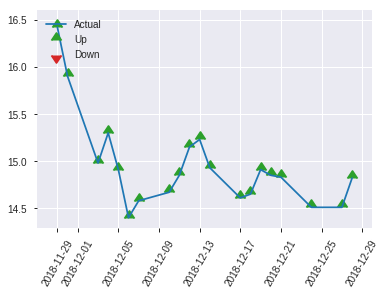


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2481313545785682
RMSE: 0.49812784963156614
LogLoss: 0.6936356802949081
Mean Per-Class Error: 0.4301956300813008
AUC: 0.5751397357723578
pr_auc: 0.5554075985372448
Gini: 0.15027947154471555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44529039790089836: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   118  0.9219   (118.0/128.0)
1      1    122  0.0081   (1.0/123.0)
Total  11   240  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44529      0.672176  239
max f2                       0.44304      0.836735  242
max f0point5                 0.47332      0.573871  173
max accuracy                 0.489528     0.573705  55
max precision                0.983125     1         0
max recall                   0.44304      1         242
max specificity              0.983125     1         0
max absolute_mcc             0.44304      0.177865  242
max min_per_class_accuracy   0.485576     0.520325  123
max mean_per_class_accuracy  0.486841     0.569804  75

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 48.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.901792           1.36043   1.36043            0.666667         0.958828  0.666667                    0.958828            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.722734           1.36043   1.36043            0.666667         0.778794  0.666667                    0.868811            0.0162602       0.0325203                  36.0434   36.0434
    3        0.0318725                   0.587247           1.02033   1.27541            0.5              0.625442  0.625                       0.807969            0.00813008      0.0406504                  2.03252   27.5407
    4        0.0438247                   0.52797            1.36043   1.2986             0.666667         0.53975   0.636364                    0.734818            0.0162602       0.0569106                  36.0434   29.8596
    5        0.0517928                   0.508779           1.02033   1.25578            0.5              0.516107  0.615385                    0.70117             0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.495029           1.41276   1.33427            0.692308         0.498752  0.653846                    0.599961            0.0731707       0.138211                   41.2758   33.4271
    7        0.151394                    0.491241           1.36043   1.34253            0.666667         0.49303   0.657895                    0.566193            0.0650407       0.203252                   36.0434   34.2533
    8        0.203187                    0.490275           1.25578   1.32042            0.615385         0.490726  0.647059                    0.546957            0.0650407       0.268293                   25.5785   32.0421
    9        0.302789                    0.486841           1.06114   1.23513            0.52             0.488422  0.605263                    0.527702            0.105691        0.373984                   6.11382   23.5131
    10       0.40239                     0.485694           0.571382  1.07084            0.28             0.48616   0.524752                    0.517419            0.0569106       0.430894                   -42.8618  7.08364
    11       0.501992                    0.48556            0.897886  1.03652            0.44             0.485628  0.507937                    0.511111            0.0894309       0.520325                   -10.2114  3.65208
    12       0.601594                    0.483499           1.06114   1.0406             0.52             0.485128  0.509934                    0.506809            0.105691        0.626016                   6.11382   4.05966
    13       0.701195                    0.472623           1.38764   1.08989            0.68             0.477196  0.534091                    0.502603            0.138211        0.764228                   38.7642   8.98928
    14       0.800797                    0.462991           0.81626   1.05586            0.4              0.467566  0.517413                    0.498245            0.0813008       0.845528                   -18.374   5.58589
    15       0.900398                    0.456801           0.81626   1.02935            0.4              0.460488  0.504425                    0.494068            0.0813008       0.926829                   -18.374   2.93546
    16       1                           0.435346           0.734634  1                  0.36             0.445537  0.49004                     0.489235         

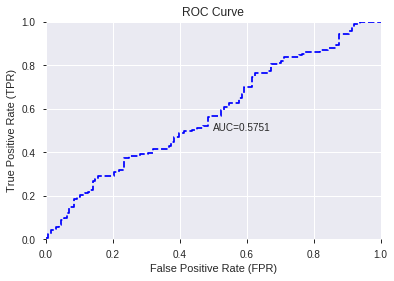

This function is available for GLM models only


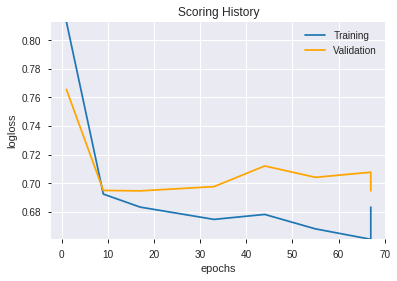

--2019-08-27 17:52:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_174525_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_174525_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TANH',
 'RSI_8',
 'ADXR_12',
 'CDLHARAMI',
 'MOM_14',
 'ATR_20',
 'days_in_month',
 'ATR_12',
 'CMO_24',
 'ROCR100_30',
 'MACD_signal',
 'BETA_8',
 'MACDFIX_signal_14',
 'HT_DCPERIOD',
 'MACDFIX_signal_24',
 'CEIL',
 'BBANDS_upperband_12_2_5',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_middleband_20_6_3',
 'KAMA_24',
 'BBANDS_upperband_14_7_4',
 'is_month_start',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_upperband_30_0_4',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_14_3_3',
 'BBANDS_middleband_8_2_4',
 'BBANDS_middleband_24_7_5',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_30_1_5',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_lowerband_8_2_4',
 'MA_14_5',
 'MAVP_14_4',
 'BBANDS_middleband_12_1_2',
 'BBANDS_upperband_24_3_4',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_middleband_24_1_2',
 'CDLXSIDEGAP3METHODS',
 'MIDPOINT_12',
 'BBANDS_upperband_24_1_3',
 'MA_24_7',
 'BBANDS_middleband_8_0_4',
 'SMA_20',
 'CDL3WHITESOLDIERS',
 'BBANDS_middleband_30_0_3',
 'BBANDS_middleband_8_2_5',
 'CDLMORNINGDOJISTAR

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_175257_model_1  0.550877  0.689194              0.469226  0.498032  0.248036

variable  relative_importance  scaled_importance  percentage
0                       TANH             0.055575           1.000000    0.114894
1        CDLXSIDEGAP3METHODS             0.035900           0.645978    0.074219
2                      RSI_8             0.035174           0.632913    0.072718
3                HT_DCPERIOD             0.031027           0.558297    0.064145
4                     MOM_14             0.029573           0.532129    0.061139
5                  CDLHARAMI             0.026687           0.480207    0.055173
6        CDLGAPSIDESIDEWHITE             0.024891           0.447888    0.051460
7         CDLMORNINGDOJISTAR             0.024033           0.432451    0.049686
8          MACDFIX_signal_14             0.020285           0.365011    0.041938
9                MACD_signal             0.020081           0.361328    0.041515
10         MACDFIX_signal_24             0.019499           0.350859    0.040312
11                    ATR_12             0.016480           0.296538    0.034071
12                   ADXR_12             0.015415           0.277380    0.031869
13                    ATR_20             0.013025           0.234374    0.026928
14   BBANDS_upperband_30_1_5             0.011914           0.214375    0.024630
15   BBANDS_upperband_30_5_5             0.011771           0.211796    0.024334
16   BBANDS_upperband_30_0_4             0.011473           0.206439    0.023719
17            is_month_start             0.010886           0.195873    0.022505
18   BBANDS_lowerband_12_7_3             0.006134           0.110380    0.012682
19   BBANDS_upperband_12_2_5             0.005211           0.093759    0.010772
20   BBANDS_lowerband_12_1_3             0.005007           0.090098    0.010352
21   BBANDS_upperband_24_1_3             0.004223           0.075994    0.008731
22   BBANDS_upperband_24_3_4             0.003583           0.064467    0.007407
23                    CMO_24             0.003249           0.058468    0.006718
24               MIDPOINT_12             0.003240           0.058308    0.006699
25    BBANDS_lowerband_8_2_4             0.003143           0.056558    0.006498
26   BBANDS_lowerband_14_1_3             0.003086           0.055531    0.006380
27    LINEARREG_INTERCEPT_12             0.003076           0.055342    0.006358
28                   KAMA_24             0.002945           0.052999    0.006089
29  BBANDS_middleband_30_0_3             0.002867           0.051587    0.005927
30   BBANDS_lowerband_14_1_2             0.002384           0.042905    0.004930
31                      CEIL             0.002215           0.039861    0.004580
32                ROCR100_30             0.002197           0.039530    0.004542
33  BBANDS_middleband_14_3_3             0.001515           0.027267    0.003133
34             days_in_month             0.001497           0.026938    0.003095
35                 MAVP_14_4             0.001469           0.026438    0.003038
36                   MA_24_7             0.001407           0.025310    0.002908
37  BBANDS_middleband_24_7_5             0.001372           0.024693    0.002837
38                    SMA_20             0.001371           0.024665    0.002834
39   BBANDS_upperband_14_7_4             0.001165           0.020968    0.002409
40  BBANDS_middleband_20_6_3             0.001139           0.020488    0.002354
41         CDL3WHITESOLDIERS             0.001133           0.020384    0.002342
42  BBANDS_middleband_12_1_2             0.001111           0.019983    0.002296
43   BBANDS_middleband_8_2_5             0.001000           0.017989    0.002067
44                   MA_14_5             0.000793           0.014265    0.001639
45                    BETA_8             0.000728           0.013104    0.001506
46   BBANDS_middleband_8_2_4             0.000719           0.012931    0.001486
47  BBANDS_middleband_24_1_2             0.000589           0.010590    0.001217
48                  SAR_0.12             0.000340  

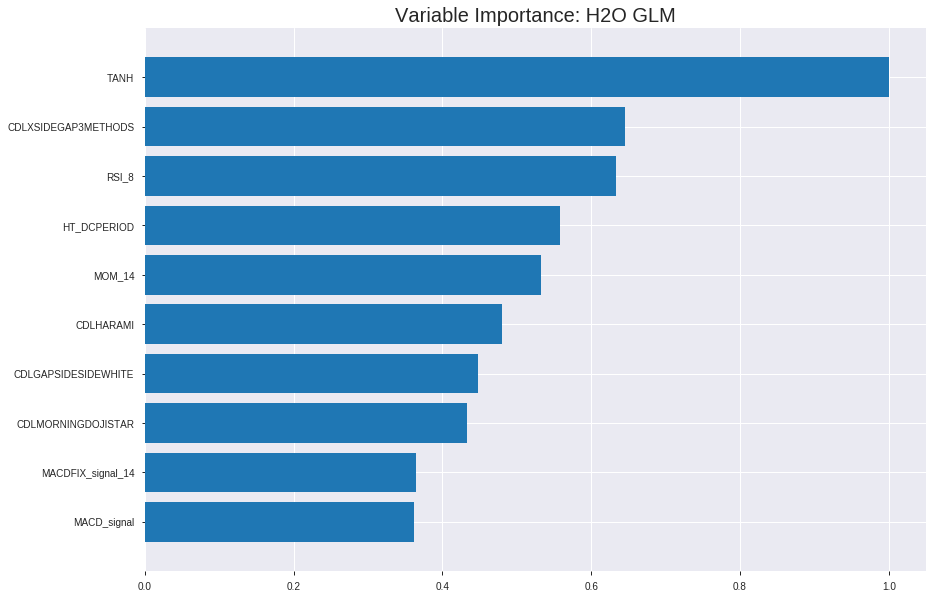

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_175257_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2477823703628531
RMSE: 0.49777743054788365
LogLoss: 0.6886169931989989
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.9224402865125
Residual deviance: 2414.2911781556904
AIC: 2516.2911781556904
AUC: 0.5525879329603121
pr_auc: 0.5618701727826398
Gini: 0.10517586592062411
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4600927293179013: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   848   0.9792   (848.0/866.0)
1      5    882   0.0056   (5.0/887.0)
Total  23   1730  0.4866   (853.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.460093     0.674054   379
max f2                       0.410281     0.83695    397
max f0point5                 0.464739     0.565503   372
max accuracy                 0.498519     0.540787   241
max precision                0.775109     1          0
max recall                   0.410281     1          397
max specificity              0.775109     1          0
max absolute_mcc             0.527087     0.0903443  95
max min_per_class_accuracy   0.504677     0.535797   206
max mean_per_class_accuracy  0.510942     0.541805   171

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.585386           1.64694   1.64694            0.833333         0.642787  0.833333                    0.642787            0.0169109       0.0169109                  64.6937   64.6937
    2        0.0205362                   0.553562           1.20775   1.42735            0.611111         0.563873  0.722222                    0.60333             0.0124014       0.0293123                  20.7754   42.7346
    3        0.0302339                   0.54697            1.16254   1.34241            0.588235         0.549342  0.679245                    0.586013            0.011274        0.0405862                  16.2544   34.2409
    4        0.040502                    0.544211           1.09796   1.28044            0.555556         0.545477  0.647887                    0.575736            0.011274        0.0518602                  9.79582   28.0436
    5        0.0501997                   0.54036            0.813781  1.19029            0.411765         0.542315  0.602273                    0.56928             0.00789177      0.059752                   -18.6219  19.0286
    6        0.100399                    0.530638           1.25766   1.22397            0.636364         0.534659  0.619318                    0.551969            0.0631342       0.122886                   25.7661   22.3974
    7        0.150029                    0.525077           1.06767   1.17227            0.54023          0.527515  0.593156                    0.54388             0.0529876       0.175874                   6.76697   17.2269
    8        0.200228                    0.520685           1.01062   1.13174            0.511364         0.52274   0.57265                     0.53858             0.0507328       0.226607                   1.06206   13.1741
    9        0.300057                    0.51469            1.0051    1.08961            0.508571         0.517688  0.551331                    0.531629            0.100338        0.326945                   0.510227  8.96087
    10       0.399886                    0.509275           1.09545   1.09107            0.554286         0.512002  0.552068                    0.526729            0.109357        0.436302                   9.54485   9.10666
    11       0.500285                    0.504683           0.988162  1.07042            0.5              0.50707   0.541619                    0.522784            0.0992108       0.535513                   -1.18377  7.04153
    12       0.600114                    0.49985            1.0051    1.05955            0.508571         0.502319  0.536122                    0.51938             0.100338        0.635851                   0.510227  5.95505
    13       0.699943                    0.495127           0.914756  1.0389             0.462857         0.497578  0.525672                    0.51627             0.0913191       0.72717                    -8.5244   3.88993
    14       0.799772                    0.489075           0.926049  1.02481            0.468571         0.492094  0.518545                    0.513253            0.0924464       0.819617                   -7.39507  2.48132
    15       0.899601                    0.480982           0.948636  1.01636            0.48             0.485257  0.514268                    0.510146            0.0947012       0.914318                   -5.13641  1.63597
    16       1                           0.272841           0.853413  1                  0.431818         0.46875   0.50599                     0.50599          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24898730759376658
RMSE: 0.49898627996545813
LogLoss: 0.6911235322727303
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.9584553730234
Residual deviance: 692.5057793372758
AIC: 794.5057793372758
AUC: 0.5512482419127989
pr_auc: 0.5592592089228877
Gini: 0.10249648382559773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.467483666722413: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    234  0.9873   (234.0/237.0)
1      1    263  0.0038   (1.0/264.0)
Total  4    497  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467484     0.691196  395
max f2                       0.42581      0.848329  398
max f0point5                 0.488474     0.589674  312
max accuracy                 0.488474     0.552894  312
max precision                0.603417     1         0
max recall                   0.42581      1         398
max specificity              0.603417     1         0
max absolute_mcc             0.512071     0.101807  108
max min_per_class_accuracy   0.501024     0.527426  206
max mean_per_class_accuracy  0.508293     0.546581  135

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.540441           0.632576  0.632576           0.333333         0.567438  0.333333                    0.567438            0.00757576      0.00757576                 -36.7424  -36.7424
    2        0.0219561                   0.534314           1.13864   0.862603           0.6              0.536793  0.454545                    0.553508            0.0113636       0.0189394                  13.8636   -13.7397
    3        0.0319361                   0.532508           0.759091  0.830256           0.4              0.53329   0.4375                      0.54719             0.00757576      0.0265152                  -24.0909  -16.9744
    4        0.0419162                   0.530058           1.51818   0.994048           0.8              0.530936  0.52381                     0.54332             0.0151515       0.0416667                  51.8182   -0.595238
    5        0.0518962                   0.527309           1.13864   1.02185            0.6              0.528262  0.538462                    0.540424            0.0113636       0.0530303                  13.8636   2.18531
    6        0.101796                    0.520718           1.29045   1.15352            0.68             0.523561  0.607843                    0.532158            0.0643939       0.117424                   29.0455   15.352
    7        0.151697                    0.517818           1.06273   1.12365            0.56             0.519029  0.592105                    0.527839            0.0530303       0.170455                   6.27273   12.3654
    8        0.201597                    0.515153           1.21455   1.14615            0.64             0.516584  0.60396                     0.525053            0.0606061       0.231061                   21.4545   14.6152
    9        0.301397                    0.509626           1.06273   1.11853            0.56             0.512018  0.589404                    0.520737            0.106061        0.337121                   6.27273   11.8528
    10       0.401198                    0.505648           0.986818  1.08576            0.52             0.507391  0.572139                    0.517417            0.0984848       0.435606                   -1.31818  8.57644
    11       0.500998                    0.501068           0.910909  1.05093            0.48             0.503424  0.553785                    0.514629            0.0909091       0.526515                   -8.90909  5.09326
    12       0.600798                    0.496529           1.06273   1.05289            0.56             0.498579  0.554817                    0.511963            0.106061        0.632576                   6.27273   5.28919
    13       0.700599                    0.49201            1.02477   1.04889            0.54             0.494258  0.552707                    0.509441            0.102273        0.734848                   2.47727   4.88863
    14       0.800399                    0.487793           0.948864  1.03641            0.5              0.489949  0.546135                    0.507011            0.094697        0.829545                   -5.11364  3.64146
    15       0.9002                      0.482306           0.872955  1.01829            0.46             0.485345  0.536585                    0.504609            0.0871212       0.916667                   -12.7045  1.82927
    16       1                           0.41548            0.835     1                  0.44             0.474283  0.526946                    0.501582     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:52:57  0.000 sec   2            2.8       51            1.38432           1.3841
    2019-08-27 17:52:57  0.018 sec   4            1.8       51            1.38343           1.38372
    2019-08-27 17:52:57  0.043 sec   6            1.1       51            1.38222           1.38325
    2019-08-27 17:52:57  0.059 sec   8            0.68      51            1.38071           1.38276
    2019-08-27 17:52:57  0.075 sec   10           0.42      51            1.37899           1.38238
    2019-08-27 17:52:57  0.103 sec   12           0.26      51            1.37723           1.38225
    2019-08-27 17:52:57  0.135 sec   14           0.16      51            1.37561           1.38247
    2019-08-27 17:52:57  0.164 sec   16           0.1       51            1.37423           1.38308
    2019-08-27 17:52:57  0.190 sec   18           0.063     51            1.37311           1.38401
    2019-08-27 17:52:57  0.215 sec   20           0.039     51            1.37222           1.38512
    2019-08-27 17:52:57  0.241 sec   22           0.024     51            1.37145           1.3863

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.6666666666666667)

('auc', 0.5508765243902439)

('logloss', 0.6891944742662892)

('mean_per_class_error', 0.44007240853658536)

('rmse', 0.49803164843123804)

('mse', 0.2480355228391363)

glm prediction progress: |████████████████████████████████████████████████| 100%


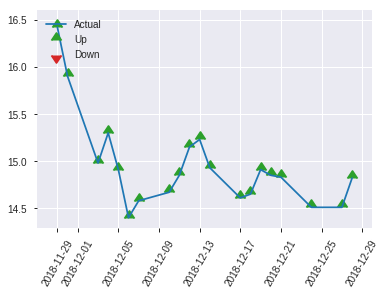


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2480355228391363
RMSE: 0.49803164843123804
LogLoss: 0.6891944742662892
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.11570799031966
Residual deviance: 345.9756260816772
AIC: 447.9756260816772
AUC: 0.5508765243902439
pr_auc: 0.5452127132885357
Gini: 0.10175304878048785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4856208256105975: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   117  0.9141   (117.0/128.0)
1      3    120  0.0244   (3.0/123.0)
Total  14   237  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485621     0.666667  236
max f2                       0.471609     0.828841  249
max f0point5                 0.485621     0.560224  236
max accuracy                 0.518454     0.565737  51
max precision                0.735783     1         0
max recall                   0.471609     1         249
max specificity              0.735783     1         0
max absolute_mcc             0.518454     0.147838  51
max min_per_class_accuracy   0.504485     0.512195  124
max mean_per_class_accuracy  0.518454     0.559928  51

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.674225           1.36043   1.36043            0.666667         0.712376  0.666667                    0.712376            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.630332           1.36043   1.36043            0.666667         0.642823  0.666667                    0.6776              0.0162602       0.0325203                  36.0434   36.0434
    3        0.0318725                   0.598997           1.02033   1.27541            0.5              0.610154  0.625                       0.660738            0.00813008      0.0406504                  2.03252   27.5407
    4        0.0438247                   0.569028           1.36043   1.2986             0.666667         0.579657  0.636364                    0.638625            0.0162602       0.0569106                  36.0434   29.8596
    5        0.0517928                   0.557837           1.02033   1.25578            0.5              0.56466   0.615385                    0.627246            0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.529122           1.56973   1.41276            0.769231         0.538138  0.692308                    0.582692            0.0813008       0.146341                   56.9731   41.2758
    7        0.151394                    0.52178            0.680217  1.18143            0.333333         0.525285  0.578947                    0.564564            0.0325203       0.178862                   -31.9783  18.1429
    8        0.203187                    0.51847            1.56973   1.28041            0.769231         0.52019   0.627451                    0.553253            0.0813008       0.260163                   56.9731   28.0408
    9        0.302789                    0.512913           0.653008  1.07403            0.32             0.516073  0.526316                    0.541022            0.0650407       0.325203                   -34.6992  7.40265
    10       0.40239                     0.508746           1.14276   1.09104            0.56             0.510469  0.534653                    0.53346             0.113821        0.439024                   14.2764   9.10408
    11       0.501992                    0.504282           0.734634  1.02033            0.36             0.506312  0.5                         0.528073            0.0731707       0.512195                   -26.5366  2.03252
    12       0.601594                    0.500288           1.06114   1.02708            0.52             0.502207  0.503311                    0.523791            0.105691        0.617886                   6.11382   2.70823
    13       0.701195                    0.496201           0.979512  1.02033            0.48             0.498397  0.5                         0.520184            0.097561        0.715447                   -2.04878  2.03252
    14       0.800797                    0.491702           1.06114   1.0254             0.52             0.493997  0.502488                    0.516927            0.105691        0.821138                   6.11382   2.54014
    15       0.900398                    0.487143           0.979512  1.02033            0.48             0.489377  0.5                         0.513879            0.097561        0.918699                   -2.04878  2.03252
    16       1                           0.462947           0.81626   1                  0.4              0.482547  0.49004                     0.510758         

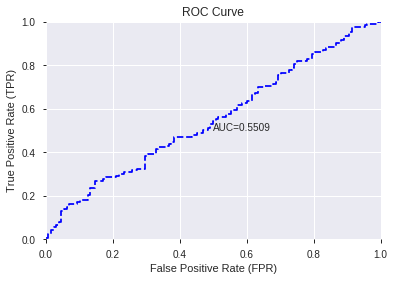

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


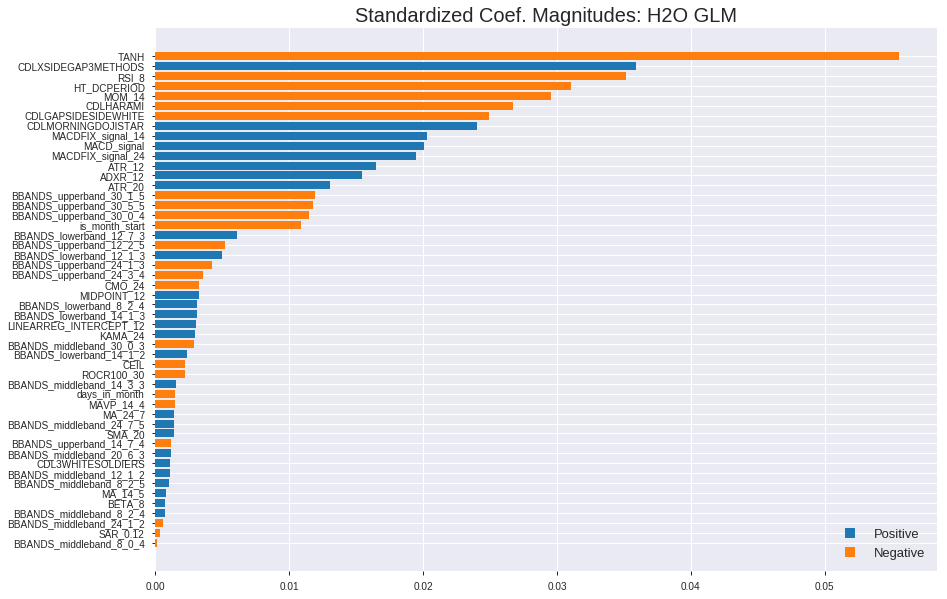

'log_likelihood'
--2019-08-27 17:53:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_175257_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_175257_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['TANH',
 'CDLXSIDEGAP3METHODS',
 'RSI_8',
 'HT_DCPERIOD',
 'MOM_14',
 'CDLHARAMI',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'MACDFIX_signal_14',
 'MACD_signal',
 'MACDFIX_signal_24',
 'ATR_12',
 'ADXR_12',
 'ATR_20',
 'BBANDS_upperband_30_1_5',
 'BBANDS_upperband_30_5_5',
 'BBANDS_upperband_30_0_4',
 'is_month_start',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_12_2_5',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_24_1_3',
 'BBANDS_upperband_24_3_4',
 'CMO_24',
 'MIDPOINT_12',
 'BBANDS_lowerband_8_2_4',
 'BBANDS_lowerband_14_1_3',
 'LINEARREG_INTERCEPT_12',
 'KAMA_24',
 'BBANDS_middleband_30_0_3',
 'BBANDS_lowerband_14_1_2',
 'CEIL',
 'ROCR100_30',
 'BBANDS_middleband_14_3_3',
 'days_in_month',
 'MAVP_14_4',
 'MA_24_7',
 'BBANDS_middleband_24_7_5',
 'SMA_20',
 'BBANDS_upperband_14_7_4',
 'BBANDS_middleband_20_6_3',
 'CDL3WHITESOLDIERS',
 'BBANDS_middleband_12_1_2',
 'BBANDS_middleband_8_2_5',
 'MA_14_5',
 'BETA_8',
 'BBANDS_middleband_8_2_4',
 'BBANDS_middleband_24_1_2',
 

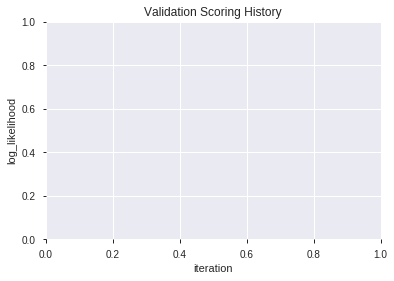

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_175307  0.593972  0.679100              0.435340  0.493118  0.243166
1  XGBoost_grid_1_AutoML_20190827_175307_model_3  0.592353  0.682520              0.465796  0.494736  0.244764
2  XGBoost_grid_1_AutoML_20190827_175307_model_1  0.573171  0.685941              0.480628  0.496329  0.246342
3  XGBoost_grid_1_AutoML_20190827_175307_model_6  0.567804  0.689745              0.484693  0.498289  0.248292
4               XGBoost_1_AutoML_20190827_175307  0.565676  0.694581              0.420351  0.500361  0.250361
5  XGBoost_grid_1_AutoML_20190827_175307_model_2  0.562246  0.688658              0.492346  0.497758  0.247763
6  XGBoost_grid_1_AutoML_20190827_175307_model_7  0.552210  0.709138              0.496094  0.507006  0.257055
7  XGBoost_grid_1_AutoML_20190827_175307_model_4  0.544938  0.692181              0.496094  0.499497  0.249498
8  XGBoost_grid_1_AutoML_20190827_175307_model_5  0.544144  0.723896              0.450807  0.513688  0.263875
9               XGBoost_2_AutoML_20190827_175307  0.523692  0.704503              0.484375  0.505239  0.255266

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD           291.545715           1.000000    0.089353
1                     CMO_24           285.501526           0.979268    0.087501
2                 ROCR100_30           234.310684           0.803684    0.071812
3                      RSI_8           233.334198           0.800335    0.071512
4                     BETA_8           223.919006           0.768041    0.068627
5                    ADXR_12           202.685043           0.695208    0.062119
6                     MOM_14           164.640533           0.564716    0.050459
7          MACDFIX_signal_24           151.197220           0.518606    0.046339
8                     ATR_12           150.654800           0.516745    0.046173
9                     ATR_20           121.552505           0.416924    0.037253
10         MACDFIX_signal_14            81.890549           0.280884    0.025098
11   BBANDS_upperband_12_2_5            80.803955           0.277157    0.024765
12                 MAVP_14_4            78.394051           0.268891    0.024026
13               MACD_signal            77.851006           0.267028    0.023860
14  BBANDS_middleband_14_3_3            67.887199           0.232853    0.020806
15   BBANDS_lowerband_14_1_3            64.456764           0.221086    0.019755
16   BBANDS_upperband_30_0_4            59.751816           0.204948    0.018313
17   BBANDS_lowerband_12_7_3            51.288330           0.175919    0.015719
18   BBANDS_upperband_24_1_3            50.824989           0.174329    0.015577
19                  SAR_0.12            49.491039           0.169754    0.015168
20    LINEARREG_INTERCEPT_12            44.938095           0.154137    0.013773
21   BBANDS_upperband_14_7_4            41.327267           0.141752    0.012666
22   BBANDS_upperband_24_3_4            38.067688           0.130572    0.011667
23   BBANDS_middleband_8_2_4            37.604279           0.128982    0.011525
24   BBANDS_lowerband_14_1_2            34.901184           0.119711    0.010697
25                      TANH            33.621693           0.115322    0.010304
26                   MA_24_7            31.711302           0.108770    0.009719
27   BBANDS_middleband_8_0_4            31.596893           0.108377    0.009684
28   BBANDS_lowerband_12_1_3            28.807354           0.098809    0.008829
29    BBANDS_lowerband_8_2_4            28.419250           0.097478    0.008710
30               MIDPOINT_12            24.143806           0.082813    0.007400
31   BBANDS_upperband_30_5_5            23.270292           0.079817    0.007132
32  BBANDS_middleband_30_0_3            22.722084           0.077937    0.006964
33             days_in_month            21.780025           0.074705    0.006675
34  BBANDS_middleband_12_1_2            17.464725           0.059904    0.005353
35                   MA_14_5            17.165361           0.058877    0.005261
36                    SMA_20            16.007792           0.054907    0.004906
37                 CDLHARAMI            15.383673           0.052766    0.004715
38   BBANDS_upperband_30_1_5            12.579035           0.043146    0.003855
39  BBANDS_middleband_20_6_3            10.796947           0.037033    0.003309
40   BBANDS_middleband_8_2_5             6.362806           0.021824    0.001950
41  BBANDS_middleband_24_1_2             2.198406           0.007541    0.000674

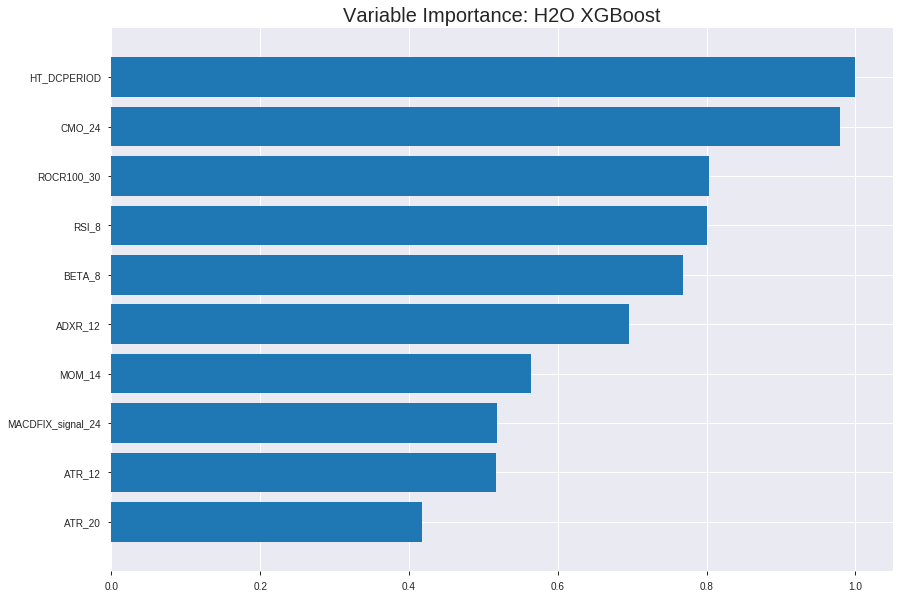

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_175307


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2079515116329804
RMSE: 0.4560170080523098
LogLoss: 0.6072539796237223
Mean Per-Class Error: 0.21753334669891766
AUC: 0.8606963295848945
pr_auc: 0.8555492684987969
Gini: 0.721392659169789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4904032399257024: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      594  272   0.3141   (272.0/866.0)
1      128  759   0.1443   (128.0/887.0)
Total  722  1031  0.2282   (400.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490403     0.791449  224
max f2                       0.441846     0.873914  287
max f0point5                 0.529957     0.798563  168
max accuracy                 0.512466     0.782088  192
max precision                0.767371     1         0
max recall                   0.358684     1         364
max specificity              0.767371     1         0
max absolute_mcc             0.512466     0.565796  192
max min_per_class_accuracy   0.506333     0.771139  200
max mean_per_class_accuracy  0.512466     0.782467  192

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.726544           1.86653    1.86653            0.944444         0.747583  0.944444                    0.747583            0.0191657       0.0191657                  86.6529   86.6529
    2        0.0205362                   0.690012           1.97632    1.92143            1                0.705729  0.972222                    0.726656            0.0202931       0.0394589                  97.6325   92.1427
    3        0.0302339                   0.657489           1.97632    1.93904            1                0.670408  0.981132                    0.708614            0.0191657       0.0586246                  97.6325   93.9036
    4        0.040502                    0.645661           1.75673    1.89282            0.888889         0.651445  0.957746                    0.69412             0.0180383       0.0766629                  75.6733   89.2818
    5        0.0501997                   0.634779           1.97632    1.90895            1                0.638618  0.965909                    0.683398            0.0191657       0.0958286                  97.6325   90.895
    6        0.100399                    0.602254           1.88649    1.89772            0.954545         0.618498  0.960227                    0.650948            0.0947012       0.19053                    88.6492   89.7721
    7        0.150029                    0.585505           1.74916    1.84858            0.885057         0.593115  0.935361                    0.631817            0.0868095       0.277339                   74.9161   84.8577
    8        0.200228                    0.571607           1.68437    1.80741            0.852273         0.577874  0.91453                     0.618293            0.0845547       0.361894                   68.4368   80.7408
    9        0.300057                    0.547808           1.62623    1.74713            0.822857         0.558253  0.88403                     0.598318            0.162345        0.524239                   62.6233   74.7131
    10       0.399886                    0.526708           1.38907    1.65774            0.702857         0.53766   0.838802                    0.583175            0.13867         0.662909                   38.9074   65.7745
    11       0.500285                    0.506234           1.078      1.5414             0.545455         0.516453  0.779932                    0.569785            0.10823         0.771139                   7.79953   54.1398
    12       0.600114                    0.487965           0.903463   1.43528            0.457143         0.497569  0.726236                    0.557772            0.0901917       0.86133                    -9.65373  43.5278
    13       0.699943                    0.467969           0.677597   1.32721            0.342857         0.477554  0.671557                    0.546331            0.0676437       0.928974                   -32.2403  32.7214
    14       0.799772                    0.441033           0.463025   1.21934            0.234286         0.455417  0.616976                    0.534983            0.0462232       0.975197                   -53.6975  21.9344
    15       0.899601                    0.401827           0.180693   1.10409            0.0914286        0.423597  0.558656                    0.522622            0.0180383       0.993236                   -81.9307  10.4085
    16       1                           0.24972            0.0673747  1                  0.0340909        0.357664  0.50599                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2516079369956282
RMSE: 0.501605359815491
LogLoss: 0.6964203506697352
Mean Per-Class Error: 0.4684503260452627
AUC: 0.5046269658611431
pr_auc: 0.5439801958695958
Gini: 0.009253931722286168
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2975064218044281: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    234  0.9873   (234.0/237.0)
1      1    263  0.0038   (1.0/264.0)
Total  4    497  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.297506     0.691196   395
max f2                       0.280344     0.847784   399
max f0point5                 0.416867     0.586977   363
max accuracy                 0.416867     0.540918   363
max precision                0.623127     0.888889   7
max recall                   0.280344     1          399
max specificity              0.69548      0.995781   0
max absolute_mcc             0.623127     0.0980483  7
max min_per_class_accuracy   0.503006     0.503788   197
max mean_per_class_accuracy  0.519563     0.53155    146

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.667033           1.58144   1.58144            0.833333         0.679929  0.833333                    0.679929            0.0189394       0.0189394                  58.1439   58.1439
    2        0.0219561                   0.613605           1.13864   1.38017            0.6              0.62759   0.727273                    0.656139            0.0113636       0.030303                   13.8636   38.0165
    3        0.0319361                   0.597738           0.759091  1.18608            0.4              0.6054    0.625                       0.640283            0.00757576      0.0378788                  -24.0909  18.608
    4        0.0439122                   0.589564           1.26515   1.20764            0.666667         0.592022  0.636364                    0.627121            0.0151515       0.0530303                  26.5152   20.7645
    5        0.0518962                   0.585786           0.948864  1.16783            0.5              0.587039  0.615385                    0.620954            0.00757576      0.0606061                  -5.11364  16.7832
    6        0.101796                    0.561094           0.986818  1.0791             0.52             0.571459  0.568627                    0.596692            0.0492424       0.109848                   -1.31818  7.90998
    7        0.151697                    0.549798           0.531364  0.898923           0.28             0.554768  0.473684                    0.582901            0.0265152       0.136364                   -46.8636  -10.1077
    8        0.201597                    0.5419             1.44227   1.03342            0.76             0.545964  0.544554                    0.573759            0.0719697       0.208333                   44.2273   3.34158
    9        0.301397                    0.526965           1.02477   1.03055            0.54             0.533242  0.543046                    0.560342            0.102273        0.310606                   2.47727   3.05539
    10       0.401198                    0.516878           1.10068   1.048              0.58             0.522224  0.552239                    0.55086             0.109848        0.420455                   10.0682   4.79986
    11       0.500998                    0.502135           0.835     1.00557            0.44             0.509332  0.52988                     0.542588            0.0833333       0.503788                   -16.5     0.556863
    12       0.602794                    0.488988           0.744207  0.961431           0.392157         0.495043  0.506623                    0.534559            0.0757576       0.579545                   -25.5793  -3.85686
    13       0.700599                    0.477333           1.04569   0.973193           0.55102          0.483111  0.512821                    0.527377            0.102273        0.681818                   4.56865   -2.68065
    14       0.800399                    0.45994            1.21455   1.00329            0.64             0.468656  0.528678                    0.520055            0.121212        0.80303                    21.4545   0.328724
    15       0.9002                      0.427328           1.06273   1.00988            0.56             0.446719  0.532151                    0.511924            0.106061        0.909091                   6.27273   0.987704
    16       1                           0.280344           0.910909  1                  0.48             0.385148  0.526946                    0.499272    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:53:11  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.49401                          0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 17:53:11  0.115 sec   5                  0.495169         0.683516            0.68561         0.68184            1.97632          0.401027                         0.499692           0.692532              0.525572          0.569822             1.35552            0.469062
    2019-08-27 17:53:11  0.170 sec   10                 0.490918         0.675083            0.716728        0.714668           1.97632          0.374786                         0.499206           0.691556              0.535386          0.575245             1.26515            0.469062
    2019-08-27 17:53:11  0.222 sec   15                 0.48662          0.666586            0.754546        0.755245           1.97632          0.339418                         0.49979            0.692724              0.51281           0.553521             1.58144            0.467066
    2019-08-27 17:53:11  0.290 sec   20                 0.481167         0.655906            0.78415         0.781919           1.86653          0.314318                         0.500248           0.693639              0.498026          0.551766             1.58144            0.471058
    2019-08-27 17:53:11  0.356 sec   25                 0.476148         0.646117            0.807312        0.803193           1.86653          0.284084                         0.499967           0.693071              0.505298          0.552304             1.58144            0.467066
    2019-08-27 17:53:11  0.427 sec   30                 0.47149          0.637085            0.823254        0.818987           1.86653          0.268112                         0.500223           0.693571              0.500224          0.557263             1.58144            0.467066
    2019-08-27 17:53:11  0.512 sec   35                 0.466798         0.628016            0.836992        0.834469           1.97632          0.245864                         0.500221           0.69361               0.514624          0.557591             1.58144            0.46507
    2019-08-27 17:53:11  0.599 sec   40                 0.463103         0.620921            0.847435        0.844509           1.97632          0.25328                          0.500834           0.694872              0.517805          0.555704             1.58144            0.469062
    2019-08-27 17:53:11  0.689 sec   45                 0.459458         0.613893            0.857483        0.850396           1.86653          0.233885                         0.50106            0.695335              0.511364          0.54793              1.58144            0.473054
    2019-08-27 17:53:12  0.758 sec   50                 0.456017         0.607254            0.860696        0.855549           1.86653          0.22818                          0.501605           0.69642               0.504627          0.54398              1.58144            0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
HT_DCPERIOD               291.54571533203125     1.0                   0.08935306124362416
CMO_24                    285.50152587890625     0.9792684675669423    0.08750063535645898
ROCR100_30                234.31068420410156     0.8036841973041974    0.07181164330225487
RSI_8                     233.33419799804688     0.8003348556582651    0.07151236937304006
BETA_8                    223.91900634765625     0.7680408065426128    0.06862679722460457
---                       ---                    ---                   ---
CDLHARAMI                 15.383672714233398     0.05276590224182671   0.0047147948945890274
BBANDS_upperband_30_1_5   12.579034805297852     0.04314601156450551   0.003855228213741377
BBANDS_middleband_20_6_3  10.796947479248047     0.03703346306067911   0.0033090532929243538
BBANDS_middleband_8_2_5   6.36280632019043       0.021824386316032982  0.001950075727101008
BBANDS_middleband_24_1_2  2.198406219482422      0.007540519732827264  0.000673768521496071


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6686567164179104)

('auc', 0.5939723069105691)

('logloss', 0.6791002390311248)

('mean_per_class_error', 0.41250635162601623)

('rmse', 0.4931182693872922)

('mse', 0.2431656276035181)

xgboost prediction progress: |████████████████████████████████████████████| 100%


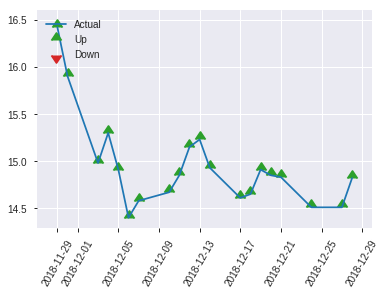


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2431656276035181
RMSE: 0.4931182693872922
LogLoss: 0.6791002390311248
Mean Per-Class Error: 0.41250635162601623
AUC: 0.5939723069105691
pr_auc: 0.59368406093079
Gini: 0.18794461382113825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4242410361766815: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      28   100  0.7812   (100.0/128.0)
1      11   112  0.0894   (11.0/123.0)
Total  39   212  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424241     0.668657  207
max f2                       0.312065     0.828841  245
max f0point5                 0.424241     0.576725  207
max accuracy                 0.539424     0.589641  94
max precision                0.734672     1         0
max recall                   0.312065     1         245
max specificity              0.734672     1         0
max absolute_mcc             0.65049      0.18994   13
max min_per_class_accuracy   0.520842     0.569106  120
max mean_per_class_accuracy  0.539424     0.587494  94

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.720978           2.04065   2.04065            1                0.72966   1                           0.72966             0.0243902       0.0243902                  104.065   104.065
    2        0.0239044                   0.713532           1.36043   1.70054            0.666667         0.717988  0.833333                    0.723824            0.0162602       0.0406504                  36.0434   70.0542
    3        0.0318725                   0.687485           2.04065   1.78557            1                0.690954  0.875                       0.715606            0.0162602       0.0569106                  104.065   78.5569
    4        0.0438247                   0.657995           1.36043   1.66962            0.666667         0.67698   0.818182                    0.705072            0.0162602       0.0731707                  36.0434   66.9623
    5        0.0517928                   0.652621           2.04065   1.7267             1                0.655672  0.846154                    0.697472            0.0162602       0.0894309                  104.065   72.6704
    6        0.103586                    0.600967           0.941839  1.33427            0.461538         0.620422  0.653846                    0.658947            0.0487805       0.138211                   -5.81614  33.4271
    7        0.151394                    0.586902           1.36043   1.34253            0.666667         0.594741  0.657895                    0.638671            0.0650407       0.203252                   36.0434   34.2533
    8        0.203187                    0.577352           0.941839  1.2404             0.461538         0.581624  0.607843                    0.62413             0.0487805       0.252033                   -5.81614  24.0395
    9        0.302789                    0.555697           1.30602   1.26198            0.64             0.564979  0.618421                    0.604672            0.130081        0.382114                   30.6016   26.1981
    10       0.40239                     0.537816           0.979512  1.19206            0.48             0.547212  0.584158                    0.59045             0.097561        0.479675                   -2.04878  19.2063
    11       0.501992                    0.520486           0.897886  1.13369            0.44             0.52624   0.555556                    0.57771             0.0894309       0.569106                   -10.2114  13.3695
    12       0.601594                    0.498545           0.979512  1.10817            0.48             0.507445  0.543046                    0.566076            0.097561        0.666667                   -2.04878  10.8168
    13       0.701195                    0.467445           0.734634  1.05511            0.36             0.483789  0.517045                    0.554388            0.0731707       0.739837                   -26.5366  5.5109
    14       0.800797                    0.439655           0.979512  1.04571            0.48             0.451138  0.512438                    0.541546            0.097561        0.837398                   -2.04878  4.57064
    15       0.900398                    0.408983           1.06114   1.04741            0.52             0.422     0.513274                    0.528322            0.105691        0.943089                   6.11382   4.74135
    16       1                           0.311316           0.571382  1                  0.28             0.37018   0.49004                     0.51257           

This function is available for GLM models only


--2019-08-27 17:53:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_175307',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_175307',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_86f4',
   'type

['HT_DCPERIOD',
 'CMO_24',
 'ROCR100_30',
 'RSI_8',
 'BETA_8',
 'ADXR_12',
 'MOM_14',
 'MACDFIX_signal_24',
 'ATR_12',
 'ATR_20',
 'MACDFIX_signal_14',
 'BBANDS_upperband_12_2_5',
 'MAVP_14_4',
 'MACD_signal',
 'BBANDS_middleband_14_3_3',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_upperband_30_0_4',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_24_1_3',
 'SAR_0.12',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_upperband_14_7_4',
 'BBANDS_upperband_24_3_4',
 'BBANDS_middleband_8_2_4',
 'BBANDS_lowerband_14_1_2',
 'TANH',
 'MA_24_7',
 'BBANDS_middleband_8_0_4',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_lowerband_8_2_4',
 'MIDPOINT_12',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_30_0_3',
 'days_in_month',
 'BBANDS_middleband_12_1_2',
 'MA_14_5',
 'SMA_20',
 'CDLHARAMI',
 'BBANDS_upperband_30_1_5',
 'BBANDS_middleband_20_6_3',
 'BBANDS_middleband_8_2_5',
 'BBANDS_middleband_24_1_2']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_175332  0.563834  0.818562              0.492188  0.546521  0.298685
1  DeepLearning_grid_1_AutoML_20190827_175332_model_7  0.557419  0.838141              0.488281  0.559286  0.312801
2  DeepLearning_grid_1_AutoML_20190827_175332_model_9  0.550241  0.695461              0.500000  0.501154  0.251156
3  DeepLearning_grid_1_AutoML_20190827_175332_model_1  0.533473  1.692502              0.492188  0.620038  0.384447
4  DeepLearning_grid_1_AutoML_20190827_175332_model_3  0.509464  0.745835              0.476721  0.522460  0.272965
5  DeepLearning_grid_1_AutoML_20190827_175332_model_5  0.500000  0.694579              0.500000  0.500715  0.250715
6  DeepLearning_grid_1_AutoML_20190827_175332_model_6  0.500000  0.694520              0.500000  0.500685  0.250686
7  DeepLearning_grid_1_AutoML_20190827_175332_model_8  0.500000  0.697095              0.500000  0.501966  0.251969
8  DeepLearning_grid_1_AutoML_20190827_175332_model_4  0.484756  1.209306              0.500000  0.626464  0.392457
9  DeepLearning_grid_1_AutoML_20190827_175332_model_2  0.457571  0.849769              0.492188  0.562710  0.316642

variable  relative_importance  scaled_importance  percentage
0                         TANH             1.000000           1.000000    0.002045
1                      ADXR_12             0.886074           0.886074    0.001812
2           CDLMORNINGDOJISTAR             0.833545           0.833545    0.001705
3                    CDLINNECK             0.775048           0.775048    0.001585
4                        RSI_8             0.773440           0.773440    0.001582
...                        ...                  ...                ...         ...
1039              MACDEXT_hist             0.243869           0.243869    0.000499
1040  BBANDS_middleband_20_1_4             0.213177           0.213177    0.000436
1041                     DX_20             0.195611           0.195611    0.000400
1042                 MAVP_12_2             0.194874           0.194874    0.000399
1043                   NATR_30             0.164026           0.164026    0.000335

[1044 rows x 4 columns]

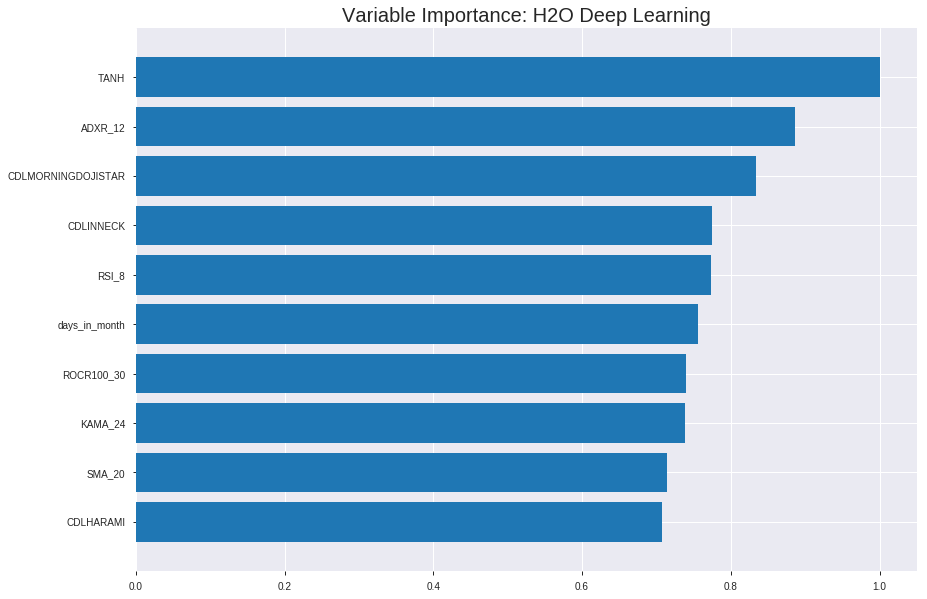

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_175332


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24381487054592657
RMSE: 0.49377613403841886
LogLoss: 0.6814259053363676
Mean Per-Class Error: 0.4345433526613569
AUC: 0.5889138987322656
pr_auc: 0.6033654866021747
Gini: 0.17782779746453126
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33898038910832895: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      89   777   0.8972   (777.0/866.0)
1      22   865   0.0248   (22.0/887.0)
Total  111  1642  0.4558   (799.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33898      0.684065  323
max f2                       0.188852     0.83792   373
max f0point5                 0.417464     0.58293   275
max accuracy                 0.565938     0.562464  186
max precision                0.999962     1         0
max recall                   0.0856054    1         398
max specificity              0.999962     1         0
max absolute_mcc             0.33898      0.160064  323
max min_per_class_accuracy   0.498641     0.365276  225
max mean_per_class_accuracy  0.565938     0.565457  186

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.934739           1.97632   1.97632            1                0.975335  1                           0.975335            0.0202931       0.0202931                  97.6325   97.6325
    2        0.0205362                   0.87168            1.53714   1.75673            0.777778         0.891017  0.888889                    0.933176            0.0157835       0.0360767                  53.7141   75.6733
    3        0.0302339                   0.847766           1.2788    1.60343            0.647059         0.858139  0.811321                    0.909108            0.0124014       0.048478                   27.8798   60.3433
    4        0.040502                    0.828544           1.20775   1.50312            0.611111         0.835049  0.760563                    0.890332            0.0124014       0.0608794                  20.7754   50.312
    5        0.0501997                   0.823653           1.39505   1.48224            0.705882         0.825762  0.75                        0.877858            0.0135287       0.0744081                  39.5053   48.2244
    6        0.100399                    0.771208           1.03308   1.25766            0.522727         0.798702  0.636364                    0.83828             0.0518602       0.126268                   3.30788   25.7661
    7        0.150029                    0.685685           1.36298   1.2925             0.689655         0.724226  0.653992                    0.800551            0.0676437       0.193912                   36.2983   29.2501
    8        0.200228                    0.626136           1.12291   1.24998            0.568182         0.65748   0.632479                    0.764681            0.0563698       0.250282                   12.2912   24.9983
    9        0.300057                    0.509302           1.06157   1.1873             0.537143         0.565855  0.60076                     0.698532            0.105975        0.356257                   6.15687   18.7298
    10       0.762122                    0.497717           0.971083  1.05621            0.491358         0.497812  0.534431                    0.576838            0.448703        0.804961                   -2.8917   5.62095
    11       0.799772                    0.462438           1.13788   1.06005            0.575758         0.481858  0.536377                    0.572367            0.042841        0.847802                   13.7884   6.00543
    12       0.899601                    0.363865           0.948636  1.04769            0.48             0.410574  0.53012                     0.554413            0.0947012       0.942503                   -5.13641  4.76902
    13       1                           0.0494375          0.572685  1                  0.289773         0.276678  0.50599                     0.526528            0.0574972       1                          -42.7315  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2728456561748803
RMSE: 0.522346299091781
LogLoss: 0.7484017271831858
Mean Per-Class Error: 0.46070675105485237
AUC: 0.5236222989387547
pr_auc: 0.5319882634764096
Gini: 0.04724459787750934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19900951472683334: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    234  0.9873   (234.0/237.0)
1      1    263  0.0038   (1.0/264.0)
Total  4    497  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.19901      0.691196   395
max f2                       0.164882     0.847784   399
max f0point5                 0.34543      0.589049   300
max accuracy                 0.349352     0.552894   294
max precision                0.630742     0.569231   62
max recall                   0.164882     1          399
max specificity              0.961693     0.995781   0
max absolute_mcc             0.34543      0.0912507  300
max min_per_class_accuracy   0.413611     0.506329   215
max mean_per_class_accuracy  0.349352     0.539293   294

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 45.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.811839           0.632576  0.632576           0.333333         0.867495  0.333333                    0.867495            0.00757576      0.00757576                 -36.7424  -36.7424
    2        0.0219561                   0.800509           0.759091  0.690083           0.4              0.804752  0.363636                    0.838976            0.00757576      0.0151515                  -24.0909  -30.9917
    3        0.0319361                   0.795387           1.13864   0.830256           0.6              0.796929  0.4375                      0.825836            0.0113636       0.0265152                  13.8636   -16.9744
    4        0.0419162                   0.782187           1.13864   0.90368            0.6              0.788497  0.47619                     0.816946            0.0113636       0.0378788                  13.8636   -9.63203
    5        0.0518962                   0.744474           0.759091  0.875874           0.4              0.764766  0.461538                    0.806911            0.00757576      0.0454545                  -24.0909  -12.4126
    6        0.101796                    0.651308           1.21455   1.04189            0.64             0.685895  0.54902                     0.747589            0.0606061       0.106061                   21.4545   4.18895
    7        0.151697                    0.61243            0.910909  0.998804           0.48             0.631633  0.526316                    0.709446            0.0454545       0.151515                   -8.90909  -0.119617
    8        0.201597                    0.575877           0.986818  0.995837           0.52             0.591762  0.524752                    0.680316            0.0492424       0.200758                   -1.31818  -0.416292
    9        0.301397                    0.52033            1.13864   1.04312            0.6              0.547292  0.549669                    0.636268            0.113636        0.314394                   13.8636   4.31216
    10       0.401198                    0.466685           0.948864  1.01967            0.5              0.497624  0.537313                    0.60178             0.094697        0.409091                   -5.11364  1.96744
    11       0.500998                    0.413618           0.986818  1.01313            0.52             0.43672   0.533865                    0.568899            0.0984848       0.507576                   -1.31818  1.31293
    12       0.600798                    0.367639           1.2525    1.05289            0.66             0.390744  0.554817                    0.539305            0.125           0.632576                   25.25     5.28919
    13       0.700599                    0.35791            0.948864  1.03807            0.5              0.360687  0.547009                    0.513861            0.094697        0.727273                   -5.11364  3.8073
    14       0.800399                    0.335131           0.910909  1.02222            0.48             0.349045  0.538653                    0.493311            0.0909091       0.818182                   -8.90909  2.22172
    15       0.9002                      0.300082           0.835     1.00146            0.44             0.318966  0.527716                    0.473982            0.0833333       0.901515                   -16.5     0.14614
    16       1                           0.164882           0.986818  1                  0.52             0.258032  0.526946                    0.45243  


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:53:33  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:53:33  0.437 sec   7396 obs/sec      1         1             1753       0.59011          1.49613             -0.393118      0.529127        0.497112           1.20775          0.487735                         0.641796           2.68826               -0.652407        0.518412          0.510783             0.948864           0.461078
    2019-08-27 17:53:35  1.919 sec   10901 obs/sec     10        10            17530      0.493776         0.681426            0.0246005      0.588914        0.603365           1.97632          0.45579                          0.522346           0.748402              -0.0945616       0.523622          0.531988             0.632576           0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
TANH                      1.0                    1.0                  0.0020450359106094496
ADXR_12                   0.8860735893249512     0.8860735893249512   0.001812052309612135
CDLMORNINGDOJISTAR        0.8335450887680054     0.8335450887680054   0.0017046296396427123
CDLINNECK                 0.775047779083252      0.775047779083252    0.0015850005406633496
RSI_8                     0.7734395265579224     0.7734395265579224   0.0015817116064957223
---                       ---                    ---                  ---
MACDEXT_hist              0.2438689023256302     0.2438689023256302   0.000498720662736822
BBANDS_middleband_20_1_4  0.21317699551582336    0.21317699551582336  0.00043595461114568837
DX_20                     0.1956111192703247     0.1956111192703247   0.0004000317634223222
MAVP_12_2                 0.1948736310005188     0.1948736310005188   0.00039852357342691583
NATR_30                   0.16402560472488403    0.16402560472488403  0.0003354382519218189


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6612903225806451)

('auc', 0.5638338414634146)

('logloss', 0.8185620176356371)

('mean_per_class_error', 0.4120299796747968)

('rmse', 0.5465209419797152)

('mse', 0.2986851400223953)

deeplearning prediction progress: |███████████████████████████████████████| 100%


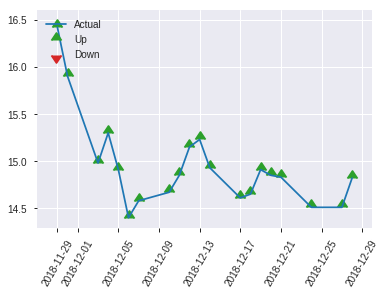


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2986851400223953
RMSE: 0.5465209419797152
LogLoss: 0.8185620176356371
Mean Per-Class Error: 0.4120299796747968
AUC: 0.5638338414634146
pr_auc: 0.5222357505218603
Gini: 0.12766768292682928
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4177205432744431: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    126  0.9844   (126.0/128.0)
1      0    123  0        (0.0/123.0)
Total  2    249  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417721     0.66129   248
max f2                       0.417721     0.82996   248
max f0point5                 0.75994      0.575139  103
max accuracy                 0.764107     0.589641  99
max precision                0.894116     1         0
max recall                   0.417721     1         248
max specificity              0.894116     1         0
max absolute_mcc             0.764107     0.179004  99
max min_per_class_accuracy   0.724461     0.554688  125
max mean_per_class_accuracy  0.75994      0.58797   103

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 70.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.88886            1.36043   1.36043            0.666667         0.892689  0.666667                    0.892689            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.881499           0.680217  1.02033            0.333333         0.884505  0.5                         0.888597            0.00813008      0.0243902                  -31.9783  2.03252
    3        0.0318725                   0.876606           1.02033   1.02033            0.5              0.878673  0.5                         0.886116            0.00813008      0.0325203                  2.03252   2.03252
    4        0.0438247                   0.874879           0         0.742055           0                0.874971  0.363636                    0.883077            0               0.0325203                  -100      -25.7945
    5        0.0517928                   0.871206           2.04065   0.941839           1                0.872859  0.461538                    0.881505            0.0162602       0.0487805                  104.065   -5.81614
    6        0.103586                    0.851711           0.941839  0.941839           0.461538         0.862175  0.461538                    0.87184             0.0487805       0.097561                   -5.81614  -5.81614
    7        0.151394                    0.836003           0.850271  0.912923           0.416667         0.842893  0.447368                    0.862699            0.0406504       0.138211                   -14.9729  -8.70774
    8        0.203187                    0.823294           1.25578   1.00032            0.615385         0.828773  0.490196                    0.854051            0.0650407       0.203252                   25.5785   0.0318827
    9        0.302789                    0.8089             1.46927   1.15458            0.72             0.816969  0.565789                    0.841853            0.146341        0.349593                   46.9268   15.4579
    10       0.40239                     0.763199           1.38764   1.21227            0.68             0.784309  0.594059                    0.827609            0.138211        0.487805                   38.7642   21.2268
    11       0.501992                    0.724461           0.734634  1.1175             0.36             0.746191  0.547619                    0.811455            0.0731707       0.560976                   -26.5366  11.7499
    12       0.601594                    0.679877           0.81626   1.06763            0.4              0.699647  0.523179                    0.792944            0.0813008       0.642276                   -18.374   6.7625
    13       0.701195                    0.646556           1.06114   1.0667             0.52             0.65976   0.522727                    0.774026            0.105691        0.747967                   6.11382   6.67036
    14       0.800797                    0.603033           0.81626   1.03555            0.4              0.624708  0.507463                    0.755454            0.0813008       0.829268                   -18.374   3.55539
    15       0.900398                    0.521386           0.897886  1.02033            0.44             0.568954  0.5                         0.734823            0.0894309       0.918699                   -10.2114  2.03252
    16       1                           0.396276           0.81626   1                  0.4              0.467586  0.49004                     0.708206    

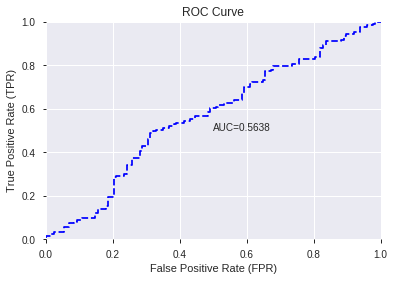

This function is available for GLM models only


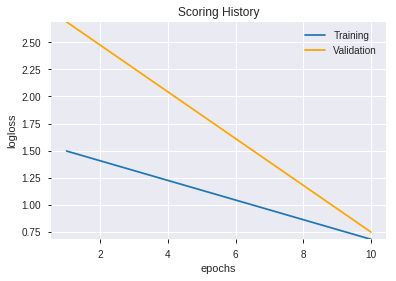

--2019-08-27 18:19:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_175332',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_175332',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_86f4'

['TANH',
 'ADXR_12',
 'CDLMORNINGDOJISTAR',
 'CDLINNECK',
 'RSI_8',
 'days_in_month',
 'ROCR100_30',
 'KAMA_24',
 'SMA_20',
 'CDLHARAMI',
 'STOCH_slowd',
 'BBANDS_lowerband_12_7_3',
 'aroondown_30',
 'CEIL',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_upperband_12_2_5',
 'SAREXT',
 'BBANDS_middleband_8_2_4',
 'BBANDS_upperband_30_0_4',
 'BBANDS_middleband_8_0_4',
 'ROCR100_8',
 'MACD_signal',
 'BBANDS_lowerband_14_1_3',
 'MACDFIX_signal_14',
 'BBANDS_upperband_24_1_3',
 'CDLGAPSIDESIDEWHITE',
 'CDLHIKKAKEMOD',
 'MA_14_5',
 'BBANDS_upperband_24_3_4',
 'BBANDS_middleband_20_6_3',
 'MOM_14',
 'BBANDS_middleband_24_7_5',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_30_1_5',
 'DX_30',
 'CCI_20',
 'BBANDS_lowerband_30_6_5',
 'CDL3LINESTRIKE',
 'BBANDS_middleband_12_1_2',
 'BBANDS_upperband_20_1_4',
 'HT_DCPERIOD',
 'BBANDS_upperband_14_1_3',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_24_1_2',
 'BBANDS_lowerband_8_2_4',
 'MAX_20',
 'BBANDS_middleband_8_2_3',
 'MINUS_DI_20',
 'SAR_0.12',
 'MIDP

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_181939_model_1  0.508575  0.69325              0.472974  0.500051  0.250051

variable  relative_importance  scaled_importance    percentage
0                     CDLDOJI         8.496238e-03           1.000000  1.552279e-02
1           CDLLONGLEGGEDDOJI         8.295670e-03           0.976393  1.515635e-02
2                        TANH         6.636173e-03           0.781072  1.212442e-02
3              CDLRICKSHAWMAN         6.443004e-03           0.758336  1.177149e-02
4        HT_PHASOR_quadrature         6.285689e-03           0.739820  1.148407e-02
...                       ...                  ...                ...           ...
1039  BBANDS_middleband_8_1_3         6.475747e-07           0.000076  1.183132e-06
1040  BBANDS_lowerband_20_7_3         4.548919e-07           0.000054  8.310963e-07
1041                   T3_8_7         4.451096e-07           0.000052  8.132237e-07
1042                MAVP_12_5         3.044943e-07           0.000036  5.563170e-07
1043   BBANDS_lowerband_8_3_4         4.828875e-08           0.000006  8.822447e-08

[1044 rows x 4 columns]

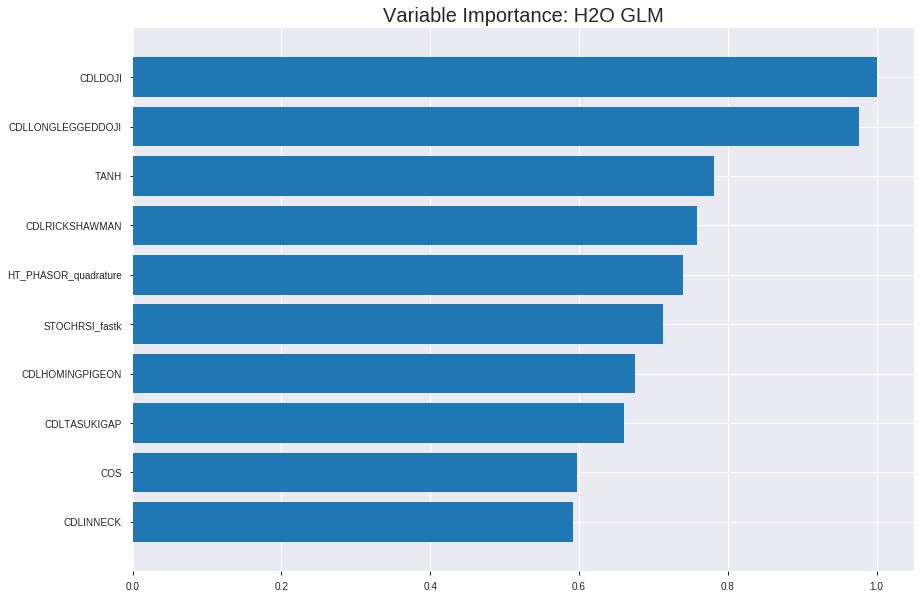

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_181939_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24713874958319001
RMSE: 0.4971305156427133
LogLoss: 0.6874146601303216
Null degrees of freedom: 1752
Residual degrees of freedom: 708
Null deviance: 2429.9224402865125
Residual deviance: 2410.0757984169077
AIC: 4500.075798416908
AUC: 0.5910677973603838
pr_auc: 0.592753235173201
Gini: 0.18213559472076768
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4744506341925878: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      62   804   0.9284   (804.0/866.0)
1      24   863   0.0271   (24.0/887.0)
Total  86   1667  0.4723   (828.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474451     0.675803  353
max f2                       0.445073     0.836792  398
max f0point5                 0.493311     0.57708   269
max accuracy                 0.508485     0.570451  179
max precision                0.578387     1         0
max recall                   0.445073     1         398
max specificity              0.578387     1         0
max absolute_mcc             0.515551     0.147342  138
max min_per_class_accuracy   0.506068     0.561443  193
max mean_per_class_accuracy  0.508485     0.570997  179

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.54787            1.42735   1.42735            0.722222         0.555008  0.722222                    0.555008            0.0146561       0.0146561                  42.7346   42.7346
    2        0.0205362                   0.543765           1.64694   1.53714            0.833333         0.545375  0.777778                    0.550191            0.0169109       0.0315671                  64.6937   53.7141
    3        0.0302339                   0.540846           1.2788    1.45428            0.647059         0.542338  0.735849                    0.547672            0.0124014       0.0439684                  27.8798   45.4277
    4        0.040502                    0.538635           1.20775   1.39178            0.611111         0.53956   0.704225                    0.545616            0.0124014       0.0563698                  20.7754   39.1778
    5        0.0501997                   0.536856           1.51131   1.41487            0.764706         0.537924  0.715909                    0.54413             0.0146561       0.0710259                  51.1307   41.4869
    6        0.100399                    0.531031           1.14537   1.28012            0.579545         0.533872  0.647727                    0.539001            0.0574972       0.128523                   14.537    28.0119
    7        0.150029                    0.52617            1.18125   1.24741            0.597701         0.528595  0.631179                    0.535559            0.0586246       0.187148                   18.1252   24.7414
    8        0.200228                    0.522353           1.19029   1.23309            0.602273         0.524219  0.623932                    0.532716            0.059752        0.2469                     19.0286   23.3091
    9        0.300057                    0.516035           1.19709   1.22111            0.605714         0.518947  0.617871                    0.528135            0.119504        0.366404                   19.7088   22.1113
    10       0.399886                    0.510792           0.937343  1.15027            0.474286         0.513393  0.582026                    0.524455            0.0935738       0.459977                   -6.26574  15.0272
    11       0.500285                    0.505961           1.01062   1.12225            0.511364         0.508494  0.567845                    0.521252            0.101466        0.561443                   1.06206   12.2246
    12       0.600114                    0.501313           0.937343  1.09149            0.474286         0.503397  0.552281                    0.518282            0.0935738       0.655017                   -6.26574  9.14873
    13       0.699943                    0.496021           0.982516  1.07595            0.497143         0.498562  0.544417                    0.515469            0.0980834       0.7531                     -1.74843  7.59453
    14       0.799772                    0.490011           0.846996  1.04737            0.428571         0.493209  0.529957                    0.512691            0.0845547       0.837655                   -15.3004  4.73675
    15       0.899601                    0.481804           0.926049  1.0339             0.468571         0.486192  0.523145                    0.50975             0.0924464       0.930101                   -7.39507  3.39048
    16       1                           0.429713           0.696205  1                  0.352273         0.472297  0.50599                     0.50599          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24893409767921365
RMSE: 0.49893295910293767
LogLoss: 0.6910131407524326
Null degrees of freedom: 500
Residual degrees of freedom: -544
Null deviance: 693.9584553730234
Residual deviance: 692.3951670339375
AIC: 2782.3951670339375
AUC: 0.5372634573583941
pr_auc: 0.5609897717899783
Gini: 0.07452691471678818
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45938894017195137: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    264  0        (0.0/264.0)
Total  0    501  0.4731   (237.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.459389     0.690196   399
max f2                       0.459389     0.847784   399
max f0point5                 0.482884     0.584135   358
max accuracy                 0.50669      0.540918   204
max precision                0.549558     1          0
max recall                   0.459389     1          399
max specificity              0.549558     1          0
max absolute_mcc             0.517114     0.0929116  116
max min_per_class_accuracy   0.506818     0.535865   203
max mean_per_class_accuracy  0.515868     0.541763   126

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.543289           1.26515   1.26515            0.666667         0.546047  0.666667                    0.546047            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.540722           1.13864   1.20764            0.6              0.541645  0.636364                    0.544046            0.0113636       0.0265152                  13.8636   20.7645
    3        0.0319361                   0.537697           1.51818   1.30469            0.8              0.539086  0.6875                      0.542496            0.0151515       0.0416667                  51.8182   30.4687
    4        0.0419162                   0.535111           0.379545  1.08442            0.2              0.536414  0.571429                    0.541048            0.00378788      0.0454545                  -62.0455  8.44156
    5        0.0518962                   0.533601           1.13864   1.09484            0.6              0.53404   0.576923                    0.5397              0.0113636       0.0568182                  13.8636   9.48427
    6        0.101796                    0.527775           1.13864   1.11631            0.6              0.529735  0.588235                    0.534815            0.0568182       0.113636                   13.8636   11.631
    7        0.151697                    0.524489           1.06273   1.09868            0.56             0.52641   0.578947                    0.53205             0.0530303       0.166667                   6.27273   9.86842
    8        0.201597                    0.52119            1.21455   1.12736            0.64             0.522945  0.594059                    0.529797            0.0606061       0.227273                   21.4545   12.7363
    9        0.301397                    0.515868           1.13864   1.1311             0.6              0.518449  0.596026                    0.526039            0.113636        0.340909                   13.8636   13.1096
    10       0.401198                    0.511746           0.797045  1.048              0.42             0.513705  0.552239                    0.522971            0.0795455       0.420455                   -20.2955  4.79986
    11       0.500998                    0.506998           1.13864   1.06605            0.6              0.509202  0.561753                    0.520228            0.113636        0.534091                   13.8636   6.6054
    12       0.600798                    0.502065           0.797045  1.02137            0.42             0.505003  0.538206                    0.517699            0.0795455       0.613636                   -20.2955  2.13682
    13       0.700599                    0.496515           1.10068   1.03267            0.58             0.499219  0.54416                     0.515066            0.109848        0.723485                   10.0682   3.26664
    14       0.800399                    0.491467           0.872955  1.01275            0.46             0.494087  0.533666                    0.512451            0.0871212       0.810606                   -12.7045  1.27522
    15       0.9002                      0.48332            1.02477   1.01408            0.54             0.487352  0.534368                    0.509668            0.102273        0.912879                   2.47727   1.40849
    16       1                           0.459383           0.872955  1                  0.46             0.475699  0.526946                    0.506278           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:19:43  0.000 sec   2            3.7       1045          1.37483           1.38203
    2019-08-27 18:19:46  2.269 sec   4            2.7       1045          1.3719            1.3825
    2019-08-27 18:19:48  4.568 sec   6            2         1045          1.36846           1.38314
    2019-08-27 18:19:50  6.894 sec   8            1.4       1045          1.36445           1.38433
    2019-08-27 18:19:53  9.279 sec   10           1         1045          1.35986           1.38583
    2019-08-27 18:19:55  11.643 sec  12           0.76      1045          1.35474           1.38775

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6666666666666667)

('auc', 0.5085746951219512)

('logloss', 0.6932500958294872)

('mean_per_class_error', 0.45582444105691056)

('rmse', 0.5000510583775637)

('mse', 0.25005106098452157)

glm prediction progress: |████████████████████████████████████████████████| 100%


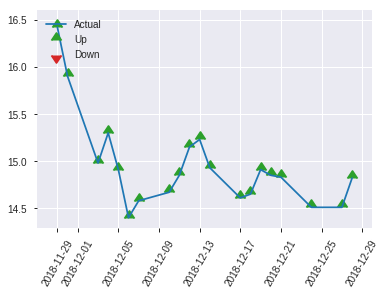


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25005106098452157
RMSE: 0.5000510583775637
LogLoss: 0.6932500958294872
Null degrees of freedom: 250
Residual degrees of freedom: -794
Null deviance: 348.11570799031966
Residual deviance: 348.01154810640253
AIC: 2438.0115481064026
AUC: 0.5085746951219512
pr_auc: 0.49273412727522314
Gini: 0.017149390243902385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4831794407187893: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    119  0.9297   (119.0/128.0)
1      2    121  0.0163   (2.0/123.0)
Total  11   240  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483179     0.666667  239
max f2                       0.476442     0.832206  246
max f0point5                 0.497364     0.562036  204
max accuracy                 0.502381     0.537849  188
max precision                0.545001     0.666667  5
max recall                   0.476442     1         246
max specificity              0.550027     0.992188  0
max absolute_mcc             0.483179     0.131999  239
max min_per_class_accuracy   0.512322     0.492188  125
max mean_per_class_accuracy  0.497364     0.544176  204

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.54734            0.680217  0.680217           0.333333         0.548562  0.333333                    0.548562            0.00813008      0.00813008                 -31.9783  -31.9783
    2        0.0239044                   0.545001           2.04065   1.36043            1                0.545818  0.666667                    0.54719             0.0243902       0.0325203                  104.065   36.0434
    3        0.0318725                   0.541479           0         1.02033            0                0.543468  0.5                         0.546259            0               0.0325203                  -100      2.03252
    4        0.0438247                   0.540235           0.680217  0.927568           0.333333         0.540696  0.454545                    0.544742            0.00813008      0.0406504                  -31.9783  -7.24316
    5        0.0517928                   0.539318           1.02033   0.941839           0.5              0.539636  0.461538                    0.543956            0.00813008      0.0487805                  2.03252   -5.81614
    6        0.103586                    0.534178           1.09881   1.02033            0.538462         0.536107  0.5                         0.540032            0.0569106       0.105691                   9.88118   2.03252
    7        0.151394                    0.531069           0.850271  0.966624           0.416667         0.532541  0.473684                    0.537666            0.0406504       0.146341                   -14.9729  -3.33761
    8        0.203187                    0.52775            1.41276   1.08034            0.692308         0.528993  0.529412                    0.535455            0.0731707       0.219512                   41.2758   8.03443
    9        0.302789                    0.522167           0.734634  0.966624           0.36             0.525439  0.473684                    0.53216             0.0731707       0.292683                   -26.5366  -3.33761
    10       0.40239                     0.517595           1.06114   0.990019           0.52             0.519854  0.485149                    0.529114            0.105691        0.398374                   6.11382   -0.998149
    11       0.501992                    0.512322           0.979512  0.987934           0.48             0.51473   0.484127                    0.52626             0.097561        0.495935                   -2.04878  -1.20661
    12       0.601594                    0.508502           0.897886  0.973025           0.44             0.510185  0.476821                    0.523599            0.0894309       0.585366                   -10.2114  -2.69746
    13       0.701195                    0.505043           1.22439   1.00873            0.6              0.506795  0.494318                    0.521212            0.121951        0.707317                   22.439    0.87306
    14       0.800797                    0.499107           1.30602   1.04571            0.64             0.502182  0.512438                    0.518845            0.130081        0.837398                   30.6016   4.57064
    15       0.900398                    0.490248           0.734634  1.0113             0.36             0.494643  0.495575                    0.516168            0.0731707       0.910569                   -26.5366  1.12958
    16       1                           0.458999           0.897886  1                  0.44             0.481687  0.49004                     0.512733

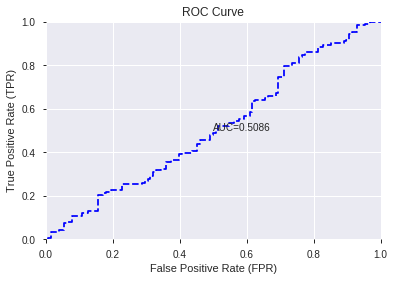

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


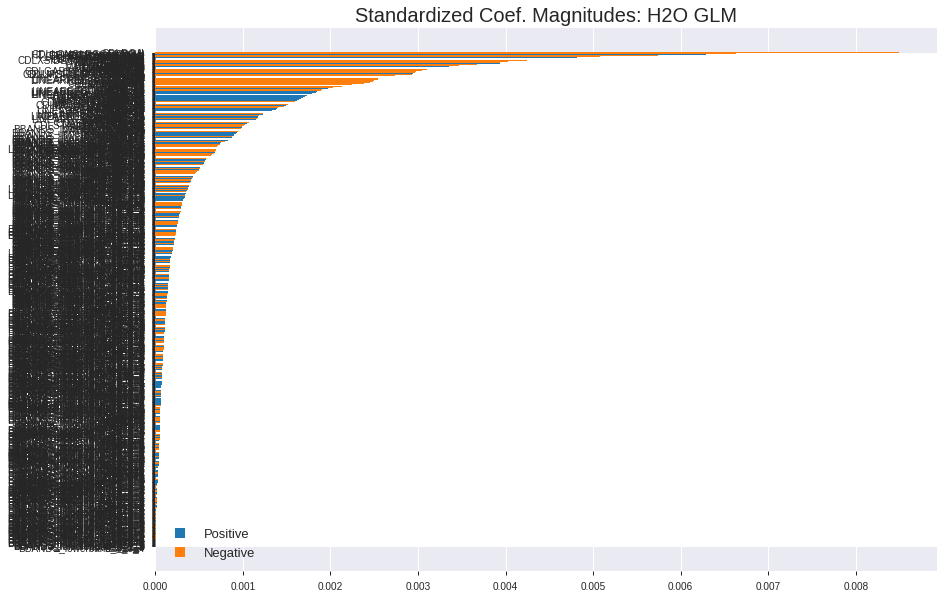

'log_likelihood'
--2019-08-27 18:20:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_181939_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_181939_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'TANH',
 'CDLRICKSHAWMAN',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'CDLTASUKIGAP',
 'COS',
 'CDLINNECK',
 'CDLHANGINGMAN',
 'day',
 'CDLHAMMER',
 'CDLHARAMICROSS',
 'CDLXSIDEGAP3METHODS',
 'STOCHRSI_fastd',
 'SAREXT',
 'MFI_12',
 'CDLPIERCING',
 'BOP',
 'MACDEXT_hist',
 'dayofweek',
 'weekday',
 'aroonup_30',
 'MFI_14',
 'HT_DCPERIOD',
 'aroonup_24',
 'CDL3OUTSIDE',
 'aroondown_30',
 'MACDEXT_signal',
 'CDLONNECK',
 'month',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'ROC_12',
 'MOM_12',
 'CDLGAPSIDESIDEWHITE',
 'CDLHARAMI',
 'CDLBREAKAWAY',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'ROC_14',
 'CDLUPSIDEGAP2CROWS',
 'CDLMORNINGDOJISTAR',
 'CDLLONGLINE',
 'dayofyear',
 'quarter',
 'BETA_20',
 'COSH',
 'SINH',
 'EXP',
 'LINEARREG_SLOPE_30',
 'LINEARREG_ANGLE_30',
 'SIN',
 'CCI_8',
 'CDLHIGHWAVE',
 'VAR_30',
 'CDLSHORTLINE',
 'week',
 'STOCHF_fastk',
 'weekofyear',
 'CDLMARUBOZU',
 'STDDEV_30',
 'ADOSC',
 'CORREL_20',
 'CMO_8',
 'RSI_

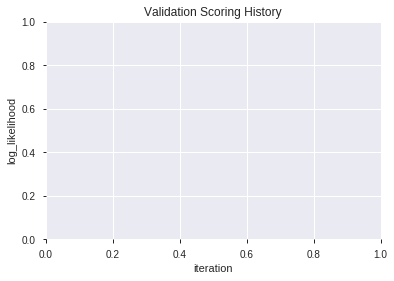

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_182026_model_3  0.560150  0.691485              0.480469  0.498878  0.248879
1  XGBoost_grid_1_AutoML_20190827_182026_model_1  0.541857  0.696276              0.492346  0.501369  0.251371
2  XGBoost_grid_1_AutoML_20190827_182026_model_6  0.537221  0.692974              0.473133  0.500112  0.250112
3               XGBoost_3_AutoML_20190827_182026  0.525470  0.700720              0.500000  0.503521  0.253533
4  XGBoost_grid_1_AutoML_20190827_182026_model_5  0.524200  0.724135              0.500000  0.513083  0.263254
5  XGBoost_grid_1_AutoML_20190827_182026_model_7  0.522802  0.710036              0.492188  0.507838  0.257899
6               XGBoost_1_AutoML_20190827_182026  0.515689  0.709384              0.484375  0.507517  0.257573
7  XGBoost_grid_1_AutoML_20190827_182026_model_2  0.515307  0.702202              0.496094  0.504328  0.254346
8               XGBoost_2_AutoML_20190827_182026  0.512767  0.700159              0.480786  0.503400  0.253412
9  XGBoost_grid_1_AutoML_20190827_182026_model_4  0.500508  0.700886              0.469068  0.503755  0.253769

variable  relative_importance  scaled_importance  percentage
0                        BOP           113.121506           1.000000    0.020048
1                        COS            91.569611           0.809480    0.016229
2                     MFI_12            88.199120           0.779685    0.015631
3             STOCHRSI_fastd            88.027969           0.778172    0.015601
4       HT_PHASOR_quadrature            81.723679           0.722442    0.014484
..                       ...                  ...                ...         ...
282   BBANDS_upperband_8_5_5             2.325548           0.020558    0.000412
283  BBANDS_upperband_20_1_3             1.735663           0.015343    0.000308
284                     High             0.927320           0.008198    0.000164
285  BBANDS_lowerband_14_6_5             0.823326           0.007278    0.000146
286              CDLLONGLINE             0.326742           0.002888    0.000058

[287 rows x 4 columns]

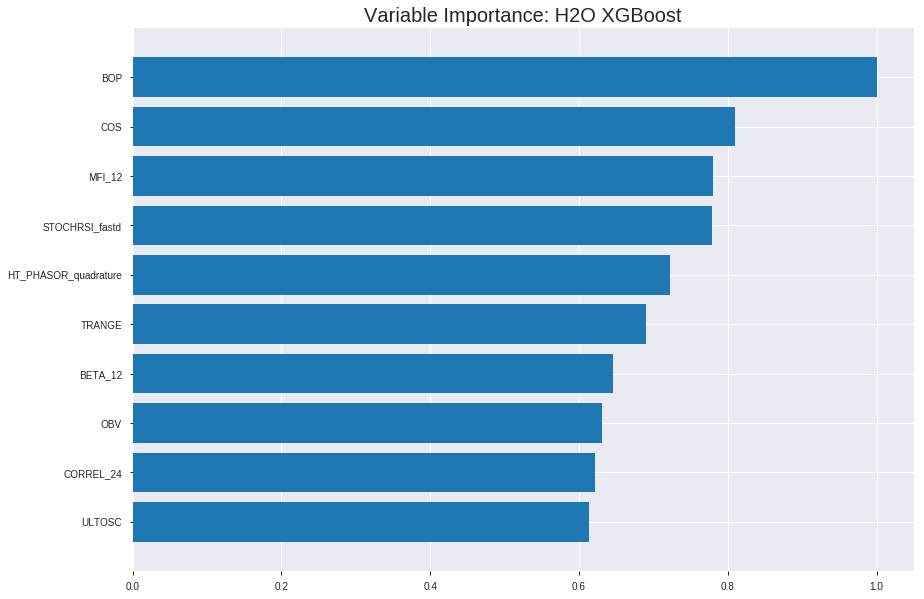

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_182026_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18144397209156565
RMSE: 0.4259624068994418
LogLoss: 0.5523853772958544
Mean Per-Class Error: 0.1328588984849155
AUC: 0.9437545401761653
pr_auc: 0.9460393862115016
Gini: 0.8875090803523307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5055069923400879: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      755  111  0.1282   (111.0/866.0)
1      122  765  0.1375   (122.0/887.0)
Total  877  876  0.1329   (233.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505507     0.867839  198
max f2                       0.456192     0.910153  250
max f0point5                 0.536123     0.895718  169
max accuracy                 0.505507     0.867085  198
max precision                0.838912     1         0
max recall                   0.391453     1         316
max specificity              0.838912     1         0
max absolute_mcc             0.505507     0.73423   198
max min_per_class_accuracy   0.504554     0.862587  199
max mean_per_class_accuracy  0.505507     0.867141  198

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.738012           1.97632    1.97632            1                0.765216  1                           0.765216            0.0202931       0.0202931                  97.6325   97.6325
    2        0.0205362                   0.714122           1.97632    1.97632            1                0.724296  1                           0.744756            0.0202931       0.0405862                  97.6325   97.6325
    3        0.0302339                   0.700461           1.97632    1.97632            1                0.705842  1                           0.732274            0.0191657       0.059752                   97.6325   97.6325
    4        0.040502                    0.690436           1.97632    1.97632            1                0.695433  1                           0.722934            0.0202931       0.0800451                  97.6325   97.6325
    5        0.0501997                   0.681446           1.97632    1.97632            1                0.686204  1                           0.715838            0.0191657       0.0992108                  97.6325   97.6325
    6        0.100399                    0.645944           1.95387    1.9651             0.988636         0.661994  0.994318                    0.688916            0.0980834       0.197294                   95.3866   96.5096
    7        0.150029                    0.62338            1.95361    1.9613             0.988506         0.635006  0.992395                    0.671083            0.096956        0.29425                    95.3608   96.1296
    8        0.200228                    0.607762           1.90895    1.94817            0.965909         0.614994  0.985755                    0.657021            0.0958286       0.390079                   90.895    94.8172
    9        0.300057                    0.576824           1.89727    1.93124            0.96             0.592556  0.977186                    0.635573            0.189402        0.579481                   89.7272   93.1237
    10       0.399886                    0.542466           1.64882    1.86073            0.834286         0.561277  0.941512                    0.617026            0.1646          0.744081                   64.8819   86.0734
    11       0.500285                    0.504946           1.17906    1.72393            0.596591         0.522492  0.872292                    0.598054            0.118377        0.862458                   17.9057   72.3932
    12       0.600114                    0.473494           0.767943   1.5649             0.388571         0.490703  0.791825                    0.580196            0.0766629       0.939121                   -23.2057  56.4903
    13       0.699943                    0.444236           0.372678   1.39486            0.188571         0.459044  0.705786                    0.562917            0.0372041       0.976325                   -62.7322  39.4863
    14       0.799772                    0.410285           0.169399   1.2419             0.0857143        0.426613  0.628388                    0.545903            0.0169109       0.993236                   -83.0601  24.1899
    15       0.899601                    0.36919            0.0677597  1.1116             0.0342857        0.389609  0.56246                     0.528559            0.00676437      1                          -93.224   11.1604
    16       1                           0.191635           0          1                  0                0.332765  0.50599                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2546350569202901
RMSE: 0.5046137700462504
LogLoss: 0.7025780603905329
Mean Per-Class Error: 0.4699846566935174
AUC: 0.5006153305203938
pr_auc: 0.5238044259625726
Gini: 0.0012306610407875063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3764801323413849: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   213  0.8987   (213.0/237.0)
1      11   253  0.0417   (11.0/264.0)
Total  35   466  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37648      0.693151  368
max f2                       0.30659      0.848329  398
max f0point5                 0.37648      0.594455  368
max accuracy                 0.378028     0.552894  366
max precision                0.698883     1         0
max recall                   0.30659      1         398
max specificity              0.698883     1         0
max absolute_mcc             0.37648      0.116732  368
max min_per_class_accuracy   0.488872     0.493671  199
max mean_per_class_accuracy  0.378028     0.530015  366

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.669383           1.26515   1.26515            0.666667         0.681308  0.666667                    0.681308            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.651133           0.379545  0.862603           0.2              0.65668   0.454545                    0.670113            0.00378788      0.0189394                  -62.0455  -13.7397
    3        0.0319361                   0.635551           1.89773   1.18608            1                0.640258  0.625                       0.660783            0.0189394       0.0378788                  89.7727   18.608
    4        0.0419162                   0.625314           1.13864   1.17478            0.6              0.627692  0.619048                    0.652905            0.0113636       0.0492424                  13.8636   17.4784
    5        0.0518962                   0.613836           0.379545  1.02185            0.2              0.614563  0.538462                    0.645531            0.00378788      0.0530303                  -62.0455  2.18531
    6        0.101796                    0.589524           1.06273   1.04189            0.56             0.60038   0.54902                     0.623398            0.0530303       0.106061                   6.27273   4.18895
    7        0.151697                    0.56558            0.759091  0.948864           0.4              0.574343  0.5                         0.607261            0.0378788       0.143939                   -24.0909  -5.11364
    8        0.201597                    0.553068           1.13864   0.995837           0.6              0.559337  0.524752                    0.595399            0.0568182       0.200758                   13.8636   -0.416292
    9        0.301397                    0.524508           0.986818  0.992851           0.52             0.537454  0.523179                    0.576212            0.0984848       0.299242                   -1.31818  -0.714931
    10       0.401198                    0.507077           0.948864  0.981909           0.5              0.516297  0.517413                    0.561308            0.094697        0.393939                   -5.11364  -1.80914
    11       0.500998                    0.488872           1.02477   0.990447           0.54             0.498294  0.521912                    0.548755            0.102273        0.496212                   2.47727   -0.95527
    12       0.600798                    0.471087           0.797045  0.958321           0.42             0.480343  0.504983                    0.537391            0.0795455       0.575758                   -20.2955  -4.16793
    13       0.700599                    0.455463           1.21455   0.99482            0.64             0.464089  0.524217                    0.526949            0.121212        0.69697                    21.4545   -0.518001
    14       0.800399                    0.429387           1.17659   1.01748            0.62             0.444391  0.53616                     0.516655            0.117424        0.814394                   17.6591   1.74847
    15       0.9002                      0.393962           1.06273   1.0225             0.56             0.414533  0.538803                    0.505333            0.106061        0.920455                   6.27273   2.25005
    16       1                           0.27459            0.797045  1                  0.42             0.35877   0.526946                    0.49070


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:20:52  7.956 sec   0                  0.5              0.693147            0.5             0                  1                0.49401                          0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 18:20:53  9.253 sec   5                  0.489855         0.673019            0.751902        0.746553           1.97632          0.324016                         0.501214           0.69558               0.482483          0.517928             1.26515            0.469062
    2019-08-27 18:20:54  9.666 sec   10                 0.479275         0.652379            0.842848        0.839428           1.86653          0.25328                          0.503222           0.69964               0.468267          0.503514             1.26515            0.471058
    2019-08-27 18:20:54  10.069 sec  15                 0.472366         0.639023            0.861178        0.859073           1.97632          0.224758                         0.503233           0.699654              0.47028           0.511376             1.26515            0.467066
    2019-08-27 18:20:54  10.471 sec  20                 0.465866         0.626574            0.874834        0.874234           1.97632          0.211637                         0.503284           0.699744              0.484825          0.513767             1.26515            0.463074
    2019-08-27 18:20:55  10.894 sec  25                 0.459793         0.615009            0.887049        0.888523           1.97632          0.192242                         0.503866           0.700903              0.479534          0.522315             1.89773            0.463074
    2019-08-27 18:20:55  11.308 sec  30                 0.45206          0.600407            0.903147        0.905605           1.97632          0.183685                         0.505381           0.704009              0.470009          0.521731             1.58144            0.461078
    2019-08-27 18:20:56  11.733 sec  35                 0.444586         0.586548            0.918775        0.921455           1.97632          0.165431                         0.504552           0.702452              0.495956          0.535471             1.26515            0.471058
    2019-08-27 18:20:56  12.163 sec  40                 0.439137         0.576455            0.926616        0.92978            1.97632          0.150029                         0.50465            0.702676              0.497922          0.531841             1.26515            0.471058
    2019-08-27 18:20:56  12.585 sec  45                 0.432663         0.564605            0.93708         0.940237           1.97632          0.142042                         0.504929           0.703235              0.49845           0.526105             0.948864           0.471058
    2019-08-27 18:20:57  12.998 sec  50                 0.425962         0.552385            0.943755        0.946039           1.97632          0.132915                         0.504614           0.702578              0.500615          0.523804             1.26515            0.447106

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      113.12150573730469     1.0                    0.0200480814265276
COS                      91.56961059570312      0.8094801249229281     0.016228523457610597
MFI_12                   88.1991195678711       0.779684808763867      0.015631184533124606
STOCHRSI_fastd           88.02796936035156      0.7781718320190474     0.015600852252148018
HT_PHASOR_quadrature     81.72367858886719      0.7224415733879038     0.01448356748918941
---                      ---                    ---                    ---
BBANDS_upperband_8_5_5   2.3255481719970703     0.020557966912123252   0.0004121477946181071
BBANDS_upperband_20_1_3  1.7356634140014648     0.0153433549411205     0.0003076048292156984
High                     0.9273204803466797     0.008197561324016856   0.00016434537692284332
BBANDS_lowerband_14_6_5  0.8233261108398438     0.007278245683467163   0.0001459148621044227
CDLLONGLINE              0.32674217224121094    0.0028884178133199954  5.7907235515272066e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6666666666666666)

('auc', 0.5601498983739838)

('logloss', 0.6914848930738736)

('mean_per_class_error', 0.43051321138211385)

('rmse', 0.49887815154122317)

('mse', 0.24887941008518763)

xgboost prediction progress: |████████████████████████████████████████████| 100%


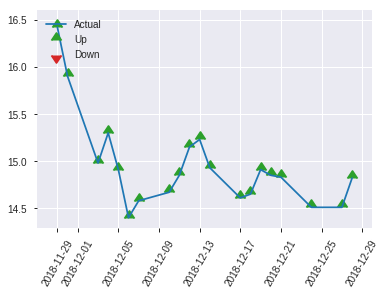


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24887941008518763
RMSE: 0.49887815154122317
LogLoss: 0.6914848930738736
Mean Per-Class Error: 0.43051321138211385
AUC: 0.5601498983739838
pr_auc: 0.5465765833029058
Gini: 0.12029979674796754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32634371519088745: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    123  0.9609   (123.0/128.0)
1      0    123  0        (0.0/123.0)
Total  5    246  0.49     (123.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326344     0.666667  245
max f2                       0.326344     0.833333  245
max f0point5                 0.372195     0.559737  234
max accuracy                 0.553862     0.573705  71
max precision                0.83578      1         0
max recall                   0.326344     1         245
max specificity              0.83578      1         0
max absolute_mcc             0.627798     0.169253  28
max min_per_class_accuracy   0.51336      0.552846  124
max mean_per_class_accuracy  0.553862     0.569487  71

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.772133           0.680217  0.680217           0.333333         0.809414  0.333333                    0.809414            0.00813008      0.00813008                 -31.9783  -31.9783
    2        0.0239044                   0.733182           0.680217  0.680217           0.333333         0.746542  0.333333                    0.777978            0.00813008      0.0162602                  -31.9783  -31.9783
    3        0.0318725                   0.719953           2.04065   1.02033            1                0.726985  0.5                         0.76523             0.0162602       0.0325203                  104.065   2.03252
    4        0.0438247                   0.690484           2.04065   1.2986             1                0.702731  0.636364                    0.748185            0.0243902       0.0569106                  104.065   29.8596
    5        0.0517928                   0.671923           1.02033   1.25578            0.5              0.678408  0.615385                    0.73745             0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.632045           1.56973   1.41276            0.769231         0.647392  0.692308                    0.692421            0.0813008       0.146341                   56.9731   41.2758
    7        0.151394                    0.600811           1.02033   1.28883            0.5              0.618745  0.631579                    0.669155            0.0487805       0.195122                   2.03252   28.8832
    8        0.203187                    0.57733            1.09881   1.2404             0.538462         0.588211  0.607843                    0.648522            0.0569106       0.252033                   9.88118   24.0395
    9        0.302789                    0.549978           1.06114   1.18143            0.52             0.562631  0.578947                    0.620269            0.105691        0.357724                   6.11382   18.1429
    10       0.40239                     0.531051           0.979512  1.13145            0.48             0.53972   0.554455                    0.600331            0.097561        0.455285                   -2.04878  13.145
    11       0.501992                    0.513318           0.979512  1.1013             0.48             0.520758  0.539683                    0.584542            0.097561        0.552846                   -2.04878  10.1303
    12       0.601594                    0.488986           0.81626   1.05411            0.4              0.50093   0.516556                    0.570699            0.0813008       0.634146                   -18.374   5.41108
    13       0.701195                    0.458057           0.897886  1.03192            0.44             0.474763  0.505682                    0.557072            0.0894309       0.723577                   -10.2114  3.19198
    14       0.800797                    0.427182           0.81626   1.0051             0.4              0.443584  0.492537                    0.542957            0.0813008       0.804878                   -18.374   0.509647
    15       0.900398                    0.392595           1.14276   1.02033            0.56             0.413412  0.5                         0.528626            0.113821        0.918699                   14.2764   2.03252
    16       1                           0.295053           0.81626   1                  0.4              0.35567   0.49004                     0.5114         

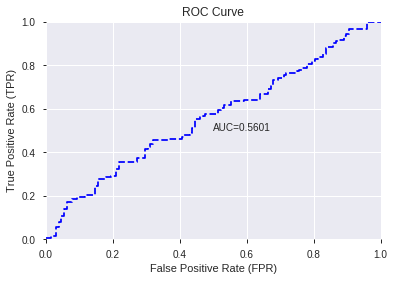

This function is available for GLM models only


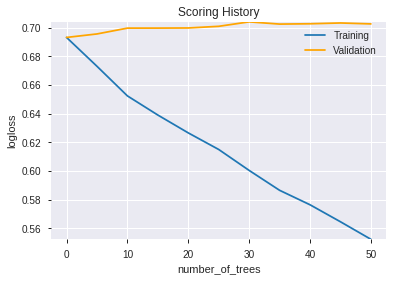

--2019-08-27 18:21:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_182026_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_182026_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'COS',
 'MFI_12',
 'STOCHRSI_fastd',
 'HT_PHASOR_quadrature',
 'TRANGE',
 'BETA_12',
 'OBV',
 'CORREL_24',
 'ULTOSC',
 'CORREL_8',
 'ADOSC',
 'DX_8',
 'MFI_14',
 'CCI_8',
 'MFI_20',
 'HT_DCPERIOD',
 'WILLR_12',
 'CORREL_14',
 'SIN',
 'Volume',
 'STOCHF_fastk',
 'SAREXT',
 'HT_PHASOR_inphase',
 'MINUS_DI_8',
 'MACDEXT_hist',
 'STOCH_slowd',
 'STOCHRSI_fastk',
 'BETA_8',
 'CORREL_12',
 'CDLDOJI',
 'WILLR_24',
 'MINUS_DM_12',
 'ADX_24',
 'aroonup_30',
 'ADX_8',
 'LINEARREG_SLOPE_8',
 'CORREL_20',
 'MOM_12',
 'STOCH_slowk',
 'AD',
 'MACDFIX_signal_24',
 'MFI_8',
 'BETA_20',
 'MACDEXT_signal',
 'NATR_20',
 'MOM_8',
 'ROC_20',
 'PLUS_DM_8',
 'MFI_30',
 'DX_24',
 'CMO_8',
 'PLUS_DI_24',
 'DX_20',
 'ADXR_12',
 'CORREL_30',
 'SUB',
 'MACDFIX_8',
 'PLUS_DI_20',
 'WILLR_14',
 'DIV',
 'DX_12',
 'BBANDS_upperband_14_6_5',
 'MOM_24',
 'STDDEV_12',
 'MACDFIX_hist_12',
 'STDDEV_30',
 'AROONOSC_20',
 'ADXR_8',
 'DX_14',
 'ATR_20',
 'PLUS_DI_14',
 'BETA_30',
 'TAN',
 'ROCP_14',
 'day',
 'DX_30'

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

59

['BBANDS_middleband_14_1_5',
 'MA_14_3',
 'BBANDS_middleband_20_3_5',
 'BOP',
 'ADX_8',
 'CCI_8',
 'MFI_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'RSI_8',
 'WILLR_8',
 'aroonup_12',
 'AROONOSC_12',
 'CCI_12',
 'CMO_12',
 'MACDFIX_hist_12',
 'MINUS_DI_12',
 'MOM_12',
 'ROC_12',
 'ROCR100_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'MOM_14',
 'ROCP_14',
 'ROCR100_14',
 'aroonup_20',
 'AROONOSC_20',
 'PLUS_DI_20',
 'ROCP_20',
 'aroondown_24',
 'ROCP_24',
 'ROCR_24',
 'RSI_24',
 'WILLR_24',
 'aroondown_30',
 'CCI_30',
 'MFI_30',
 'MOM_30',
 'MACD_hist',
 'MACDEXT',
 'MACDEXT_hist',
 'PPO',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'AD',
 'NATR_8',
 'NATR_24',
 'TRANGE',
 'CDLSPINNINGTOP',
 'LINEARREG_ANGLE_8',
 'STDDEV_8',
 'BETA_12',
 'CORREL_12',
 'LINEARREG_SLOPE_12',
 'BETA_14',
 'CORREL_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_182257_model_8  0.571710  0.695777              0.484375  0.501318  0.251319
1  DeepLearning_grid_1_AutoML_20190827_182257_model_3  0.571202  0.767790              0.476880  0.525842  0.276510
2  DeepLearning_grid_1_AutoML_20190827_182257_model_6  0.563580  0.711533              0.492188  0.508913  0.258993
3  DeepLearning_grid_1_AutoML_20190827_182257_model_4  0.557927  0.784131              0.438135  0.533959  0.285112
4  DeepLearning_grid_1_AutoML_20190827_182257_model_9  0.547510  0.689763              0.484375  0.498318  0.248321
5  DeepLearning_grid_1_AutoML_20190827_182257_model_1  0.543890  0.894855              0.496094  0.558267  0.311662
6               DeepLearning_1_AutoML_20190827_182257  0.538364  0.786198              0.500000  0.534340  0.285519
7  DeepLearning_grid_1_AutoML_20190827_182257_model_5  0.519881  0.710199              0.492346  0.508239  0.258307
8  DeepLearning_grid_1_AutoML_20190827_182257_model_7  0.513021  0.746193              0.500000  0.520248  0.270658
9  DeepLearning_grid_1_AutoML_20190827_182257_model_2  0.492632  0.760572              0.496094  0.527838  0.278613

variable  relative_importance  scaled_importance  percentage
0                  CORREL_12             1.000000           1.000000    0.019294
1                        BOP             0.993800           0.993800    0.019174
2               MACDEXT_hist             0.974437           0.974437    0.018801
3                    BETA_14             0.943273           0.943273    0.018199
4   BBANDS_middleband_14_1_5             0.942388           0.942388    0.018182
5                    BETA_12             0.936355           0.936355    0.018066
6               aroondown_24             0.932438           0.932438    0.017990
7                    NATR_24             0.931370           0.931370    0.017970
8                        PPO             0.930625           0.930625    0.017955
9                 aroonup_20             0.926123           0.926123    0.017869
10            STOCHRSI_fastd             0.925585           0.925585    0.017858
11                   MA_14_3             0.924943           0.924943    0.017846
12                     ADX_8             0.922245           0.922245    0.017794
13  BBANDS_middleband_20_3_5             0.922165           0.922165    0.017792
14               AROONOSC_20             0.915081           0.915081    0.017655
15                     CCI_8             0.913357           0.913357    0.017622
16                    TRANGE             0.912846           0.912846    0.017612
17                 CORREL_14             0.912664           0.912664    0.017609
18                        AD             0.909607           0.909607    0.017550
19              aroondown_14             0.904285           0.904285    0.017447
20                   MACDEXT             0.903753           0.903753    0.017437
21              aroondown_30             0.903189           0.903189    0.017426
22              STOCHF_fastk             0.897743           0.897743    0.017321
23                  STDDEV_8             0.893725           0.893725    0.017243
24                  WILLR_12             0.891983           0.891983    0.017210
25           MACDFIX_hist_12             0.884849           0.884849    0.017072
26                aroonup_14             0.883138           0.883138    0.017039
27                    NATR_8             0.875646           0.875646    0.016895
28                PLUS_DI_20             0.873476           0.873476    0.016853
29                MINUS_DI_8             0.866657           0.866657    0.016721
30                    MFI_30             0.857599           0.857599    0.016546
31                     RSI_8             0.856933           0.856933    0.016534
32                   ROCP_24             0.855911           0.855911    0.016514
33                    CCI_12             0.855254           0.855254    0.016501
34                 PLUS_DM_8             0.854069           0.854069    0.016478
35               AROONOSC_12             0.853025           0.853025    0.016458
36                    RSI_24             0.851384           0.851384    0.016427
37                ROCR100_12             0.851293           0.851293    0.016425
38                ROCR100_14             0.851108           0.851108    0.016421
39            CDLSPINNINGTOP             0.849647           0.849647    0.016393
40                   ROCP_14             0.849631           0.849631    0.016393
41                    CCI_30             0.847168           0.847168    0.016345
42                   ROCR_24             0.843986           0.843986    0.016284
43                    MOM_14             0.840641           0.840641    0.016219
44                   WILLR_8             0.838767           0.838767    0.016183
45                  WILLR_24             0.836860           0.836860    0.016146
46                 MACD_hist             0.833738           0.833738    0.016086
47                     MFI_8             0.832765           0.832765    0.016067
48               STOCH_slowd             0.831582  

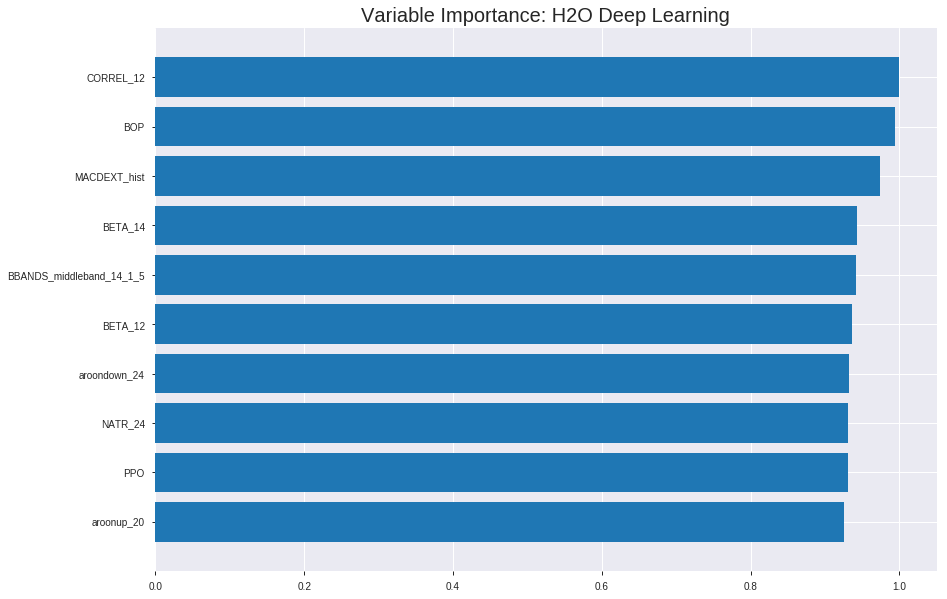

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_182257_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25067164951930215
RMSE: 0.5006711990111895
LogLoss: 0.6944905222613209
Mean Per-Class Error: 0.4679356160709869
AUC: 0.5345756383585326
pr_auc: 0.5394069506340102
Gini: 0.06915127671706522
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5314831207592792: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    866   1        (866.0/866.0)
1      0    887   0        (0.0/887.0)
Total  0    1753  0.494    (866.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.531483     0.67197   399
max f2                       0.531483     0.836635  399
max f0point5                 0.534219     0.566312  347
max accuracy                 0.535701     0.53166   258
max precision                0.589188     1         0
max recall                   0.531483     1         399
max specificity              0.589188     1         0
max absolute_mcc             0.581243     0.068195  9
max min_per_class_accuracy   0.535597     0.524249  264
max mean_per_class_accuracy  0.535701     0.532064  258

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 53.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.578637           1.64694   1.64694            0.833333         0.581905  0.833333                    0.581905            0.0169109       0.0169109                  64.6937   64.6937
    2        0.0205362                   0.569574           0.878367  1.26265            0.444444         0.574001  0.638889                    0.577953            0.00901917      0.0259301                  -12.1633  26.2652
    3        0.0302339                   0.563441           0.813781  1.11867            0.411765         0.56653   0.566038                    0.574289            0.00789177      0.0338219                  -18.6219  11.8674
    4        0.040502                    0.558286           1.42735   1.19693            0.722222         0.56137   0.605634                    0.571014            0.0146561       0.048478                   42.7346   19.6929
    5        0.0501997                   0.554026           1.16254   1.19029            0.588235         0.555985  0.602273                    0.568111            0.011274        0.059752                   16.2544   19.0286
    6        0.100399                    0.540562           0.898329  1.04431            0.454545         0.546765  0.528409                    0.557438            0.0450958       0.104848                   -10.1671  4.43079
    7        0.150029                    0.537084           1.02224   1.03701            0.517241         0.537722  0.524715                    0.550916            0.0507328       0.155581                   2.22369   3.70069
    8        0.200228                    0.536688           1.16783   1.06981            0.590909         0.536872  0.541311                    0.547395            0.0586246       0.214205                   16.7828   6.98054
    9        0.300057                    0.536248           1.09545   1.07834            0.554286         0.536471  0.545627                    0.54376             0.109357        0.323563                   9.54485   7.83369
    10       0.399886                    0.535913           1.03898   1.06851            0.525714         0.536079  0.540656                    0.541843            0.10372         0.427283                   3.89821   6.85122
    11       0.500285                    0.535595           0.976933  1.05013            0.494318         0.535744  0.531357                    0.540619            0.0980834       0.525366                   -2.30668  5.01338
    12       0.600114                    0.535271           1.0164    1.04452            0.514286         0.535426  0.528517                    0.539755            0.101466        0.626832                   1.63956   4.45214
    13       0.699943                    0.534966           0.903463  1.0244             0.457143         0.535122  0.518337                    0.539094            0.0901917       0.717024                   -9.65373  2.4403
    14       0.799772                    0.534674           0.948636  1.01495            0.48             0.534825  0.513552                    0.538561            0.0947012       0.811725                   -5.13641  1.49456
    15       0.899601                    0.534237           1.05028   1.01887            0.531429         0.53448   0.515536                    0.538108            0.104848        0.916573                   5.02754   1.88662
    16       1                           0.531483           0.830955  1                  0.420455         0.533689  0.50599                     0.537665          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2490265065821521
RMSE: 0.49902555704307583
LogLoss: 0.6911927264505873
Mean Per-Class Error: 0.4661967779056386
AUC: 0.5192510548523207
pr_auc: 0.5503194130704766
Gini: 0.03850210970464141
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5338703732760328: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    233  0.9831   (233.0/237.0)
1      2    262  0.0076   (2.0/264.0)
Total  6    495  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.53387      0.690382   393
max f2                       0.532516     0.847784   399
max f0point5                 0.534641     0.588374   364
max accuracy                 0.534641     0.542914   364
max precision                0.570767     0.857143   6
max recall                   0.532516     1          399
max specificity              0.579801     0.995781   0
max absolute_mcc             0.548763     0.0932234  22
max min_per_class_accuracy   0.535937     0.503788   204
max mean_per_class_accuracy  0.535768     0.533803   239

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 53.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.576205           1.58144   1.58144            0.833333         0.578394  0.833333                    0.578394            0.0189394       0.0189394                  58.1439   58.1439
    2        0.0219561                   0.559658           0.759091  1.20764            0.4              0.566756  0.636364                    0.573104            0.00757576      0.0265152                  -24.0909  20.7645
    3        0.0319361                   0.553787           1.13864   1.18608            0.6              0.555206  0.625                       0.567511            0.0113636       0.0378788                  13.8636   18.608
    4        0.0419162                   0.5505             1.89773   1.35552            1                0.551769  0.714286                    0.563763            0.0189394       0.0568182                  89.7727   35.5519
    5        0.0518962                   0.546852           1.13864   1.31381            0.6              0.548115  0.692308                    0.560753            0.0113636       0.0681818                  13.8636   31.3811
    6        0.101796                    0.537467           0.835     1.0791             0.44             0.541014  0.568627                    0.551077            0.0416667       0.109848                   -16.5     7.90998
    7        0.151697                    0.536983           1.06273   1.07371            0.56             0.537206  0.565789                    0.546514            0.0530303       0.162879                   6.27273   7.37141
    8        0.201597                    0.536754           0.910909  1.03342            0.48             0.536858  0.544554                    0.544124            0.0454545       0.208333                   -8.90909  3.34158
    9        0.301397                    0.53637            1.10068   1.05569            0.58             0.536562  0.556291                    0.54162             0.109848        0.318182                   10.0682   5.56893
    10       0.401198                    0.536126           0.759091  0.981909           0.4              0.536247  0.517413                    0.540284            0.0757576       0.393939                   -24.0909  -1.80914
    11       0.500998                    0.535934           1.10068   1.00557            0.58             0.536021  0.52988                     0.539434            0.109848        0.503788                   10.0682   0.556863
    12       0.600798                    0.53573            1.29045   1.05289            0.68             0.535842  0.554817                    0.538838            0.128788        0.632576                   29.0455   5.28919
    13       0.700599                    0.535527           0.797045  1.01645            0.42             0.535639  0.535613                    0.538382            0.0795455       0.712121                   -20.2955  1.64465
    14       0.800399                    0.535167           0.910909  1.00329            0.48             0.535325  0.528678                    0.538001            0.0909091       0.80303                    -8.90909  0.328724
    15       0.9002                      0.534787           1.13864   1.01829            0.6              0.534977  0.536585                    0.537666            0.113636        0.916667                   13.8636   1.82927
    16       1                           0.532516           0.835     1                  0.44             0.534237  0.526946                    0.537323       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:28:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:28:08  1 min 22.933 sec  610 obs/sec       0.510553  1             895        0.621294         1.12685             -0.544246      0.498084        0.50032            0.988162         0.49401                          0.639382           1.189                 -0.640001        0.426448          0.485816             0.948864           0.473054
    2019-08-27 18:28:19  1 min 33.183 sec  1021 obs/sec      6.24872   12            10954      0.500693         0.694535            -0.0029176     0.524537        0.517985           0.658775         0.49401                          0.501539           0.696232              -0.00909611      0.547492          0.582961             1.15514            0.471058
    2019-08-27 18:28:29  1 min 43.548 sec  1357 obs/sec      15.5596   30            27276      0.500671         0.694491            -0.00283051    0.534576        0.539407           1.64694          0.49401                          0.499026           0.691193              0.000992485      0.519251          0.550319             1.58144            0.469062
    2019-08-27 18:28:39  1 min 53.745 sec  1523 obs/sec      25.4415   49            44599      0.499968         0.693082            -1.38896e-05   0.504205        0.526971           1.20775          0.49401                          0.499809           0.692766              -0.00214765      0.492169          0.49746              1.26515            0.473054
    2019-08-27 18:28:50  2 min  4.133 sec  1668 obs/sec      36.7427   71            64410      0.50228          0.697733            -0.00928526    0.506911        0.540041           1.00642          0.487735                         0.504066           0.701337              -0.0192916       0.488269          0.265562             0.992775           0.473054
    2019-08-27 18:29:00  2 min 14.792 sec  1806 obs/sec      49.7536   96            87218      0.499322         0.691784            0.00256729     0.525786        0.560174           0.988162         0.475185                         0.499294           0.691736              -8.23307e-05     0.500288          0.476337             0.316288           0.469062
    2019-08-27 18:29:10  2 min 24.939 sec  1915 obs/sec      62.7427   121           109988     0.496459         0.685125            0.0139716      0.523496        0.577371           1.31755          0.471192                         0.501021           0.695076              -0.00701356      0.505562          0.406606             1.01183            0.46507
    2019-08-27 18:29:11  2 min 25.973 sec  1914 obs/sec      62.7427   121           109988     0.500671         0.694491            -0.00283051    0.534576        0.539407           1.64694          0.49401                          0.499026           0.691193              0.000992485      0.519251          0.550319             1.58144            0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CORREL_12                 1.0                    1.0                  0.019293901560632865
BOP                       0.9937995672225952     0.9937995672225952   0.019174271020992294
MACDEXT_hist              0.9744365215301514     0.9744365215301514   0.018800682323488246
BETA_14                   0.9432725310325623     0.9432725310325623   0.018199407358591265
BBANDS_middleband_14_1_5  0.9423883557319641     0.9423883557319641   0.01818234816737918
---                       ---                    ---                  ---
MOM_12                    0.818501353263855      0.818501353263855    0.015792084537117602
MINUS_DI_12               0.8179945349693298     0.8179945349693298   0.015782306034833906
LINEARREG_ANGLE_8         0.8177974224090576     0.8177974224090576   0.01577850296449965
PLUS_DI_8                 0.8109648823738098     0.8109648823738098   0.015646676609650495
ROC_12                    0.7997760772705078     0.7997760772705078   0.015430800905406281


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6648648648648648)

('auc', 0.5717098577235772)

('logloss', 0.695777351101466)

('mean_per_class_error', 0.4133003048780488)

('rmse', 0.5013176462446601)

('mse', 0.2513193824362862)

deeplearning prediction progress: |███████████████████████████████████████| 100%


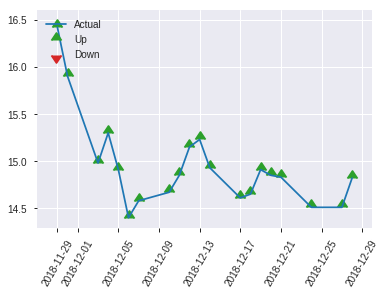


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2513193824362862
RMSE: 0.5013176462446601
LogLoss: 0.695777351101466
Mean Per-Class Error: 0.4133003048780488
AUC: 0.5717098577235772
pr_auc: 0.5646104574496706
Gini: 0.14341971544715437
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5349911879966244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    124  0.9688   (124.0/128.0)
1      0    123  0        (0.0/123.0)
Total  4    247  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534991     0.664865  246
max f2                       0.534991     0.832206  246
max f0point5                 0.537411     0.568421  87
max accuracy                 0.537411     0.589641  87
max precision                0.583029     1         0
max recall                   0.534991     1         246
max specificity              0.583029     1         0
max absolute_mcc             0.537411     0.181664  87
max min_per_class_accuracy   0.537043     0.544715  118
max mean_per_class_accuracy  0.537411     0.5867    87

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 54.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.578692           2.04065   2.04065            1                0.581763  1                           0.581763            0.0243902       0.0243902                  104.065   104.065
    2        0.0239044                   0.571455           0.680217  1.36043            0.333333         0.573631  0.666667                    0.577697            0.00813008      0.0325203                  -31.9783  36.0434
    3        0.0318725                   0.564867           2.04065   1.53049            1                0.568331  0.75                        0.575356            0.0162602       0.0487805                  104.065   53.0488
    4        0.0438247                   0.562781           0.680217  1.2986             0.333333         0.563582  0.636364                    0.572145            0.00813008      0.0569106                  -31.9783  29.8596
    5        0.0517928                   0.562356           0         1.09881            0                0.562571  0.538462                    0.570672            0               0.0569106                  -100      9.88118
    6        0.103586                    0.555703           1.41276   1.25578            0.692308         0.55903   0.615385                    0.564851            0.0731707       0.130081                   41.2758   25.5785
    7        0.151394                    0.551172           1.36043   1.28883            0.666667         0.552801  0.631579                    0.561046            0.0650407       0.195122                   36.0434   28.8832
    8        0.203187                    0.547558           1.09881   1.2404             0.538462         0.549077  0.607843                    0.557995            0.0569106       0.252033                   9.88118   24.0395
    9        0.302789                    0.53761            0.979512  1.15458            0.48             0.541771  0.565789                    0.552658            0.097561        0.349593                   -2.04878  15.4579
    10       0.40239                     0.537247           1.06114   1.13145            0.52             0.537387  0.554455                    0.548878            0.105691        0.455285                   6.11382   13.145
    11       0.501992                    0.536984           0.897886  1.08511            0.44             0.537107  0.531746                    0.546543            0.0894309       0.544715                   -10.2114  8.51078
    12       0.601594                    0.536647           0.897886  1.05411            0.44             0.536849  0.516556                    0.544938            0.0894309       0.634146                   -10.2114  5.41108
    13       0.701195                    0.536408           1.06114   1.05511            0.52             0.536511  0.517045                    0.543741            0.105691        0.739837                   6.11382   5.5109
    14       0.800797                    0.536048           0.897886  1.03555            0.44             0.536154  0.507463                    0.542797            0.0894309       0.829268                   -10.2114  3.55539
    15       0.900398                    0.535501           0.81626   1.0113             0.4              0.535723  0.495575                    0.542015            0.0813008       0.910569                   -18.374   1.12958
    16       1                           0.533734           0.897886  1                  0.44             0.53519   0.49004                     0.541335           

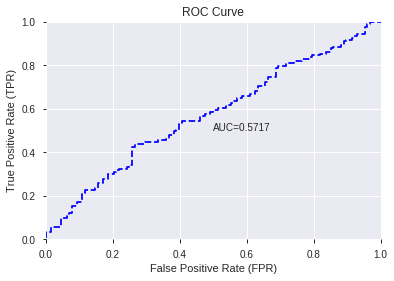

This function is available for GLM models only


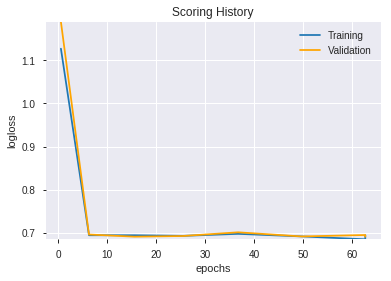

--2019-08-27 18:30:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_182257_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_182257_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_12',
 'BOP',
 'MACDEXT_hist',
 'BETA_14',
 'BBANDS_middleband_14_1_5',
 'BETA_12',
 'aroondown_24',
 'NATR_24',
 'PPO',
 'aroonup_20',
 'STOCHRSI_fastd',
 'MA_14_3',
 'ADX_8',
 'BBANDS_middleband_20_3_5',
 'AROONOSC_20',
 'CCI_8',
 'TRANGE',
 'CORREL_14',
 'AD',
 'aroondown_14',
 'MACDEXT',
 'aroondown_30',
 'STOCHF_fastk',
 'STDDEV_8',
 'WILLR_12',
 'MACDFIX_hist_12',
 'aroonup_14',
 'NATR_8',
 'PLUS_DI_20',
 'MINUS_DI_8',
 'MFI_30',
 'RSI_8',
 'ROCP_24',
 'CCI_12',
 'PLUS_DM_8',
 'AROONOSC_12',
 'RSI_24',
 'ROCR100_12',
 'ROCR100_14',
 'CDLSPINNINGTOP',
 'ROCP_14',
 'CCI_30',
 'ROCR_24',
 'MOM_14',
 'WILLR_8',
 'WILLR_24',
 'MACD_hist',
 'MFI_8',
 'STOCH_slowd',
 'LINEARREG_SLOPE_12',
 'CMO_12',
 'aroonup_12',
 'ROCP_20',
 'MOM_30',
 'MOM_12',
 'MINUS_DI_12',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_8',
 'ROC_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_183034_model_1  0.50343  0.693618              0.484375  0.500235  0.250235

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd             0.010002           1.000000    0.051705
1               MACDEXT_hist             0.009448           0.944625    0.048841
2                        BOP             0.009322           0.932058    0.048192
3                 ROCR100_12             0.006558           0.655682    0.033902
4                     ROC_12             0.006545           0.654418    0.033836
5                     MOM_12             0.006161           0.616052    0.031853
6                 ROCR100_14             0.005693           0.569247    0.029433
7                    ROCP_14             0.005686           0.568534    0.029396
8                      CCI_8             0.005632           0.563073    0.029113
9               aroondown_30             0.005629           0.562812    0.029100
10              STOCHF_fastk             0.005573           0.557239    0.028812
11                   MACDEXT             0.005567           0.556616    0.028780
12                aroonup_20             0.005008           0.500730    0.025890
13                   ROCR_24             0.004934           0.493304    0.025506
14                   ROCP_24             0.004913           0.491204    0.025397
15                   BETA_12             0.004678           0.467685    0.024181
16               AROONOSC_20             0.004627           0.462608    0.023919
17                     RSI_8             0.004336           0.433529    0.022415
18                    NATR_8             0.004179           0.417838    0.021604
19                       PPO             0.003960           0.395902    0.020470
20         LINEARREG_ANGLE_8             0.003841           0.384036    0.019856
21                    MOM_30             0.003790           0.378939    0.019593
22                    MOM_14             0.003550           0.354938    0.018352
23              aroondown_14             0.003527           0.352633    0.018233
24                    CCI_12             0.003492           0.349098    0.018050
25                  WILLR_24             0.003456           0.345558    0.017867
26                   WILLR_8             0.003341           0.334055    0.017272
27                   ROCP_20             0.003324           0.332370    0.017185
28                  WILLR_12             0.003285           0.328487    0.016984
29                   NATR_24             0.003176           0.317593    0.016421
30                 MACD_hist             0.002992           0.299201    0.015470
31            CDLSPINNINGTOP             0.002978           0.297767    0.015396
32                  STDDEV_8             0.002522           0.252122    0.013036
33                   BETA_14             0.002504           0.250327    0.012943
34               MINUS_DI_12             0.002340           0.233959    0.012097
35               STOCH_slowd             0.002247           0.224638    0.011615
36           MACDFIX_hist_12             0.002157           0.215696    0.011152
37                     ADX_8             0.002038           0.203789    0.010537
38                    CCI_30             0.001890           0.189016    0.009773
39                 PLUS_DM_8             0.001831           0.183024    0.009463
40                aroonup_12             0.001636           0.163603    0.008459
41                    CMO_12             0.001550           0.154971    0.008013
42        LINEARREG_SLOPE_12             0.001513           0.151239    0.007820
43                 CORREL_12             0.001496           0.149578    0.007734
44  BBANDS_middleband_14_1_5             0.001405           0.140494    0.007264
45                    RSI_24             0.001382           0.138228    0.007147
46                        AD             0.001263           0.126261    0.006528
47                 PLUS_DI_8             0.001092           0.109172    0.005645
48                   MA_14_3             0.001071  

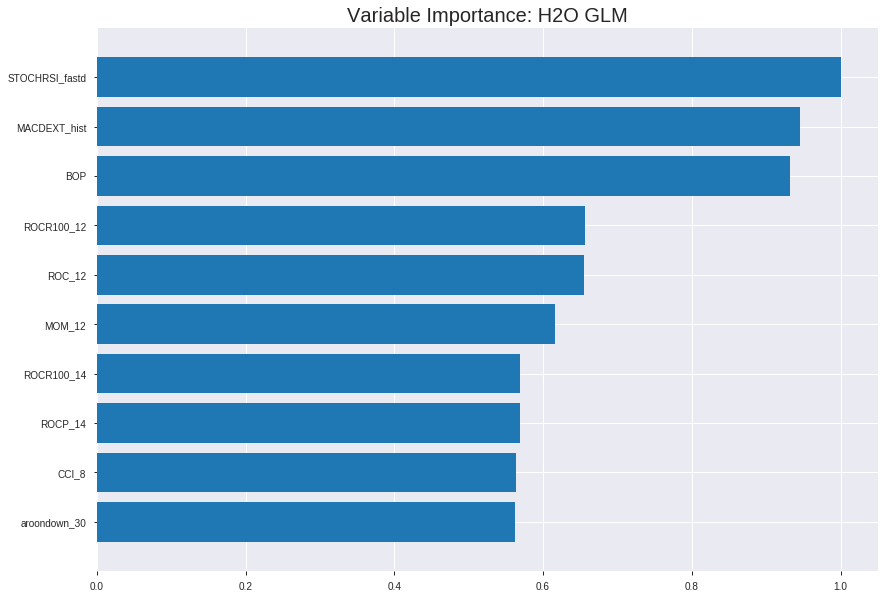

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_183034_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24898832581762514
RMSE: 0.4989873002568554
LogLoss: 0.6911222092487331
Null degrees of freedom: 1752
Residual degrees of freedom: 1693
Null deviance: 2429.9224402865125
Residual deviance: 2423.0744656260586
AIC: 2543.0744656260586
AUC: 0.5462967784602326
pr_auc: 0.5453849719689363
Gini: 0.09259355692046523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47680232963312025: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      13   853   0.985    (853.0/866.0)
1      3    884   0.0034   (3.0/887.0)
Total  16   1737  0.4883   (856.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.476802     0.67378    386
max f2                       0.461131     0.836635   399
max f0point5                 0.490402     0.56597    317
max accuracy                 0.500876     0.541928   238
max precision                0.54546      1          0
max recall                   0.461131     1          399
max specificity              0.54546      1          0
max absolute_mcc             0.500876     0.0833403  238
max min_per_class_accuracy   0.505296     0.530023   204
max mean_per_class_accuracy  0.500876     0.540557   238

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.538102           1.20775   1.20775            0.611111         0.541046  0.611111                    0.541046            0.0124014       0.0124014                  20.7754   20.7754
    2        0.0205362                   0.534805           1.42735   1.31755            0.722222         0.536375  0.666667                    0.538711            0.0146561       0.0270575                  42.7346   31.755
    3        0.0302339                   0.532421           1.16254   1.26783            0.588235         0.533476  0.641509                    0.537031            0.011274        0.0383315                  16.2544   26.7831
    4        0.040502                    0.531092           1.09796   1.22476            0.555556         0.531545  0.619718                    0.53564             0.011274        0.0496054                  9.79582   22.4765
    5        0.0501997                   0.530137           0.930035  1.16783            0.470588         0.530653  0.590909                    0.534677            0.00901917      0.0586246                  -6.99649  16.7828
    6        0.100399                    0.525306           1.078     1.12291            0.545455         0.527239  0.568182                    0.530958            0.054115        0.11274                    7.79953   12.2912
    7        0.150029                    0.521861           1.20397   1.14973            0.609195         0.523667  0.581749                    0.528546            0.059752        0.172492                   20.3968   14.9725
    8        0.200228                    0.518657           1.03308   1.12048            0.522727         0.520263  0.566952                    0.52647             0.0518602       0.224352                   3.30788   12.048
    9        0.300057                    0.513954           1.02769   1.08961            0.52             0.516323  0.551331                    0.523094            0.102593        0.326945                   2.76888   8.96087
    10       0.399886                    0.509452           0.971222  1.06005            0.491429         0.511818  0.536377                    0.520279            0.096956        0.423901                   -2.87776  6.00543
    11       0.500285                    0.505259           1.06677   1.0614             0.539773         0.507411  0.537058                    0.517696            0.107103        0.531003                   6.67662   6.14013
    12       0.600114                    0.501321           1.05028   1.05955            0.531429         0.503252  0.536122                    0.515294            0.104848        0.635851                   5.02754   5.95505
    13       0.699943                    0.497397           0.892169  1.03568            0.451429         0.499479  0.524042                    0.513038            0.0890643       0.724915                   -10.7831  3.56779
    14       0.799772                    0.4935             1.03898   1.03609            0.525714         0.495385  0.524251                    0.510835            0.10372         0.828636                   3.89821   3.60903
    15       0.899601                    0.487798           0.85829   1.01636            0.434286         0.490833  0.514268                    0.508615            0.0856821       0.914318                   -14.171   1.63597
    16       1                           0.461131           0.853413  1                  0.431818         0.482467  0.50599                     0.50599            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24879708144832777
RMSE: 0.49879563094350354
LogLoss: 0.690739316235769
Null degrees of freedom: 500
Residual degrees of freedom: 441
Null deviance: 693.9584553730234
Residual deviance: 692.1207948682405
AIC: 812.1207948682405
AUC: 0.5481476153944508
pr_auc: 0.5700575398240862
Gini: 0.09629523078890156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4821971453904444: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    229  0.9662   (229.0/237.0)
1      4    260  0.0152   (4.0/264.0)
Total  12   489  0.4651   (233.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482197     0.690571  388
max f2                       0.473507     0.847784  399
max f0point5                 0.491195     0.588677  338
max accuracy                 0.508979     0.548902  170
max precision                0.543566     1         0
max recall                   0.473507     1         399
max specificity              0.543566     1         0
max absolute_mcc             0.51749      0.118867  93
max min_per_class_accuracy   0.506835     0.541667  196
max mean_per_class_accuracy  0.508979     0.552551  170

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.537164           1.26515   1.26515            0.666667         0.539234  0.666667                    0.539234            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.534778           1.13864   1.20764            0.6              0.535497  0.636364                    0.537536            0.0113636       0.0265152                  13.8636   20.7645
    3        0.0319361                   0.530693           0.759091  1.06747            0.4              0.531868  0.5625                      0.535765            0.00757576      0.0340909                  -24.0909  6.74716
    4        0.0419162                   0.528883           1.51818   1.17478            0.8              0.529287  0.619048                    0.534222            0.0151515       0.0492424                  51.8182   17.4784
    5        0.0518962                   0.527201           1.51818   1.24082            0.8              0.527841  0.653846                    0.532995            0.0151515       0.0643939                  51.8182   24.0822
    6        0.101796                    0.523179           1.13864   1.19073            0.6              0.524566  0.627451                    0.528863            0.0568182       0.121212                   13.8636   19.0731
    7        0.151697                    0.520513           1.06273   1.14862            0.56             0.521614  0.605263                    0.526478            0.0530303       0.174242                   6.27273   14.8624
    8        0.201597                    0.517692           1.29045   1.18373            0.68             0.519078  0.623762                    0.524647            0.0643939       0.238636                   29.0455   18.3731
    9        0.301397                    0.514138           1.02477   1.1311             0.54             0.515804  0.596026                    0.521719            0.102273        0.340909                   2.47727   13.1096
    10       0.401198                    0.510071           0.986818  1.09521            0.52             0.512193  0.577114                    0.519349            0.0984848       0.439394                   -1.31818  9.52058
    11       0.500998                    0.506716           1.02477   1.08118            0.54             0.508337  0.569721                    0.517155            0.102273        0.541667                   2.47727   8.11753
    12       0.600798                    0.503579           0.759091  1.02767            0.4              0.505     0.541528                    0.515136            0.0757576       0.617424                   -24.0909  2.76729
    13       0.700599                    0.499564           1.06273   1.03267            0.56             0.501069  0.54416                     0.513132            0.106061        0.723485                   6.27273   3.26664
    14       0.800399                    0.49463            0.759091  0.998555           0.4              0.49725   0.526185                    0.511152            0.0757576       0.799242                   -24.0909  -0.144525
    15       0.9002                      0.488485           1.13864   1.01408            0.6              0.491761  0.534368                    0.509002            0.113636        0.912879                   13.8636   1.40849
    16       1                           0.473507           0.872955  1                  0.46             0.483639  0.526946                    0.506471       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:30:34  0.000 sec   2            2.6       60            1.38325           1.38159
    2019-08-27 18:30:34  0.017 sec   4            1.6       60            1.38224           1.38148
    2019-08-27 18:30:34  0.037 sec   6            1         60            1.38098           1.3817
    2019-08-27 18:30:34  0.060 sec   8            0.62      60            1.37943           1.38227
    2019-08-27 18:30:34  0.075 sec   10           0.39      60            1.37755           1.38312
    2019-08-27 18:30:34  0.093 sec   12           0.24      60            1.37535           1.38416
    2019-08-27 18:30:34  0.110 sec   14           0.15      60            1.37291           1.3853

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5258964143426295)

('F1', 0.6648648648648648)

('auc', 0.5034298780487805)

('logloss', 0.6936178126046145)

('mean_per_class_error', 0.4746887703252033)

('rmse', 0.5002350609182372)

('mse', 0.25023511617187255)

glm prediction progress: |████████████████████████████████████████████████| 100%


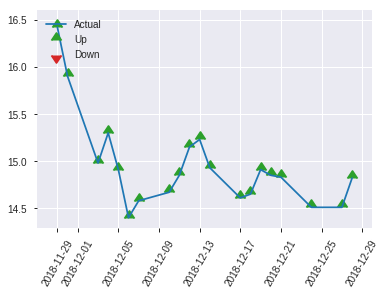


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25023511617187255
RMSE: 0.5002350609182372
LogLoss: 0.6936178126046145
Null degrees of freedom: 250
Residual degrees of freedom: 191
Null deviance: 348.11570799031966
Residual deviance: 348.1961419275164
AIC: 468.1961419275164
AUC: 0.5034298780487805
pr_auc: 0.49319244500538456
Gini: 0.006859756097560954
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4826442995264693: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    124  0.9688   (124.0/128.0)
1      0    123  0        (0.0/123.0)
Total  4    247  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482644     0.664865  246
max f2                       0.482644     0.832206  246
max f0point5                 0.482644     0.553555  246
max accuracy                 0.508551     0.525896  117
max precision                0.537908     1         0
max recall                   0.482644     1         246
max specificity              0.537908     1         0
max absolute_mcc             0.482644     0.124747  246
max min_per_class_accuracy   0.507265     0.512195  123
max mean_per_class_accuracy  0.508551     0.525311  117

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.535277           1.36043   1.36043            0.666667         0.536302  0.666667                    0.536302            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.531031           1.36043   1.36043            0.666667         0.532698  0.666667                    0.5345              0.0162602       0.0325203                  36.0434   36.0434
    3        0.0318725                   0.530534           0         1.02033            0                0.530838  0.5                         0.533584            0               0.0325203                  -100      2.03252
    4        0.0438247                   0.529918           0.680217  0.927568           0.333333         0.530066  0.454545                    0.532625            0.00813008      0.0406504                  -31.9783  -7.24316
    5        0.0517928                   0.529107           2.04065   1.09881            1                0.529529  0.538462                    0.532149            0.0162602       0.0569106                  104.065   9.88118
    6        0.103586                    0.525289           0.784866  0.941839           0.384615         0.527065  0.461538                    0.529607            0.0406504       0.097561                   -21.5134  -5.81614
    7        0.151394                    0.521542           1.02033   0.966624           0.5              0.523509  0.473684                    0.527681            0.0487805       0.146341                   2.03252   -3.33761
    8        0.203187                    0.520258           0.941839  0.960306           0.461538         0.520994  0.470588                    0.525977            0.0487805       0.195122                   -5.81614  -3.96939
    9        0.302789                    0.516694           0.979512  0.966624           0.48             0.518615  0.473684                    0.523555            0.097561        0.292683                   -2.04878  -3.33761
    10       0.40239                     0.512258           1.14276   1.01022            0.56             0.514168  0.49505                     0.521232            0.113821        0.406504                   14.2764   1.0223
    11       0.501992                    0.506701           1.06114   1.02033            0.52             0.509472  0.5                         0.518898            0.105691        0.512195                   6.11382   2.03252
    12       0.601594                    0.503937           1.06114   1.02708            0.52             0.505505  0.503311                    0.516681            0.105691        0.617886                   6.11382   2.70823
    13       0.701195                    0.500938           0.897886  1.00873            0.44             0.502338  0.494318                    0.514644            0.0894309       0.707317                   -10.2114  0.87306
    14       0.800797                    0.495566           1.06114   1.01525            0.52             0.498613  0.497512                    0.51265             0.105691        0.813008                   6.11382   1.5249
    15       0.900398                    0.491073           0.81626   0.993237           0.4              0.493264  0.486726                    0.510505            0.0813008       0.894309                   -18.374   -0.676308
    16       1                           0.477472           1.06114   1                  0.52             0.486845  0.49004                     0.508149    

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


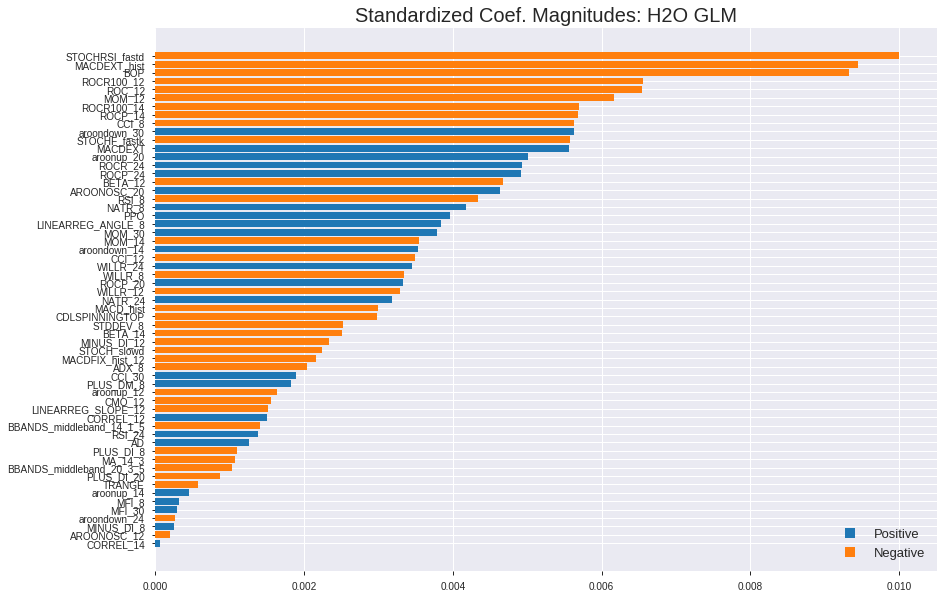

'log_likelihood'
--2019-08-27 18:30:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_183034_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_183034_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCHRSI_fastd',
 'MACDEXT_hist',
 'BOP',
 'ROCR100_12',
 'ROC_12',
 'MOM_12',
 'ROCR100_14',
 'ROCP_14',
 'CCI_8',
 'aroondown_30',
 'STOCHF_fastk',
 'MACDEXT',
 'aroonup_20',
 'ROCR_24',
 'ROCP_24',
 'BETA_12',
 'AROONOSC_20',
 'RSI_8',
 'NATR_8',
 'PPO',
 'LINEARREG_ANGLE_8',
 'MOM_30',
 'MOM_14',
 'aroondown_14',
 'CCI_12',
 'WILLR_24',
 'WILLR_8',
 'ROCP_20',
 'WILLR_12',
 'NATR_24',
 'MACD_hist',
 'CDLSPINNINGTOP',
 'STDDEV_8',
 'BETA_14',
 'MINUS_DI_12',
 'STOCH_slowd',
 'MACDFIX_hist_12',
 'ADX_8',
 'CCI_30',
 'PLUS_DM_8',
 'aroonup_12',
 'CMO_12',
 'LINEARREG_SLOPE_12',
 'CORREL_12',
 'BBANDS_middleband_14_1_5',
 'RSI_24',
 'AD',
 'PLUS_DI_8',
 'MA_14_3',
 'BBANDS_middleband_20_3_5',
 'PLUS_DI_20',
 'TRANGE',
 'aroonup_14',
 'MFI_8',
 'MFI_30',
 'aroondown_24',
 'MINUS_DI_8',
 'AROONOSC_12',
 'CORREL_14']

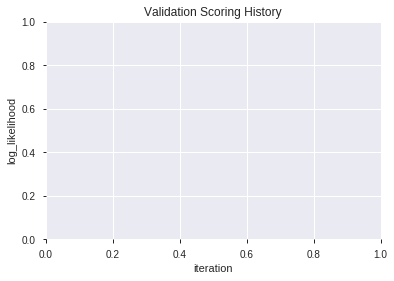

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_183046_model_1  0.584159  0.687575              0.492346  0.497104  0.247113
1  XGBoost_grid_1_AutoML_20190827_183046_model_6  0.554942  0.688881              0.450330  0.497862  0.247867
2  XGBoost_grid_1_AutoML_20190827_183046_model_2  0.538808  0.694007              0.458302  0.500389  0.250389
3               XGBoost_3_AutoML_20190827_183046  0.532012  0.695086              0.484693  0.500921  0.250921
4               XGBoost_2_AutoML_20190827_183046  0.525978  0.700657              0.496094  0.503540  0.253553
5  XGBoost_grid_1_AutoML_20190827_183046_model_3  0.523374  0.697497              0.480628  0.502109  0.252113
6  XGBoost_grid_1_AutoML_20190827_183046_model_4  0.522739  0.695167              0.473133  0.500979  0.250980
7  XGBoost_grid_1_AutoML_20190827_183046_model_7  0.519436  0.707808              0.500000  0.506899  0.256947
8  XGBoost_grid_1_AutoML_20190827_183046_model_5  0.511623  0.721998              0.476721  0.512958  0.263126
9               XGBoost_1_AutoML_20190827_183046  0.497332  0.710721              0.488440  0.508422  0.258493

variable  relative_importance  scaled_importance  percentage
0                     RSI_24           231.532440           1.000000    0.054539
1                        BOP           203.462616           0.878765    0.047927
2                  CORREL_14           163.178619           0.704776    0.038438
3               MACDEXT_hist           145.674911           0.629177    0.034315
4                     TRANGE           142.287262           0.614546    0.033517
5            MACDFIX_hist_12           138.085007           0.596396    0.032527
6             STOCHRSI_fastd           129.159561           0.557846    0.030425
7                   STDDEV_8           129.077179           0.557491    0.030405
8                     MOM_30           127.070526           0.548824    0.029932
9                    ROCP_20           125.200928           0.540749    0.029492
10                   BETA_12           123.453484           0.533202    0.029080
11                     MFI_8           120.124863           0.518825    0.028296
12         LINEARREG_ANGLE_8           119.839569           0.517593    0.028229
13                   MA_14_3           119.346268           0.515462    0.028113
14                     CCI_8           115.741493           0.499893    0.027264
15                        AD           109.510628           0.472982    0.025796
16                 PLUS_DM_8           107.991188           0.466419    0.025438
17                PLUS_DI_20           105.154915           0.454169    0.024770
18               STOCH_slowd           100.857346           0.435608    0.023758
19                 CORREL_12            98.205513           0.424154    0.023133
20               MINUS_DI_12            93.085503           0.402041    0.021927
21                   NATR_24            89.434097           0.386270    0.021067
22                  WILLR_24            84.210907           0.363711    0.019837
23                    MOM_12            78.011337           0.336935    0.018376
24                    CCI_12            74.755577           0.322873    0.017609
25                  WILLR_12            73.224068           0.316258    0.017249
26        LINEARREG_SLOPE_12            70.617828           0.305002    0.016635
27              STOCHF_fastk            67.567863           0.291829    0.015916
28                    CCI_30            58.441841           0.252413    0.013766
29                 PLUS_DI_8            56.459438           0.243851    0.013299
30                   ROCP_24            54.384613           0.234890    0.012811
31                MINUS_DI_8            54.215054           0.234157    0.012771
32                     RSI_8            54.042953           0.233414    0.012730
33                    NATR_8            53.710899           0.231980    0.012652
34                     ADX_8            53.689903           0.231889    0.012647
35  BBANDS_middleband_14_1_5            47.696869           0.206005    0.011235
36                 MACD_hist            44.353481           0.191565    0.010448
37                    ROC_12            39.734818           0.171617    0.009360
38                   BETA_14            37.951057           0.163912    0.008940
39                aroonup_12            37.365162           0.161382    0.008802
40                    MFI_30            36.546280           0.157845    0.008609
41                       PPO            35.055725           0.151407    0.008258
42                    CMO_12            34.735268           0.150023    0.008182
43                   ROCP_14            32.497269           0.140357    0.007655
44  BBANDS_middleband_20_3_5            30.993088           0.133861    0.007301
45               AROONOSC_12            28.442566           0.122845    0.006700
46                    MOM_14            24.786118           0.107052    0.005839
47                   WILLR_8            19.693943           0.085059    0.004639
48                aroonup_20            18.985161  

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_183046_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19249205556352741
RMSE: 0.43873916575059424
LogLoss: 0.5752152603662022
Mean Per-Class Error: 0.16651348318409886
AUC: 0.9156998315415639
pr_auc: 0.919006299634614
Gini: 0.8313996630831277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4966694480843014: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      670  196  0.2263   (196.0/866.0)
1      100  787  0.1127   (100.0/887.0)
Total  770  983  0.1689   (296.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496669     0.841711  213
max f2                       0.459063     0.894925  252
max f0point5                 0.534368     0.855868  166
max accuracy                 0.510331     0.833428  197
max precision                0.788224     1         0
max recall                   0.371935     1         339
max specificity              0.788224     1         0
max absolute_mcc             0.510331     0.666926  197
max min_per_class_accuracy   0.509178     0.830891  198
max mean_per_class_accuracy  0.510331     0.833487  197

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.725383           1.97632    1.97632            1                0.748049  1                           0.748049            0.0202931       0.0202931                  97.6325   97.6325
    2        0.0205362                   0.703314           1.97632    1.97632            1                0.711782  1                           0.729916            0.0202931       0.0405862                  97.6325   97.6325
    3        0.0302339                   0.686621           1.97632    1.97632            1                0.694995  1                           0.718715            0.0191657       0.059752                   97.6325   97.6325
    4        0.040502                    0.672987           1.97632    1.97632            1                0.680148  1                           0.708937            0.0202931       0.0800451                  97.6325   97.6325
    5        0.0501997                   0.663329           1.97632    1.97632            1                0.66687   1                           0.70081             0.0191657       0.0992108                  97.6325   97.6325
    6        0.100399                    0.631603           1.95387    1.9651             0.988636         0.64745   0.994318                    0.67413             0.0980834       0.197294                   95.3866   96.5096
    7        0.150029                    0.609662           1.93089    1.95378            0.977011         0.620012  0.988593                    0.656228            0.0958286       0.293123                   93.0892   95.3781
    8        0.200228                    0.587757           1.84158    1.92565            0.931818         0.598046  0.974359                    0.641641            0.0924464       0.385569                   84.1575   92.565
    9        0.300057                    0.555446           1.77305    1.87488            0.897143         0.57064   0.948669                    0.618019            0.177001        0.56257                    77.3046   87.4878
    10       0.399886                    0.53048            1.46813    1.77334            0.742857         0.542395  0.89729                     0.59914             0.146561        0.709132                   46.8127   77.3336
    11       0.500285                    0.509194           1.20152    1.65858            0.607955         0.519916  0.839225                    0.583241            0.120631        0.829763                   20.1516   65.858
    12       0.600114                    0.484463           0.813116   1.51794            0.411429         0.497562  0.768061                    0.568988            0.0811725       0.910936                   -18.6884  51.7938
    13       0.699943                    0.453025           0.508198   1.37392            0.257143         0.469353  0.695192                    0.554778            0.0507328       0.961669                   -49.1802  37.3924
    14       0.799772                    0.421692           0.225866   1.23062            0.114286         0.437628  0.622682                    0.540155            0.0225479       0.984216                   -77.4134  23.0622
    15       0.899601                    0.378848           0.146813   1.11035            0.0742857        0.401777  0.561826                    0.524799            0.0146561       0.998873                   -85.3187  11.0351
    16       1                           0.200233           0.0112291  1                  0.00568182       0.333392  0.50599                     0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25785715167125434
RMSE: 0.5077963683123918
LogLoss: 0.7092880770634751
Mean Per-Class Error: 0.4715189873417721
AUC: 0.4736446745940417
pr_auc: 0.4932186416549085
Gini: -0.052710650811916615
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32446351647377014: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    233  0.9831   (233.0/237.0)
1      0    264  0        (0.0/264.0)
Total  4    497  0.4651   (233.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324464     0.693824  395
max f2                       0.324464     0.849968  395
max f0point5                 0.400339     0.587264  363
max accuracy                 0.43768      0.54491   314
max precision                0.739939     1         0
max recall                   0.324464     1         395
max specificity              0.739939     1         0
max absolute_mcc             0.517783     0.116992  156
max min_per_class_accuracy   0.501516     0.465909  193
max mean_per_class_accuracy  0.43768      0.528481  314

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 49.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.675494           0.632576  0.632576           0.333333         0.712461  0.333333                    0.712461            0.00757576      0.00757576                 -36.7424  -36.7424
    2        0.0219561                   0.650122           1.13864   0.862603           0.6              0.655552  0.454545                    0.686593            0.0113636       0.0189394                  13.8636   -13.7397
    3        0.0319361                   0.646714           0.759091  0.830256           0.4              0.647714  0.4375                      0.674443            0.00757576      0.0265152                  -24.0909  -16.9744
    4        0.0419162                   0.636359           0.379545  0.722944           0.2              0.640543  0.380952                    0.666372            0.00378788      0.030303                   -62.0455  -27.7056
    5        0.0518962                   0.624769           0.379545  0.656906           0.2              0.629936  0.346154                    0.659365            0.00378788      0.0340909                  -62.0455  -34.3094
    6        0.101796                    0.588647           1.13864   0.893048           0.6              0.604802  0.470588                    0.632618            0.0568182       0.0909091                  13.8636   -10.6952
    7        0.151697                    0.568025           0.910909  0.898923           0.48             0.578083  0.473684                    0.614679            0.0454545       0.136364                   -8.90909  -10.1077
    8        0.201597                    0.553109           0.986818  0.92068            0.52             0.559416  0.485149                    0.601               0.0492424       0.185606                   -1.31818  -7.93204
    9        0.301397                    0.534258           0.835     0.892309           0.44             0.544177  0.470199                    0.582184            0.0833333       0.268939                   -16.5     -10.7691
    10       0.401198                    0.516139           0.835     0.878053           0.44             0.52373   0.462687                    0.567644            0.0833333       0.352273                   -16.5     -12.1947
    11       0.500998                    0.500516           1.17659   0.937523           0.62             0.508684  0.494024                    0.555899            0.117424        0.469697                   17.6591   -6.24774
    12       0.600798                    0.481531           1.17659   0.977235           0.62             0.490006  0.51495                     0.544953            0.117424        0.587121                   17.6591   -2.2765
    13       0.700599                    0.460105           1.2525    1.01645            0.66             0.47184   0.535613                    0.534538            0.125           0.712121                   25.25     1.64465
    14       0.800399                    0.438148           1.13864   1.03168            0.6              0.449393  0.543641                    0.523921            0.113636        0.825758                   13.8636   3.16822
    15       0.9002                      0.409312           0.872955  1.01408            0.46             0.426772  0.534368                    0.513151            0.0871212       0.912879                   -12.7045  1.40849
    16       1                           0.290641           0.872955  1                  0.46             0.377341  0.526946                    0.4995


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:30:51  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.49401                          0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 18:30:51  0.124 sec   5                  0.492231         0.677706            0.753027        0.75827            1.97632          0.339989                         0.500633           0.694414              0.475163          0.502828             1.08442            0.46507
    2019-08-27 18:30:51  0.178 sec   10                 0.48438          0.662267            0.80426         0.809629           1.97632          0.2915                           0.501288           0.695733              0.482835          0.504264             0.948864           0.467066
    2019-08-27 18:30:51  0.229 sec   15                 0.477645         0.64917             0.839027        0.844097           1.97632          0.271535                         0.501661           0.696483              0.485144          0.499037             0.632576           0.46507
    2019-08-27 18:30:51  0.282 sec   20                 0.472327         0.638832            0.846611        0.850316           1.97632          0.244153                         0.501989           0.697141              0.488101          0.507669             1.26515            0.463074
    2019-08-27 18:30:51  0.340 sec   25                 0.464693         0.624185            0.873497        0.877684           1.97632          0.216201                         0.504389           0.702034              0.466069          0.495398             0.948864           0.467066
    2019-08-27 18:30:51  0.407 sec   30                 0.458623         0.612529            0.878662        0.884315           1.97632          0.210496                         0.505863           0.705115              0.462745          0.488173             0.316288           0.469062
    2019-08-27 18:30:51  0.471 sec   35                 0.453294         0.602482            0.893293        0.898523           1.97632          0.181974                         0.506361           0.706141              0.461546          0.489866             0.632576           0.467066
    2019-08-27 18:30:51  0.533 sec   40                 0.447303         0.591232            0.905173        0.908646           1.97632          0.173987                         0.50636            0.706257              0.473669          0.49233              0.632576           0.463074
    2019-08-27 18:30:51  0.590 sec   45                 0.442806         0.582852            0.912566        0.915601           1.97632          0.167712                         0.506721           0.707018              0.47597           0.493913             0.632576           0.46507
    2019-08-27 18:30:51  0.658 sec   50                 0.438739         0.575215            0.9157          0.919006           1.97632          0.168853                         0.507796           0.709288              0.473645          0.493219             0.632576           0.46507

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
RSI_24        231.53244018554688     1.0                   0.05453930375632069
BOP           203.46261596679688     0.8787650482314476    0.047927233895932723
CORREL_14     163.17861938476562     0.70477648511801      0.03843801880216318
MACDEXT_hist  145.67491149902344     0.6291771096192033    0.0343148814980456
TRANGE        142.28726196289062     0.6145456846084445    0.033516893764996
---           ---                    ---                   ---
aroonup_14    12.313521385192871     0.05318270465825431   0.0029005476839392232
ROCR_24       10.989645004272461     0.047464817437528464  0.002588698095963672
ROCR100_14    10.237510681152344     0.044216312292774805  0.002411526887119982
AROONOSC_20   9.40739631652832       0.04063100751233548   0.0022159868606406127
aroondown_14  4.6089396476745605     0.019906237087040677  0.001085672311135448


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5976095617529881)

('F1', 0.6594594594594595)

('auc', 0.5841590447154471)

('logloss', 0.6875753241209541)

('mean_per_class_error', 0.40342352642276424)

('rmse', 0.49710439419707025)

('mse', 0.24711277873003623)

xgboost prediction progress: |████████████████████████████████████████████| 100%


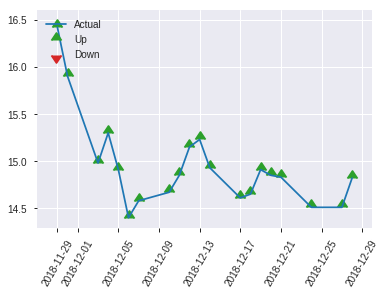


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24711277873003623
RMSE: 0.49710439419707025
LogLoss: 0.6875753241209541
Mean Per-Class Error: 0.40342352642276424
AUC: 0.5841590447154471
pr_auc: 0.5372539605881212
Gini: 0.1683180894308942
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35230106115341187: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    125  0.9766   (125.0/128.0)
1      1    122  0.0081   (1.0/123.0)
Total  4    247  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352301     0.659459  246
max f2                       0.324394     0.827725  250
max f0point5                 0.520602     0.58669   111
max accuracy                 0.520902     0.59761   109
max precision                0.798893     1         0
max recall                   0.324394     1         250
max specificity              0.798893     1         0
max absolute_mcc             0.520902     0.194285  109
max min_per_class_accuracy   0.516926     0.569106  122
max mean_per_class_accuracy  0.520602     0.596576  111

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.711652           1.36043   1.36043            0.666667         0.744035  0.666667                    0.744035            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.670602           0.680217  1.02033            0.333333         0.687937  0.5                         0.715986            0.00813008      0.0243902                  -31.9783  2.03252
    3        0.0318725                   0.658038           0         0.765244           0                0.663705  0.375                       0.702916            0               0.0243902                  -100      -23.4756
    4        0.0438247                   0.643227           1.36043   0.927568           0.666667         0.651087  0.454545                    0.688781            0.0162602       0.0406504                  36.0434   -7.24316
    5        0.0517928                   0.636816           0         0.784866           0                0.638008  0.384615                    0.68097             0               0.0406504                  -100      -21.5134
    6        0.103586                    0.605354           0.941839  0.863352           0.461538         0.617045  0.423077                    0.649007            0.0487805       0.0894309                  -5.81614  -13.6648
    7        0.151394                    0.583949           1.8706    1.18143            0.916667         0.593515  0.578947                    0.631483            0.0894309       0.178862                   87.0596   18.1429
    8        0.203187                    0.566674           1.56973   1.28041            0.769231         0.575049  0.627451                    0.617098            0.0813008       0.260163                   56.9731   28.0408
    9        0.302789                    0.536085           1.14276   1.23513            0.56             0.546883  0.605263                    0.594001            0.113821        0.373984                   14.2764   23.5131
    10       0.40239                     0.524087           1.06114   1.19206            0.52             0.530543  0.584158                    0.578294            0.105691        0.479675                   6.11382   19.2063
    11       0.501992                    0.512026           0.897886  1.13369            0.44             0.51972   0.555556                    0.566672            0.0894309       0.569106                   -10.2114  13.3695
    12       0.601594                    0.498404           0.81626   1.08114            0.4              0.504476  0.529801                    0.556375            0.0813008       0.650407                   -18.374   8.11393
    13       0.701195                    0.472665           1.22439   1.10149            0.6              0.48304   0.539773                    0.545958            0.121951        0.772358                   22.439    10.1487
    14       0.800797                    0.458277           0.734634  1.05586            0.36             0.465937  0.517413                    0.536005            0.0731707       0.845528                   -26.5366  5.58589
    15       0.900398                    0.416848           0.81626   1.02935            0.4              0.437342  0.504425                    0.525091            0.0813008       0.926829                   -18.374   2.93546
    16       1                           0.324394           0.734634  1                  0.36             0.381899  0.49004                     0.510829     

This function is available for GLM models only


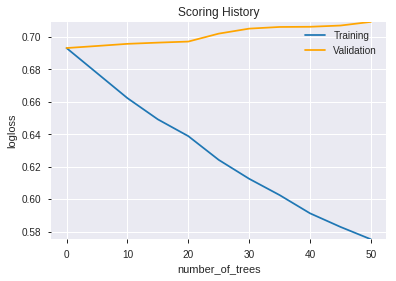

--2019-08-27 18:31:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_183046_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_183046_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_86f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['RSI_24',
 'BOP',
 'CORREL_14',
 'MACDEXT_hist',
 'TRANGE',
 'MACDFIX_hist_12',
 'STOCHRSI_fastd',
 'STDDEV_8',
 'MOM_30',
 'ROCP_20',
 'BETA_12',
 'MFI_8',
 'LINEARREG_ANGLE_8',
 'MA_14_3',
 'CCI_8',
 'AD',
 'PLUS_DM_8',
 'PLUS_DI_20',
 'STOCH_slowd',
 'CORREL_12',
 'MINUS_DI_12',
 'NATR_24',
 'WILLR_24',
 'MOM_12',
 'CCI_12',
 'WILLR_12',
 'LINEARREG_SLOPE_12',
 'STOCHF_fastk',
 'CCI_30',
 'PLUS_DI_8',
 'ROCP_24',
 'MINUS_DI_8',
 'RSI_8',
 'NATR_8',
 'ADX_8',
 'BBANDS_middleband_14_1_5',
 'MACD_hist',
 'ROC_12',
 'BETA_14',
 'aroonup_12',
 'MFI_30',
 'PPO',
 'CMO_12',
 'ROCP_14',
 'BBANDS_middleband_20_3_5',
 'AROONOSC_12',
 'MOM_14',
 'WILLR_8',
 'aroonup_20',
 'aroondown_24',
 'CDLSPINNINGTOP',
 'aroondown_30',
 'MACDEXT',
 'aroonup_14',
 'ROCR_24',
 'ROCR100_14',
 'AROONOSC_20',
 'aroondown_14']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.590
GLM             0.566
XGBoost         0.598
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.538    0.574
DLF          0.578  0.566    0.590
Fwe          0.590  0.538    0.574
RFE          0.590  0.526    0.598
XGBF         0.574  0.566    0.590





F1


DeepLearning    0.672
GLM             0.667
XGBoost         0.669
dtype: float64

DeepLearning    GLM  XGBoost
All          0.667  0.667    0.667
DLF          0.670  0.667    0.669
Fwe          0.661  0.667    0.667
RFE          0.665  0.665    0.659
XGBF         0.672  0.667    0.669





auc


DeepLearning    0.581
GLM             0.551
XGBoost         0.594
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.509    0.560
DLF          0.581  0.551    0.594
Fwe          0.564  0.509    0.560
RFE          0.572  0.503    0.584
XGBF         0.575  0.551    0.594





logloss


DeepLearning    0.822
GLM             0.694
XGBoost         0.691
dtype: float64

DeepLearning    GLM  XGBoost
All          0.687  0.693    0.691
DLF          0.822  0.689    0.679
Fwe          0.819  0.693    0.691
RFE          0.696  0.694    0.688
XGBF         0.694  0.689    0.679





mean_per_class_error


DeepLearning    0.430
GLM             0.475
XGBoost         0.431
dtype: float64

DeepLearning    GLM  XGBoost
All          0.426  0.456    0.431
DLF          0.426  0.440    0.413
Fwe          0.412  0.456    0.431
RFE          0.413  0.475    0.403
XGBF         0.430  0.440    0.413





rmse


DeepLearning    0.547
GLM             0.500
XGBoost         0.499
dtype: float64

DeepLearning    GLM  XGBoost
All          0.497  0.500    0.499
DLF          0.534  0.498    0.493
Fwe          0.547  0.500    0.499
RFE          0.501  0.500    0.497
XGBF         0.498  0.498    0.493





mse


DeepLearning    0.299
GLM             0.250
XGBoost         0.249
dtype: float64

DeepLearning    GLM  XGBoost
All          0.247  0.250    0.249
DLF          0.285  0.248    0.243
Fwe          0.299  0.250    0.249
RFE          0.251  0.250    0.247
XGBF         0.248  0.248    0.243

{'F1':       DeepLearning    GLM  XGBoost
 All          0.667    NaN      NaN
 DLF          0.670    NaN      NaN
 DLF            NaN  0.667      NaN
 DLF            NaN    NaN    0.669
 All            NaN  0.667      NaN
 All            NaN    NaN    0.667
 XGBF         0.672    NaN      NaN
 XGBF           NaN  0.667      NaN
 XGBF           NaN    NaN    0.669
 Fwe          0.661    NaN      NaN
 Fwe            NaN  0.667      NaN
 Fwe            NaN    NaN    0.667
 RFE          0.665    NaN      NaN
 RFE            NaN  0.665      NaN
 RFE            NaN    NaN    0.659,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.578    NaN      NaN
 DLF          0.578    NaN      NaN
 DLF            NaN  0.566      NaN
 DLF            NaN    NaN    0.590
 All            NaN  0.538      NaN
 All            NaN    NaN    0.574
 XGBF         0.574    NaN      NaN
 XGBF           NaN  0.566      NaN
 XGBF           NaN    NaN    0.590
 Fwe          0.590    NaN      NaN
 Fwe     